In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from itertools import product
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import precision_score
import os


seed = 42

In [2]:
def train_model(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_model(classifier, X, y):
    y_pred = classifier.predict(X)
    cm = confusion_matrix(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_roc = roc_auc_score(y, y_pred)
    success_rate_bankrupt = recall_score(y, y_pred)
    success_rate_healthy = recall_score(y, y_pred, pos_label=0)
    return cm, f1, auc_roc, success_rate_bankrupt, success_rate_healthy

def plot_confusion_matrix(cm, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks([0, 1], ['Predicted Healthy', 'Predicted Bankrupt'])
    plt.yticks([0, 1], ['Actual Healthy', 'Actual Bankrupt'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', color='black')
    plt.tight_layout()
    plt.show()

def cross_validation(X, y, classifiers, n_splits=4, random_state=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1_scores_train = {clf_name: {'healthy': [], 'bankrupt': []} for clf_name in classifiers}
    f1_scores_test = {clf_name: {'healthy': [], 'bankrupt': []} for clf_name in classifiers}
    success_rates_train = {clf_name: {'healthy': [], 'bankrupt': []} for clf_name in classifiers}
    success_rates_test = {clf_name: {'healthy': [], 'bankrupt': []} for clf_name in classifiers}

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for clf_name, clf in classifiers.items():
            clf = train_model(clf, X_train, y_train)
            cm_train, f1_train, _, success_rate_bankrupt_train, success_rate_healthy_train = evaluate_model(clf, X_train, y_train)
            cm_test, f1_test, _, success_rate_bankrupt_test, success_rate_healthy_test = evaluate_model(clf, X_test, y_test)

            f1_scores_train[clf_name]['healthy'].append(f1_train)
            f1_scores_train[clf_name]['bankrupt'].append(f1_train)

            f1_scores_test[clf_name]['healthy'].append(f1_test)
            f1_scores_test[clf_name]['bankrupt'].append(f1_test)

            success_rates_train[clf_name]['healthy'].append(success_rate_healthy_train)
            success_rates_train[clf_name]['bankrupt'].append(success_rate_bankrupt_train)

            success_rates_test[clf_name]['healthy'].append(success_rate_healthy_test)
            success_rates_test[clf_name]['bankrupt'].append(success_rate_bankrupt_test)

            plot_confusion_matrix(cm_train, f'{clf_name} - Train Set Confusion Matrix')
            plot_confusion_matrix(cm_test, f'{clf_name} - Test Set Confusion Matrix')

    return f1_scores_train, f1_scores_test, success_rates_train, success_rates_test

def balance_train_set(X_train, y_train, class_ratio=3, majority_class_label=0, random_seed=None):
    ratio = sum(y_train == 0) / sum(y_train == 1)
    print(ratio)

    if ratio > class_ratio:
        bankrupt_indices = np.where(y_train == 1)[0]

        majority_indices = np.where(y_train == majority_class_label)[0]
        minority_indices = np.where(y_train != majority_class_label)[0]

        np.random.seed(random_seed)
        np.random.shuffle(majority_indices)

        majority_indices = majority_indices[:len(minority_indices) * (class_ratio - 1)]

        train_index_balanced = np.concatenate([majority_indices, minority_indices])

        train_index_balanced = shuffle(train_index_balanced)

        X_train_balanced = X_train.iloc[train_index_balanced]
        y_train_balanced = y_train.iloc[train_index_balanced]

        return X_train_balanced, y_train_balanced
    else:
        return X_train, y_train

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_excel("/content/drive/MyDrive/Έγγραφα 2023 - 2024/Εξάμηνο 2/Μέθοδοι και Εργαλεία Τεχνητής Νοημοσύνης/Dataset2Use_Assignment1.xlsx")

Mounted at /content/drive


In [4]:
scaler = MinMaxScaler()

columns_to_normalize = ['365* ( Β.Υ / Κοστ.Πωλ )', 'Λειτ.Αποτ/Συν.Ενεργ. (ROA)',
                        'ΧΡΗΜ.ΔΑΠΑΝΕΣ / ΠΩΛΗΣΕΙΣ', 'ΠΡΑΓΜΑΤΙΚΗ ΡΕΥΣΤΟΤΗΤΑ :  (ΚΕ-ΑΠΟΘΕΜΑΤΑ) / Β.Υ',
                        '(ΑΠΑΙΤ.*365) / ΠΩΛ.', 'Συν.Υποχρ/Συν.Ενεργ', 'Διάρκεια Παραμονής Αποθεμάτων',
                        'Λογαριθμος Προσωπικού']

data_selected_normalized = data.copy()
data_selected_normalized[columns_to_normalize] = scaler.fit_transform(data_selected_normalized[columns_to_normalize])

In [5]:
data_df = pd.DataFrame(data_selected_normalized)

input_columns = [
'365* ( Β.Υ / Κοστ.Πωλ )', 'Λειτ.Αποτ/Συν.Ενεργ. (ROA)',
'ΧΡΗΜ.ΔΑΠΑΝΕΣ / ΠΩΛΗΣΕΙΣ', 'ΠΡΑΓΜΑΤΙΚΗ ΡΕΥΣΤΟΤΗΤΑ :  (ΚΕ-ΑΠΟΘΕΜΑΤΑ) / Β.Υ',
'(ΑΠΑΙΤ.*365) / ΠΩΛ.', 'Συν.Υποχρ/Συν.Ενεργ', 'Διάρκεια Παραμονής Αποθεμάτων',
'Λογαριθμος Προσωπικού', 'ΕΝΔΕΙΞΗ ΕΞΑΓΩΓΩΝ', 'ΕΝΔΕΙΞΗ ΕΙΣΑΓΩΓΩΝ',
'ΕΝΔΕΙΞΗ ΑΝΤΙΠΡΟΣΩΠΕΙΩΝ'
]

output_column = 'ΕΝΔΕΙΞΗ ΑΣΥΝΕΠΕΙΑΣ (=2) (ν+1)'

X = data_df[input_columns]

y = data_df[output_column]

In [6]:
y = y.replace({1: 0, 2: 1})

In [7]:
classifiers = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Linear Discriminant Analysis_lsqr_auto': LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
    'Logistic Regression_max_iter_1000': LogisticRegression(max_iter=1000),
    'Logistic Regression_max_iter_500': LogisticRegression(max_iter=500),
    'Logistic Regression_max_iter_1500_liblinear': LogisticRegression(max_iter=1500, solver='liblinear'),
    'Decision Tree_max_depth_5': DecisionTreeClassifier(max_depth=5),
    'Decision Tree_max_depth_10': DecisionTreeClassifier(max_depth=10),
    'Decision Tree_max_depth_15': DecisionTreeClassifier(max_depth=15),
    'Random Forest_n_estimators_100_max_depth_5': RandomForestClassifier(n_estimators=100, max_depth=5),
    'Random Forest_n_estimators_200_max_depth_10': RandomForestClassifier(n_estimators=200, max_depth=10),
    'Random Forest_n_estimators_300_max_depth_15': RandomForestClassifier(n_estimators=300, max_depth=15),
    'k-Nearest Neighbors_n_neighbors_5': KNeighborsClassifier(n_neighbors=5),
    'k-Nearest Neighbors_n_neighbors_10': KNeighborsClassifier(n_neighbors=10),
    'k-Nearest Neighbors_n_neighbors_15': KNeighborsClassifier(n_neighbors=15),
    'Naïve Bayes': GaussianNB(),
    'Naïve Bayes_var_smoothing_0.1': GaussianNB(var_smoothing=0.1),
    'Naïve Bayes_var_smoothing_0.01': GaussianNB(var_smoothing=0.01),
    'Support Vector Machines_rbf': SVC(kernel='rbf'),
    'Support Vector Machines_linear': SVC(kernel='linear'),
    'Support Vector Machines_poly_degree_2': SVC(kernel='poly', degree=2),
    'Gradient Boosting_n_estimators_100_learn_rate_0.1': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    'Gradient Boosting_n_estimators_200_learn_rate_0.05': GradientBoostingClassifier(n_estimators=200, learning_rate=0.05),
    'Gradient Boosting_n_estimators_300_learn_rate_0.01': GradientBoostingClassifier(n_estimators=300, learning_rate=0.01)
}

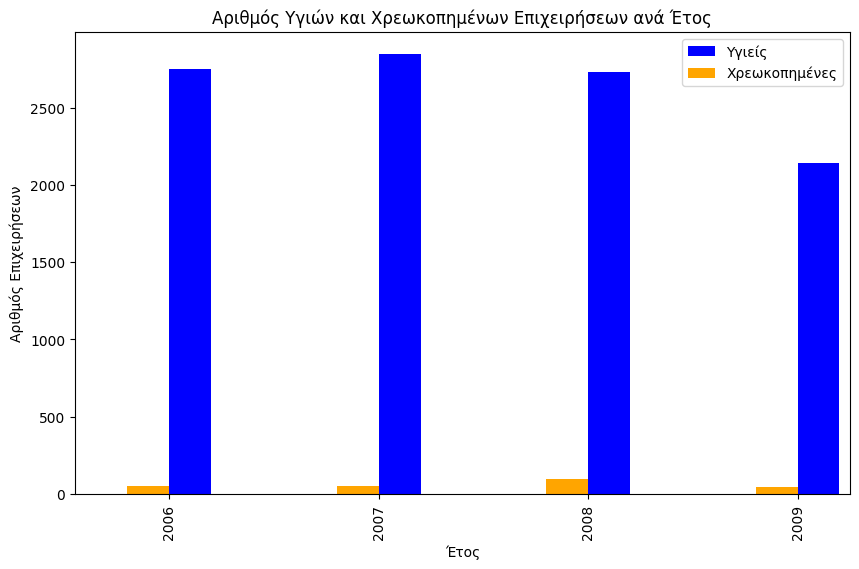

In [12]:
selected_columns = ["ΕΤΟΣ", "ΕΝΔΕΙΞΗ ΑΣΥΝΕΠΕΙΑΣ (=2) (ν+1)"]
data_selected = data[selected_columns]

company_counts = data_selected.groupby(["ΕΤΟΣ", "ΕΝΔΕΙΞΗ ΑΣΥΝΕΠΕΙΑΣ (=2) (ν+1)"]).size().unstack(fill_value=0)

company_counts.columns = ["Υγιείς", "Χρεωκοπημένες"]

company_counts["Υγιείς"].plot(kind='bar', color='blue', position=0, width=0.2, figsize=(10, 6), label="Υγιείς")

company_counts["Χρεωκοπημένες"].plot(kind='bar', color='orange', position=1, width=0.2, figsize=(10, 6), label="Χρεωκοπημένες")

plt.title("Αριθμός Υγιών και Χρεωκοπημένων Επιχειρήσεων ανά Έτος")
plt.xlabel("Έτος")
plt.ylabel("Αριθμός Επιχειρήσεων")
plt.legend()

plt.grid(False)
plt.show()

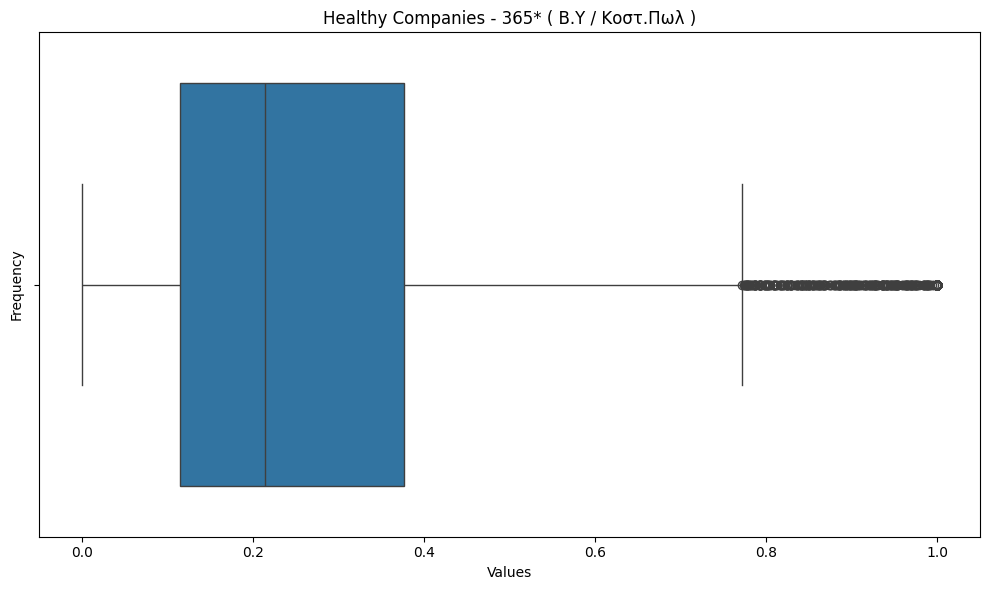

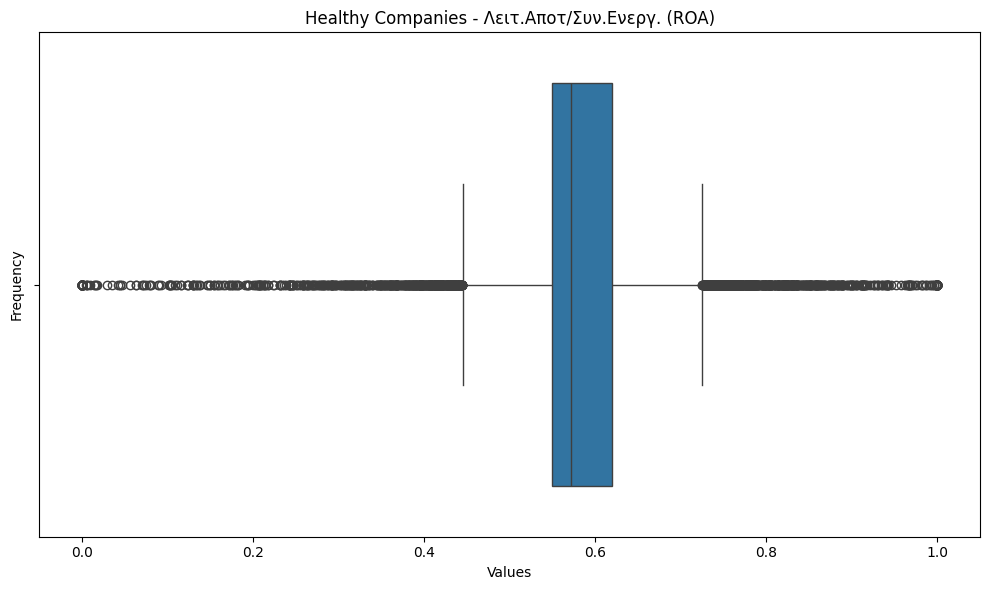

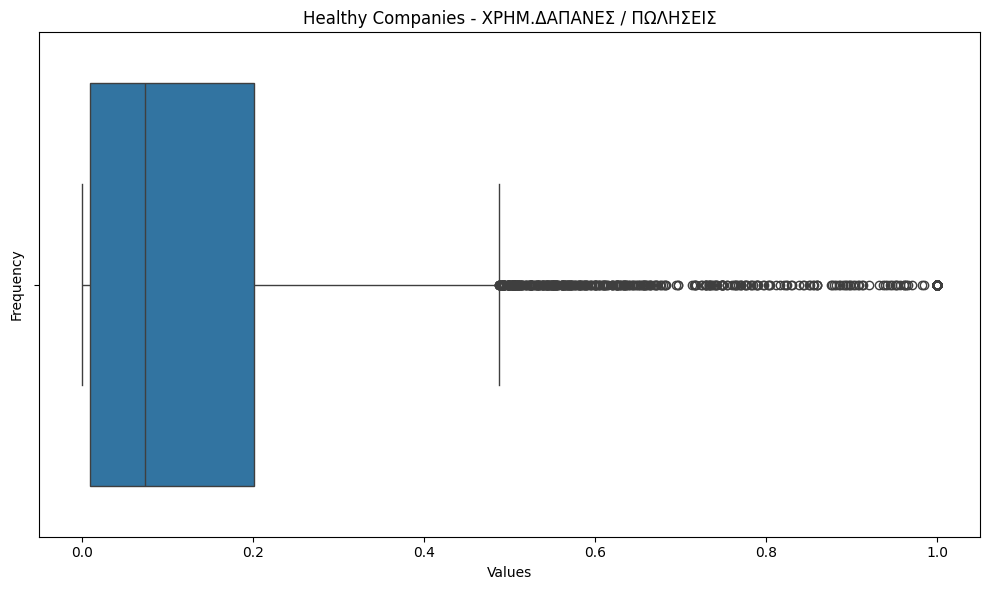

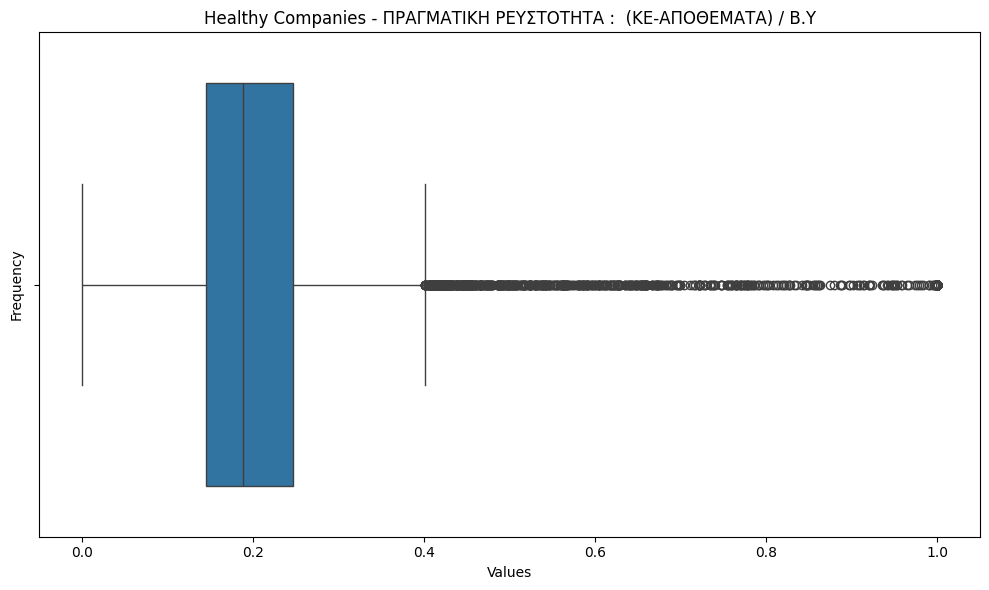

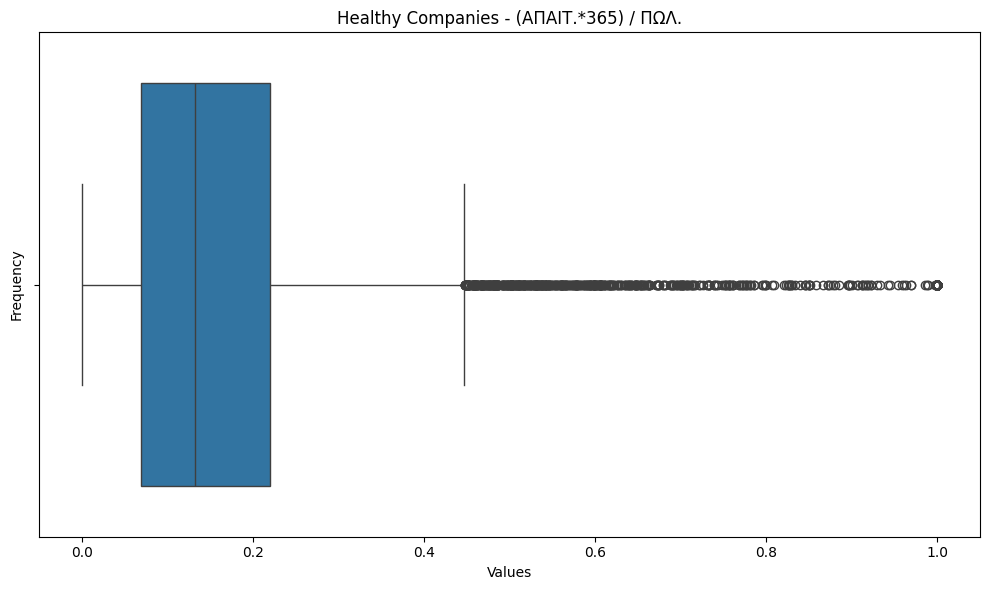

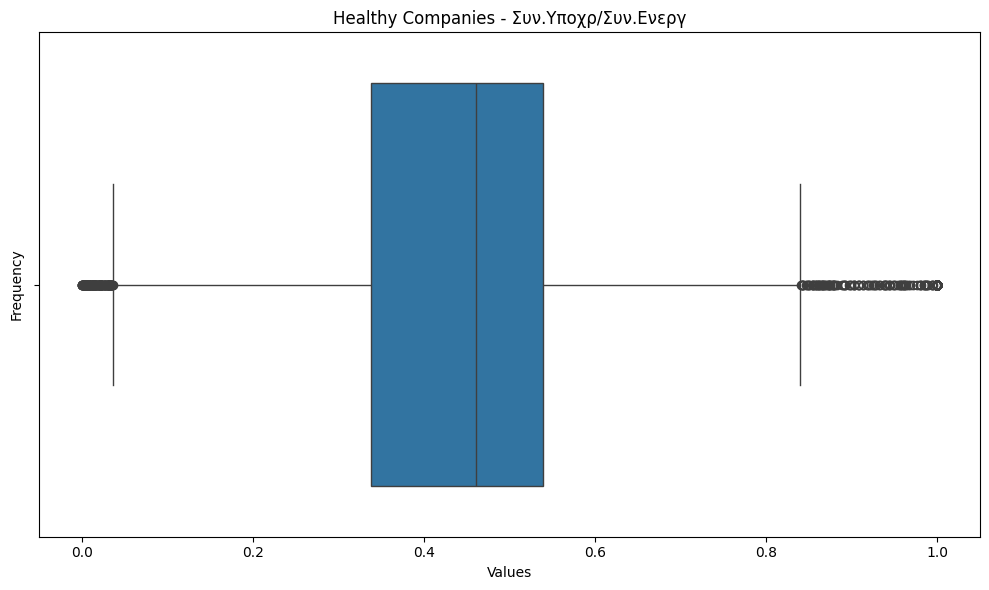

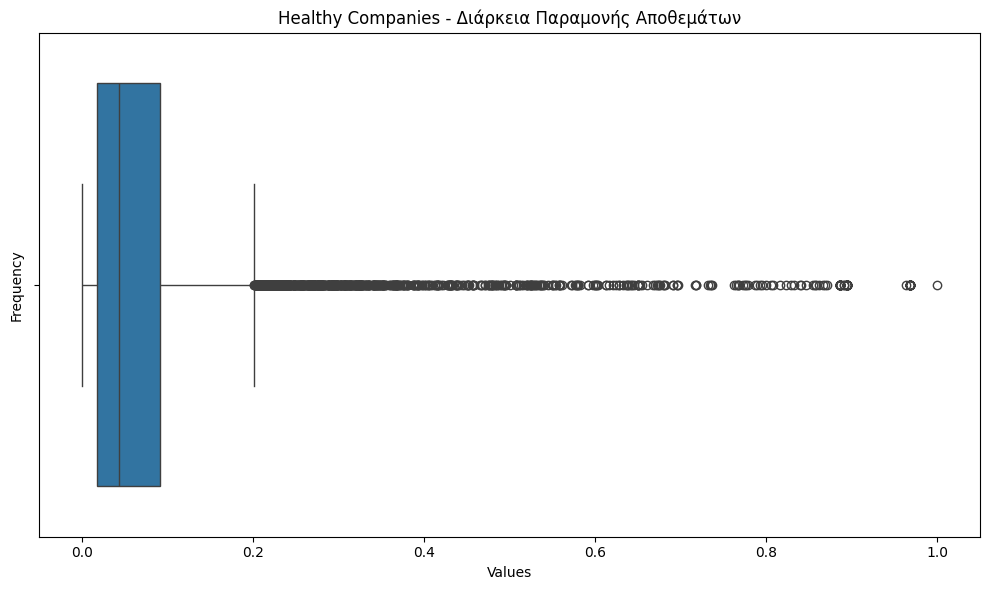

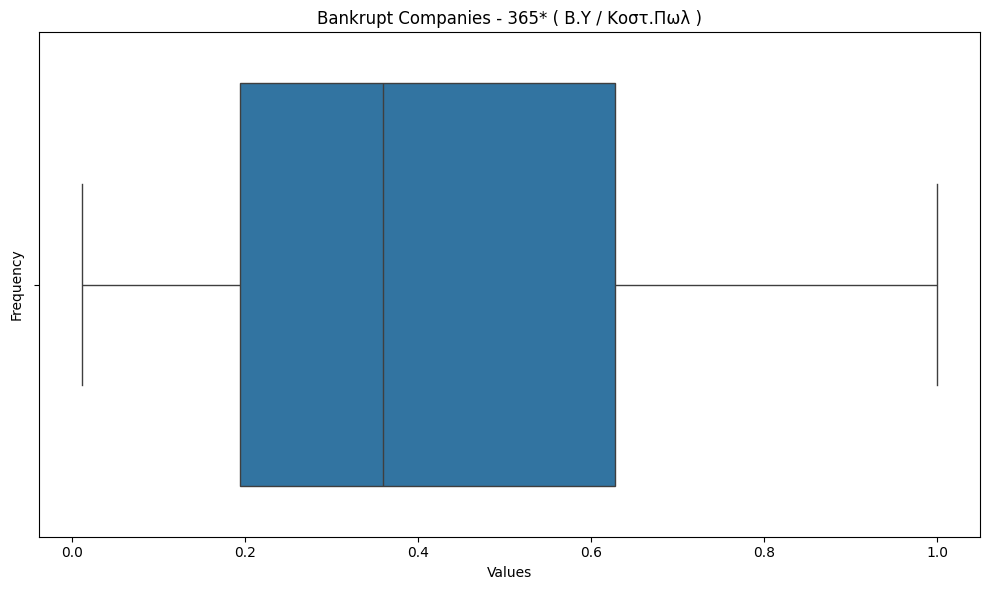

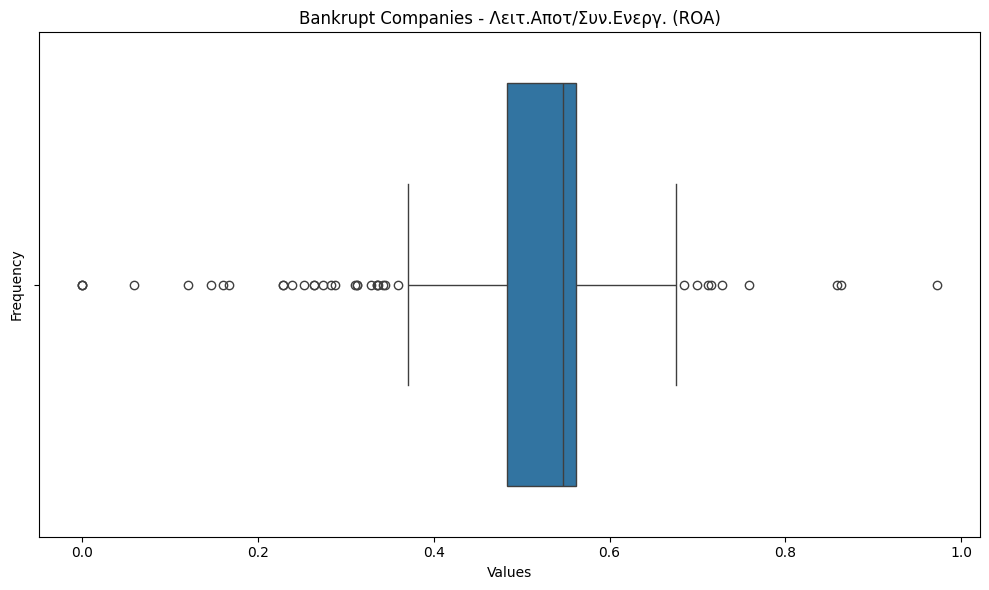

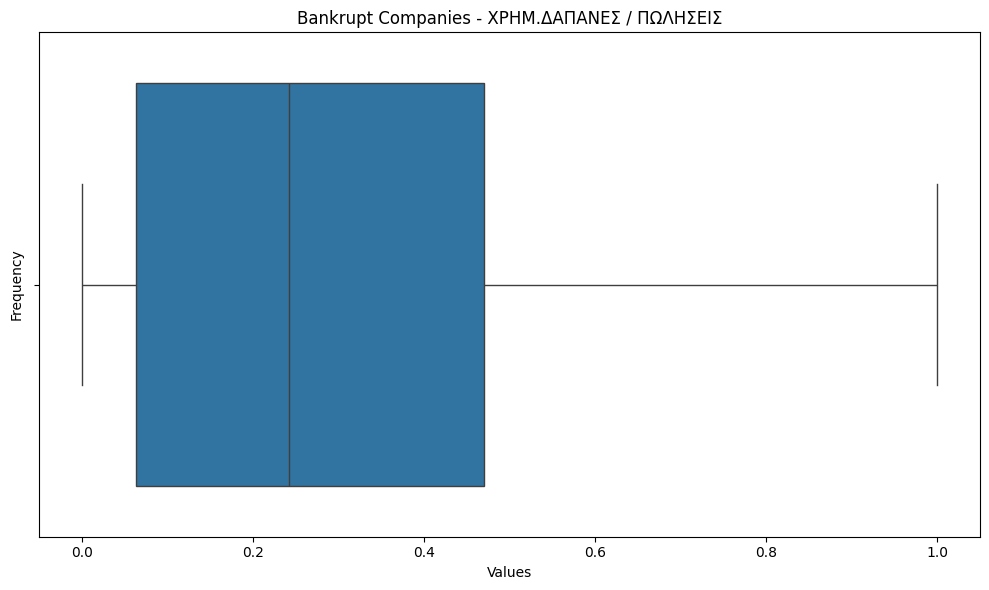

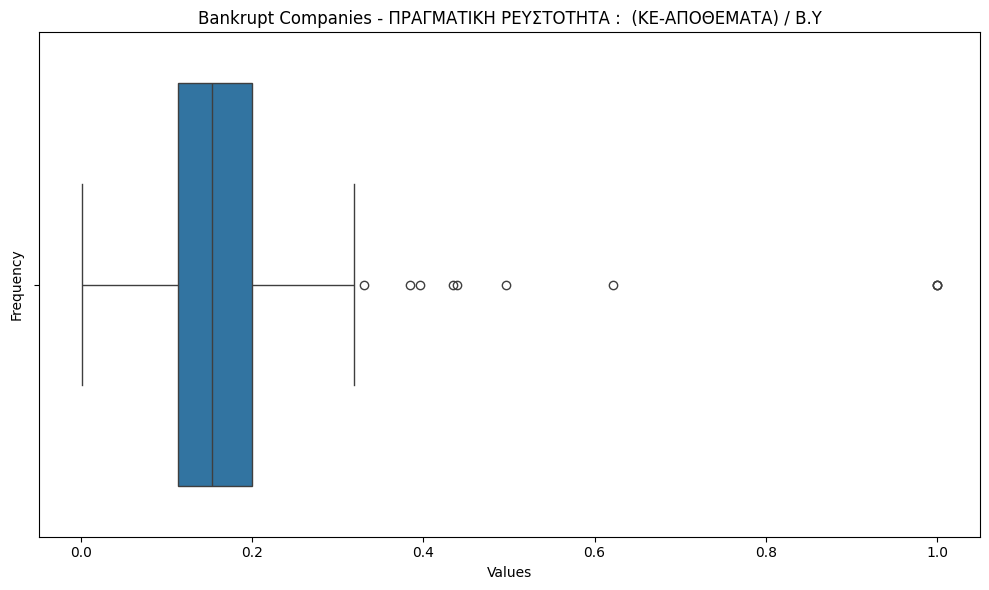

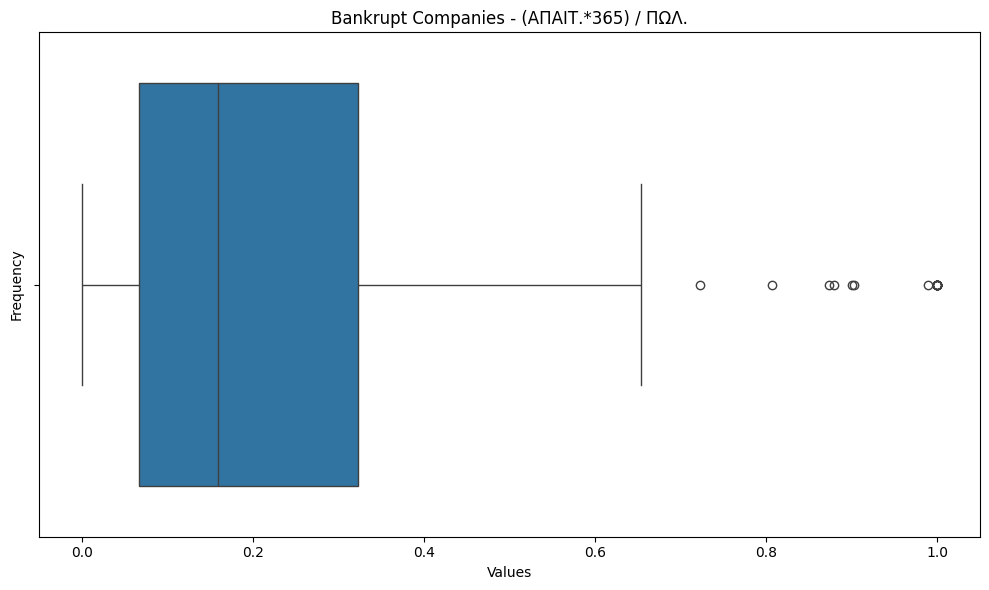

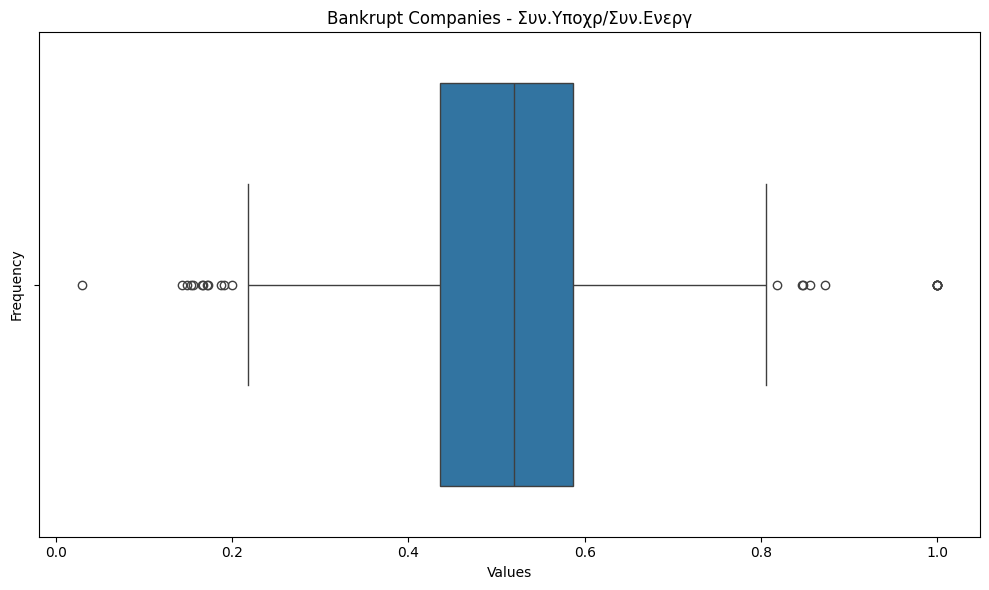

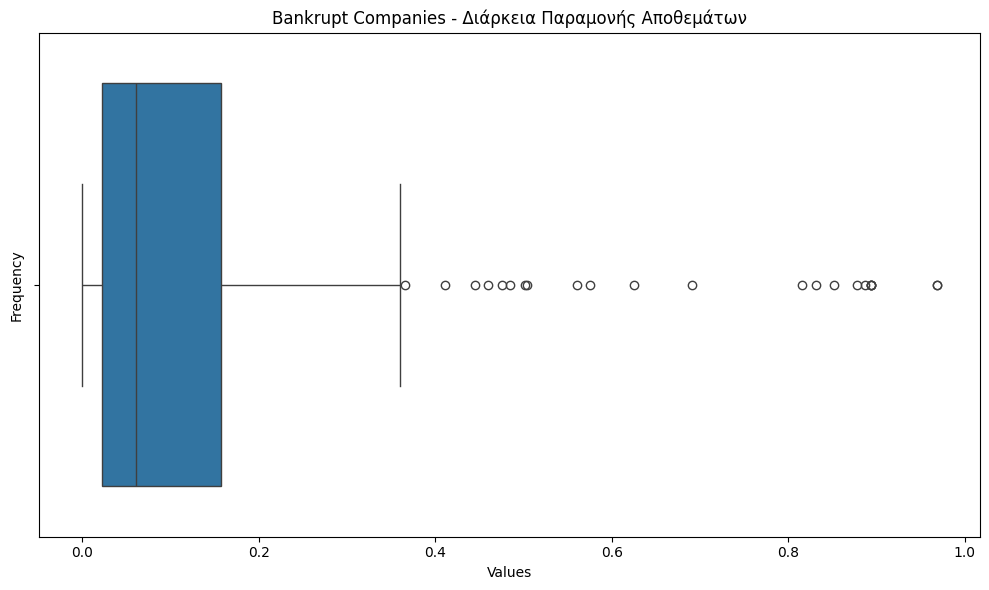

In [21]:
data_selected = data_df.iloc[:, 0:12]

healthy_data = data_df[y == 0]
bankrupt_data = data_df[y == 1]

metrics = data_selected.columns[:7]

num_metrics = len(metrics)

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=healthy_data[metric])
    plt.title(f'Healthy Companies - {metric}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=bankrupt_data[metric])
    plt.title(f'Bankrupt Companies - {metric}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


Classifier: Linear Discriminant Analysis


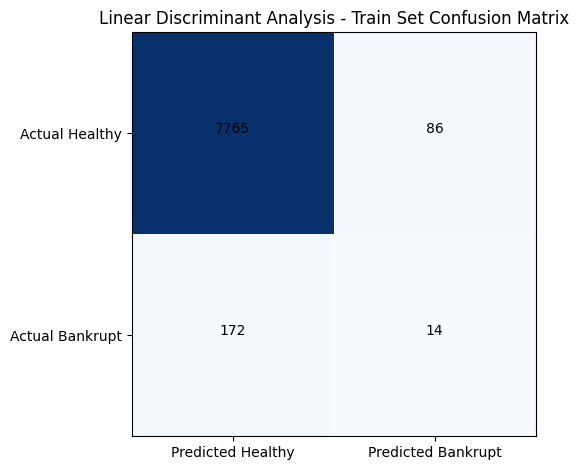

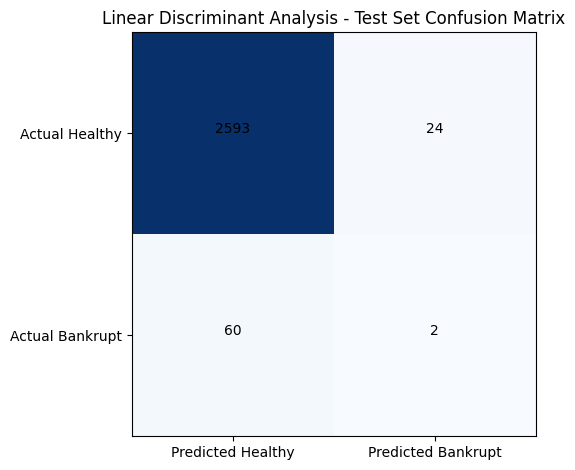

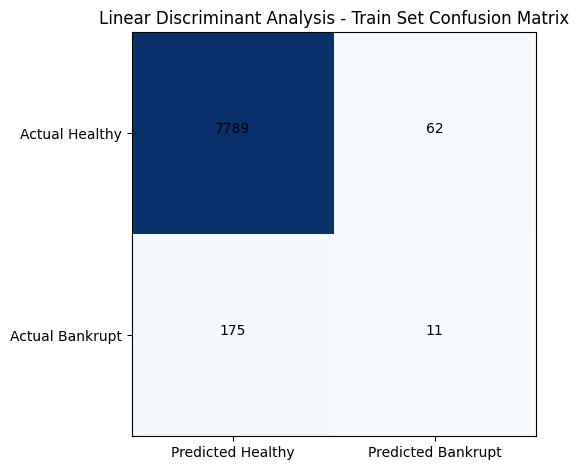

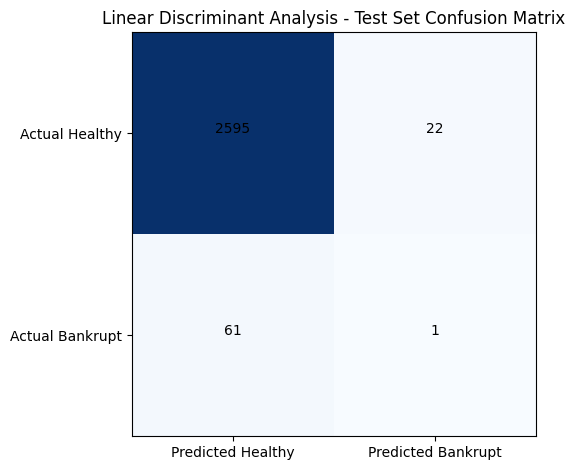

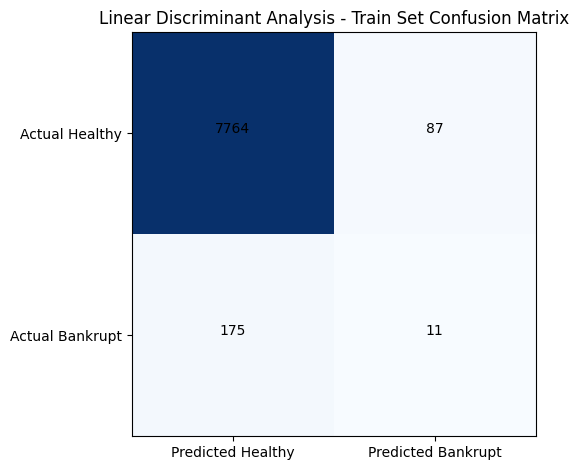

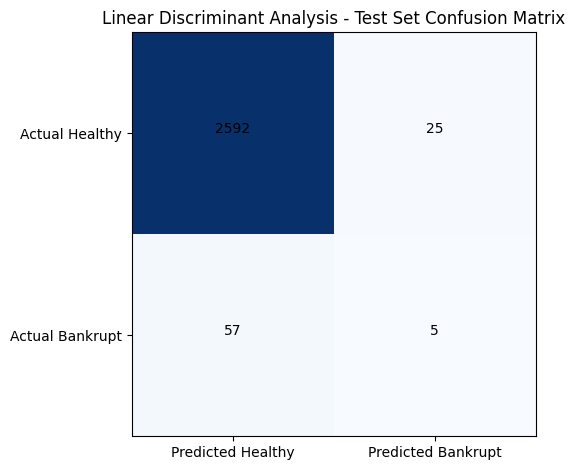

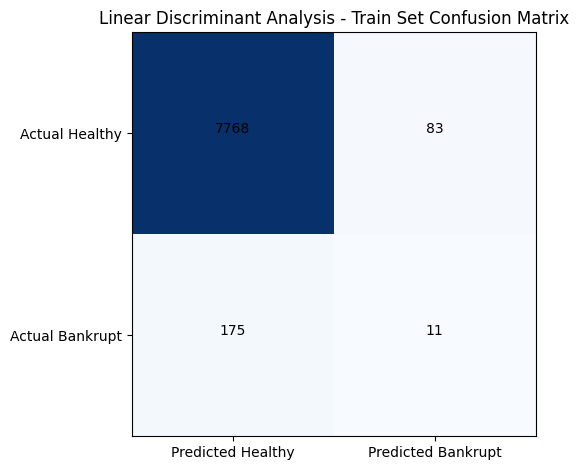

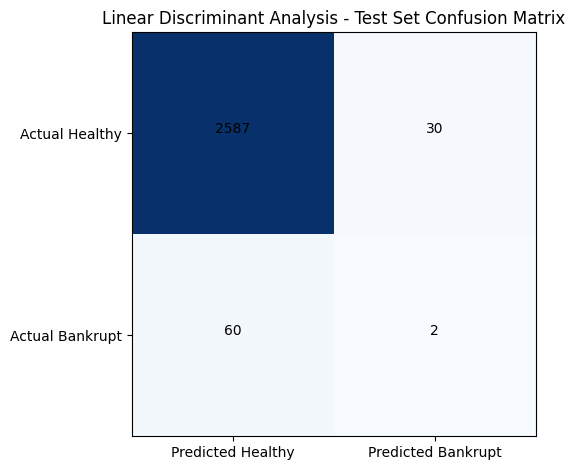


Linear Discriminant Analysis - Train Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.05

Linear Discriminant Analysis - Test Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.06

Linear Discriminant Analysis - Train Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.04

Linear Discriminant Analysis - Test Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.10

Linear Discriminant Analysis - Train Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.07

Linear Discriminant Analysis - Test Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.00

Linear Discriminant Analysis - Train Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.05

Linear Discriminant Analysis - Test Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.05
Classifier: Linear Discriminant Analysis_lsqr_auto


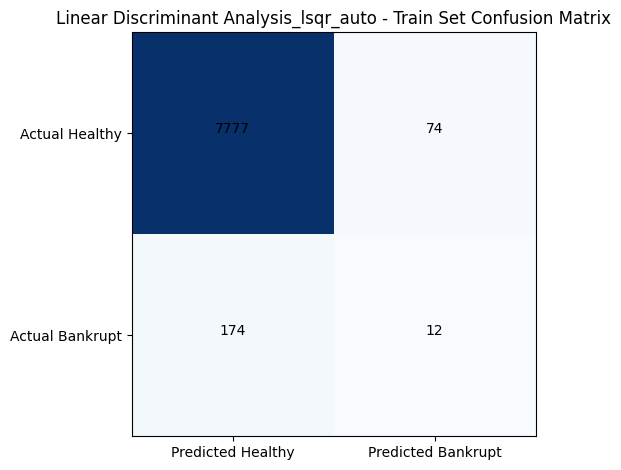

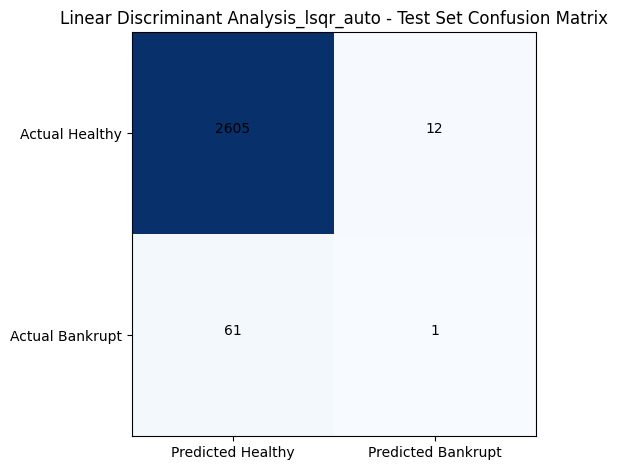

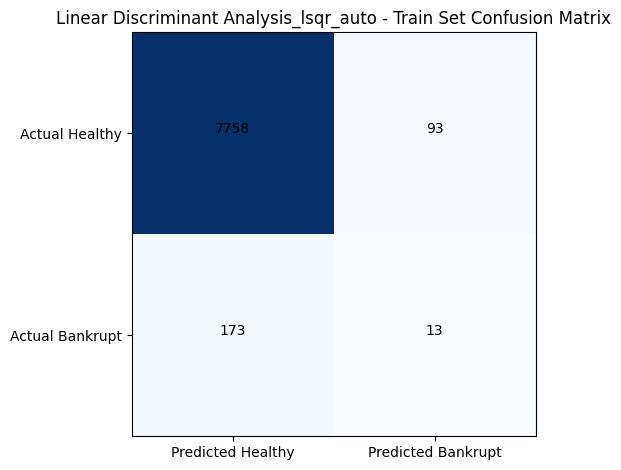

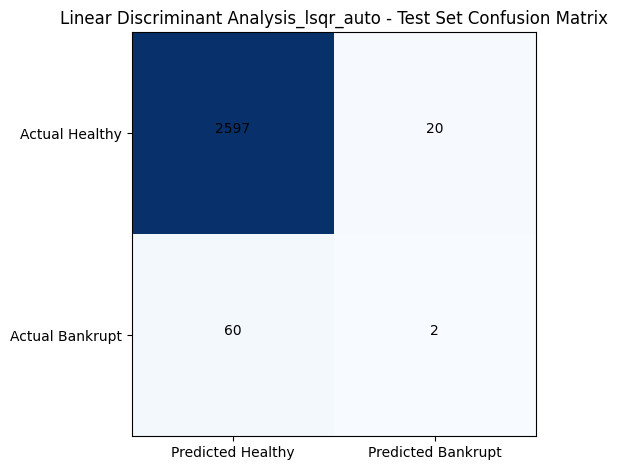

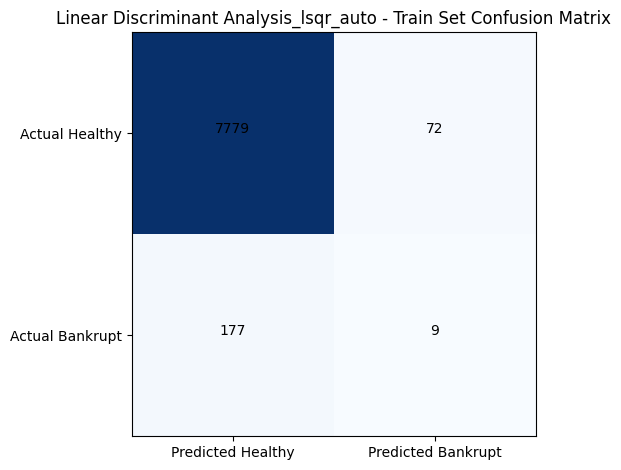

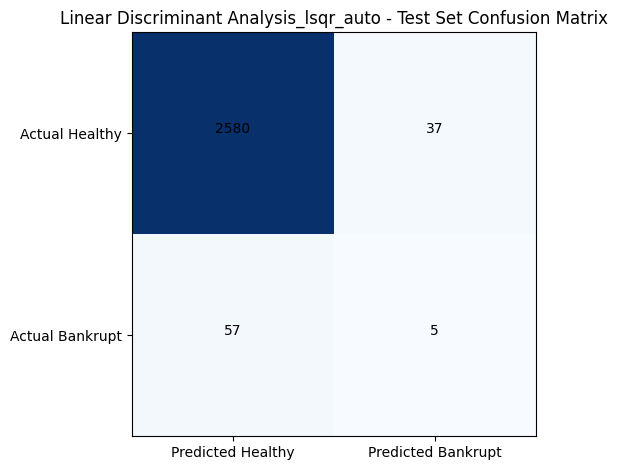

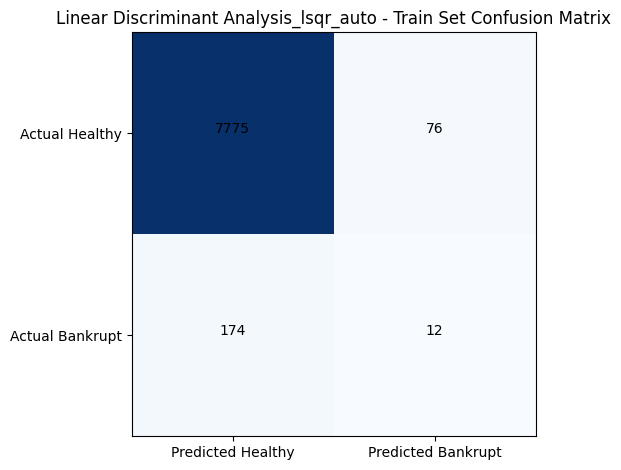

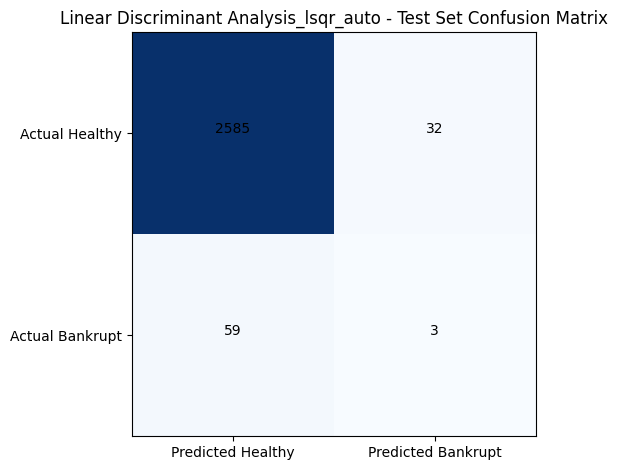


Linear Discriminant Analysis_lsqr_auto - Train Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.06

Linear Discriminant Analysis_lsqr_auto - Test Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.05

Linear Discriminant Analysis_lsqr_auto - Train Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.06

Linear Discriminant Analysis_lsqr_auto - Test Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.05

Linear Discriminant Analysis_lsqr_auto - Train Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.06

Linear Discriminant Analysis_lsqr_auto - Test Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.06

Linear Discriminant Analysis_lsqr_auto - Train Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.05

Linear Discriminant Analysis_lsqr_auto - Test Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.08
Classifier: Logistic Regression_max_iter_1000


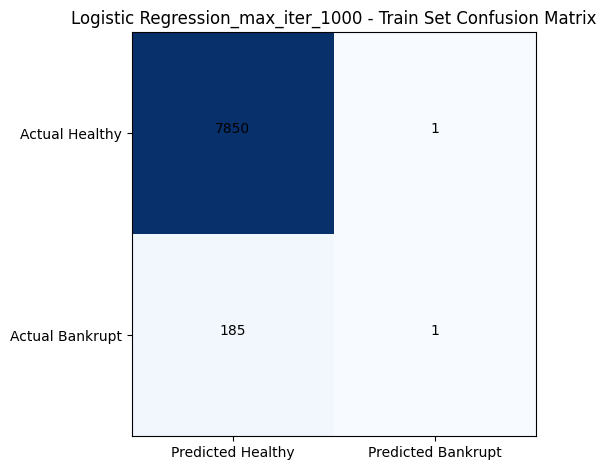

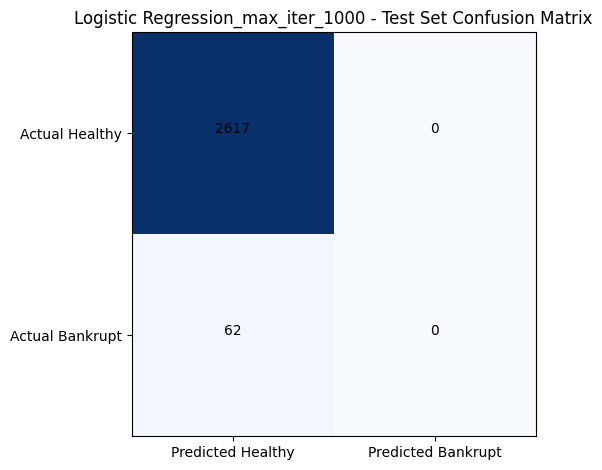

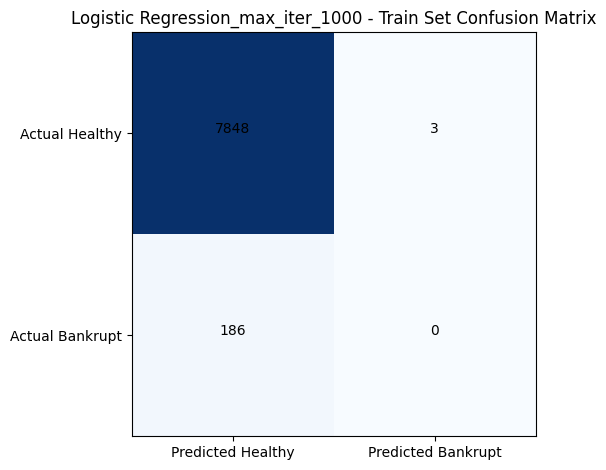

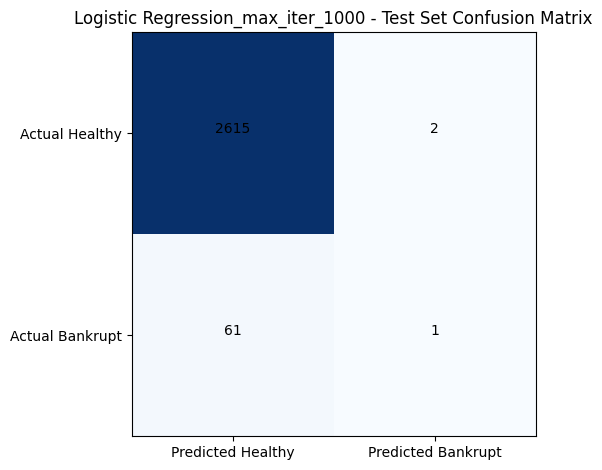

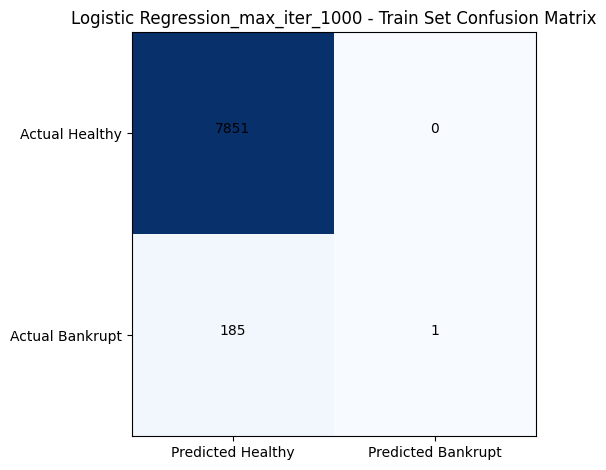

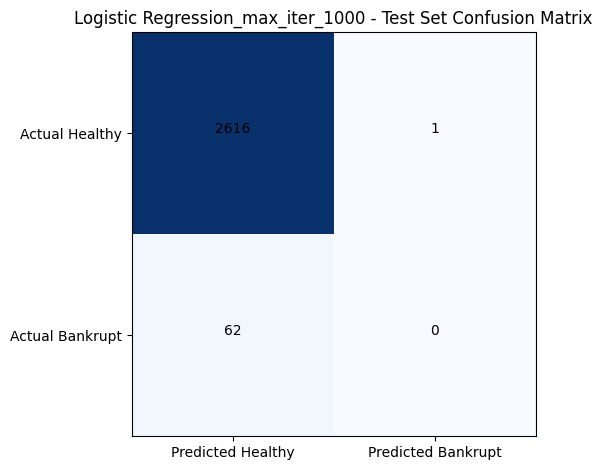

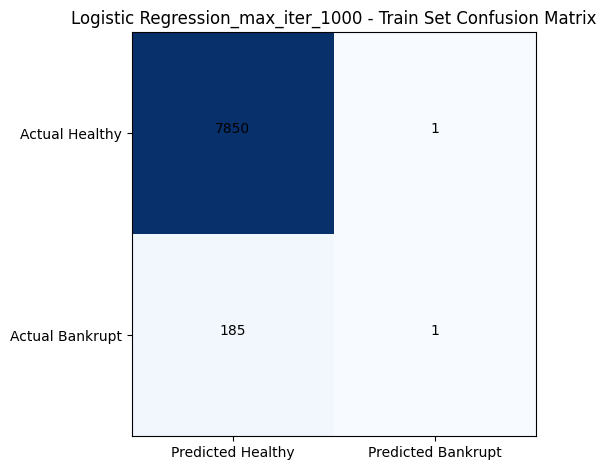

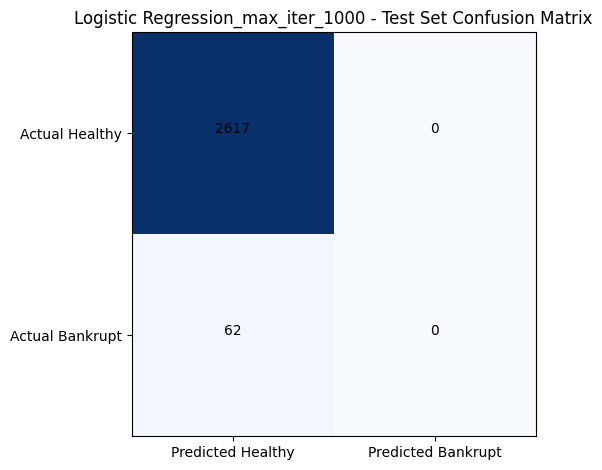


Logistic Regression_max_iter_1000 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1000 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1000 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1000 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1000 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1000 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1000 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1000 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.02
Classifier: Logistic Regression_max_iter_500


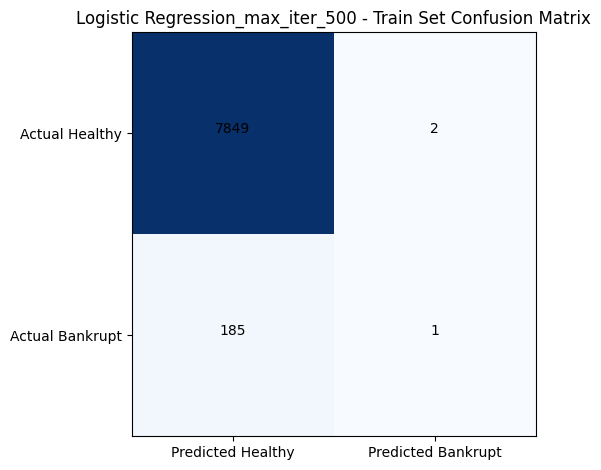

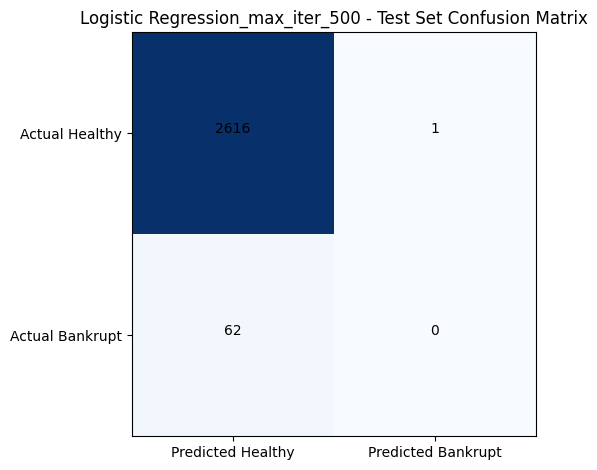

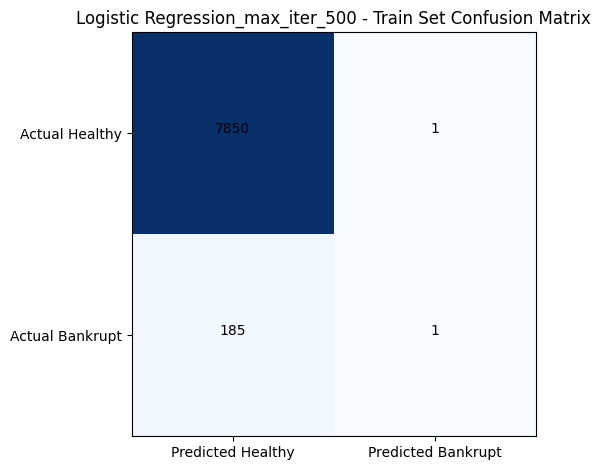

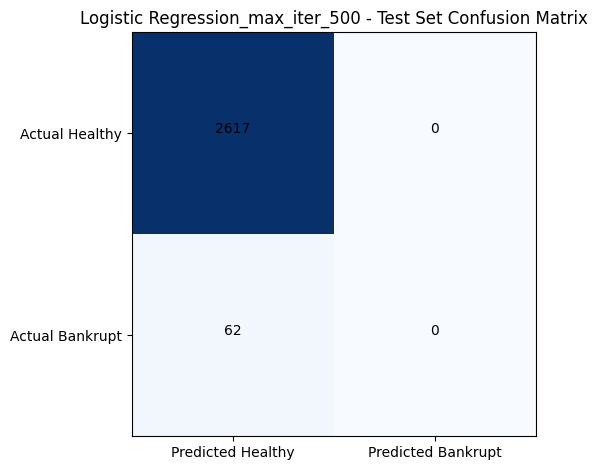

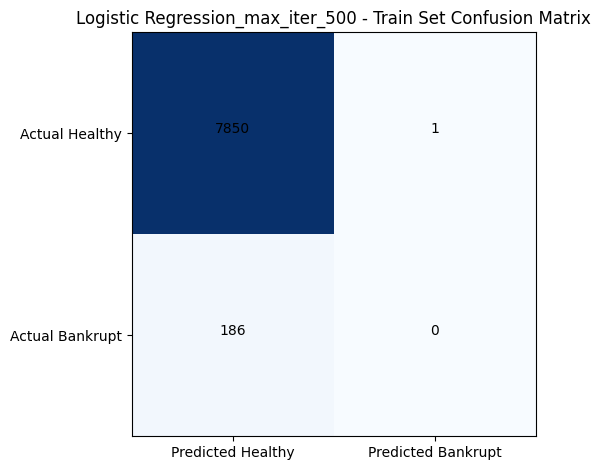

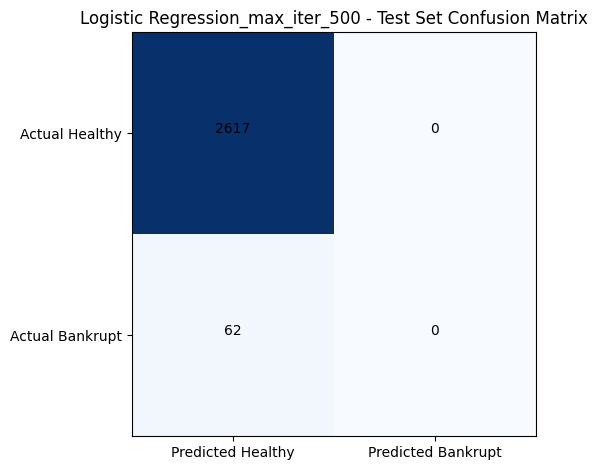

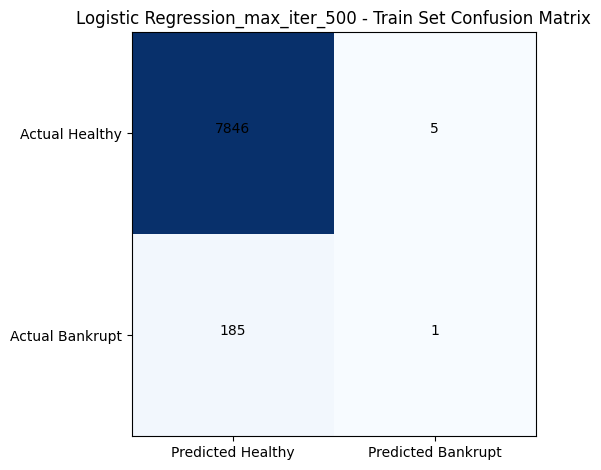

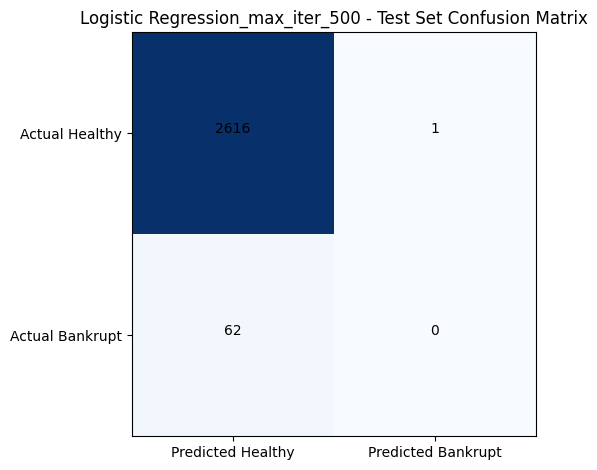


Logistic Regression_max_iter_500 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_500 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_500 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_500 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_500 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_500 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_500 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_500 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.02
Classifier: Logistic Regression_max_iter_1500_liblinear


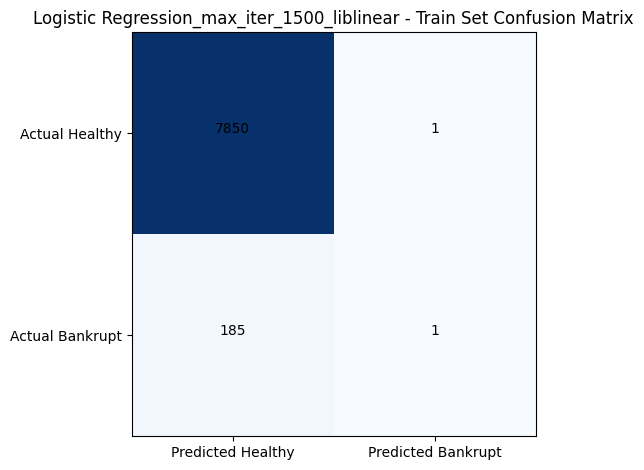

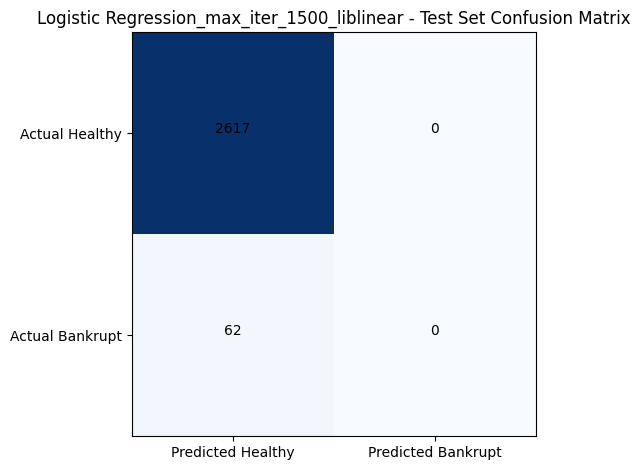

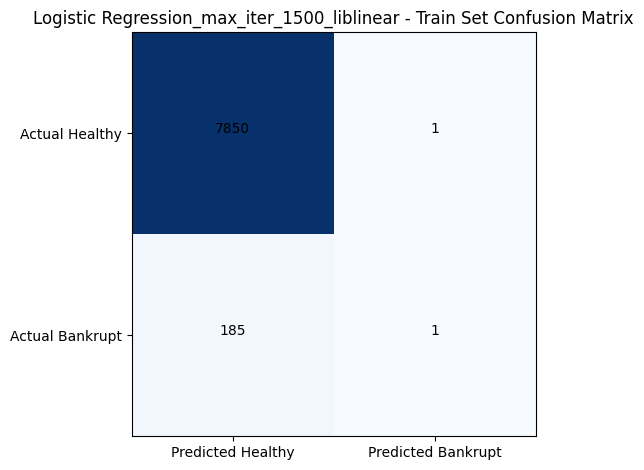

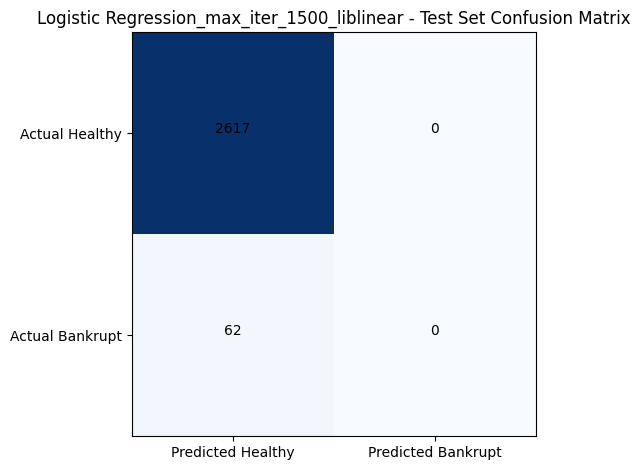

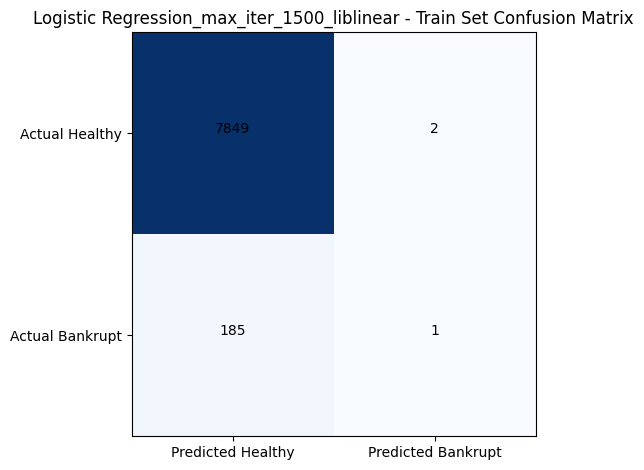

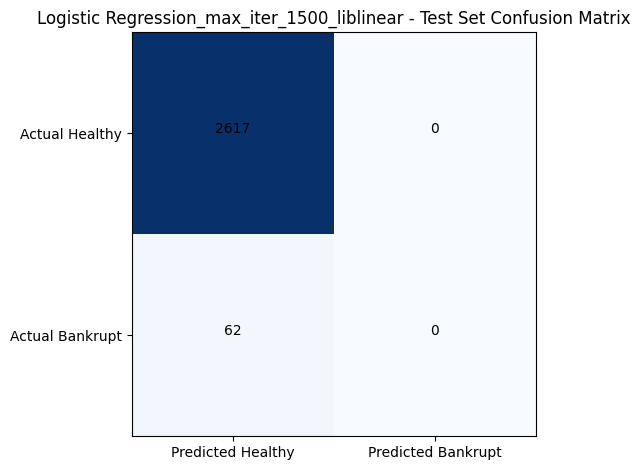

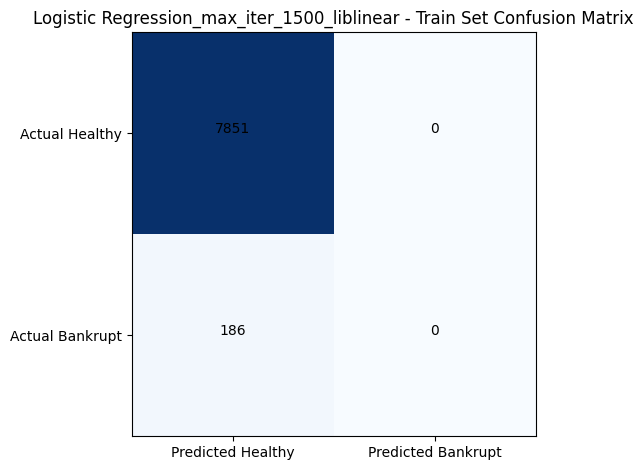

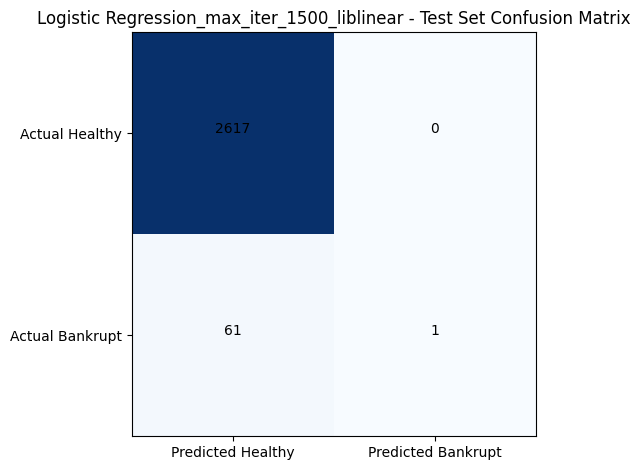


Logistic Regression_max_iter_1500_liblinear - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1500_liblinear - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.02

Logistic Regression_max_iter_1500_liblinear - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1500_liblinear - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1500_liblinear - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1500_liblinear - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Logistic Regression_max_iter_1500_liblinear - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Logistic Regression_max_iter_1500_liblinear - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Decision Tree_ma

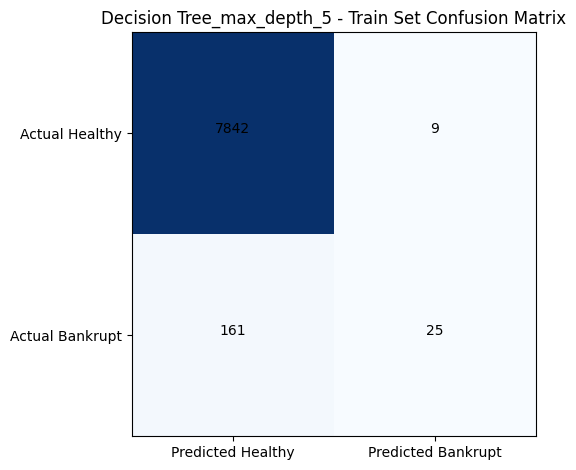

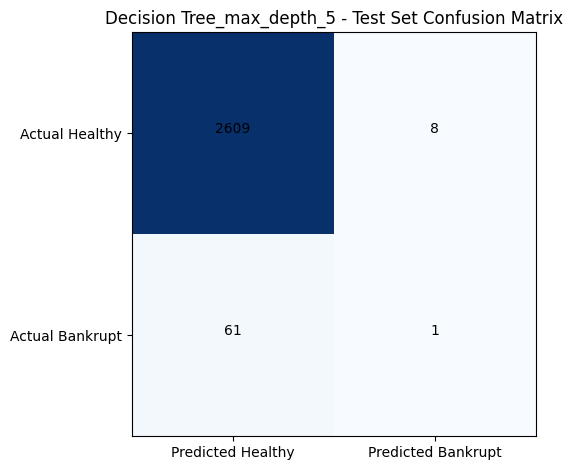

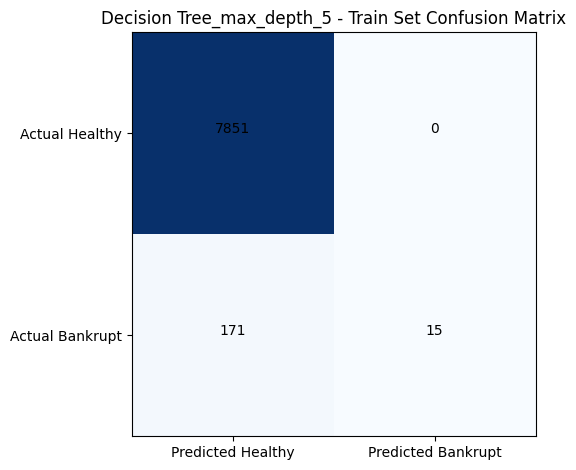

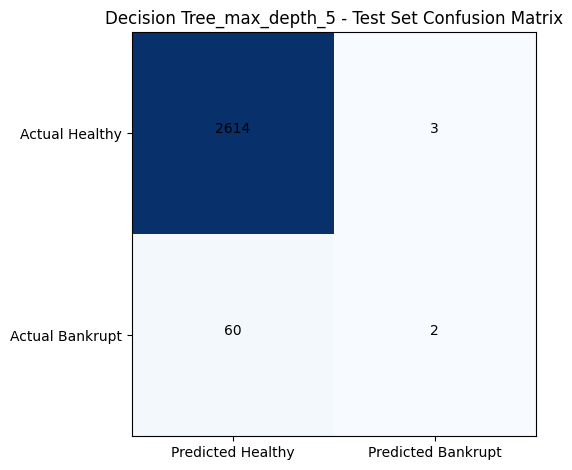

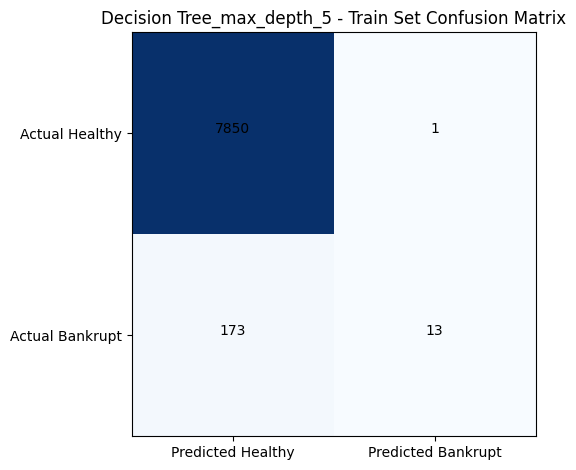

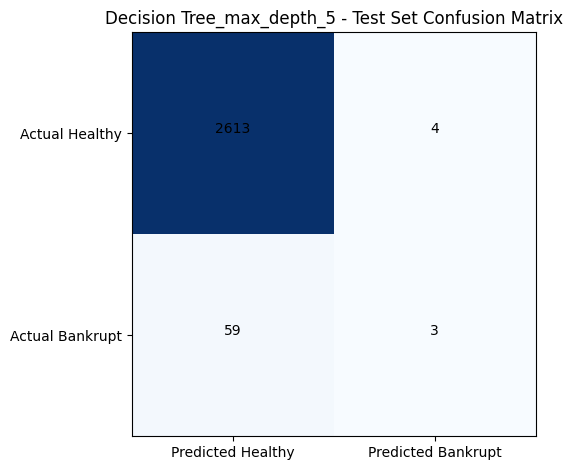

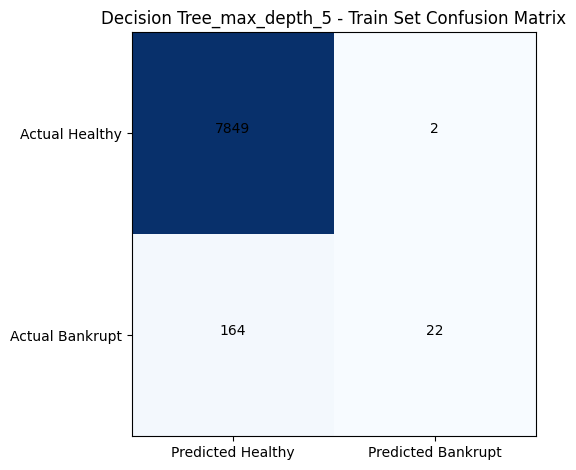

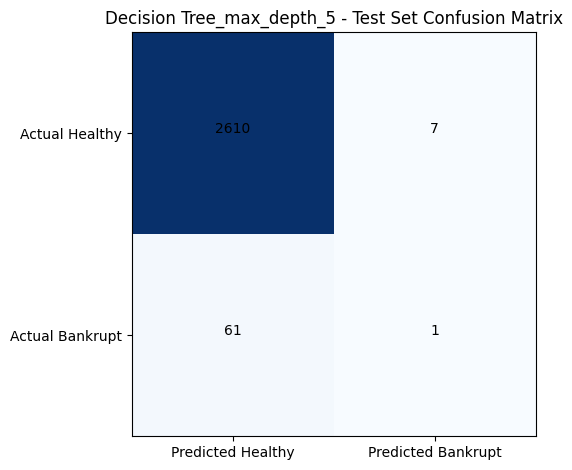


Decision Tree_max_depth_5 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.10

Decision Tree_max_depth_5 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.06

Decision Tree_max_depth_5 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.10

Decision Tree_max_depth_5 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.06

Decision Tree_max_depth_5 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.08

Decision Tree_max_depth_5 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.13

Decision Tree_max_depth_5 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.09

Decision Tree_max_depth_5 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.11
Classifier: Decision Tree_max_depth_10


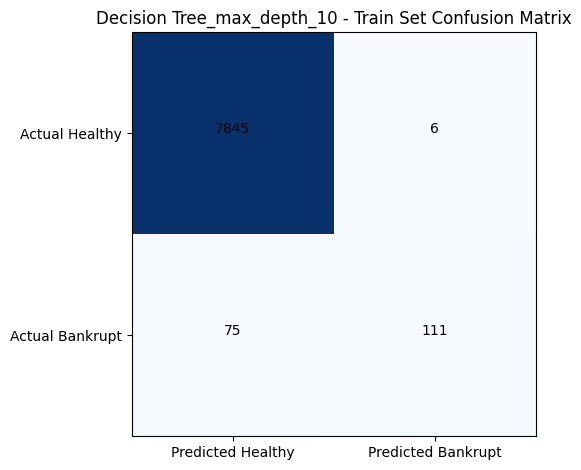

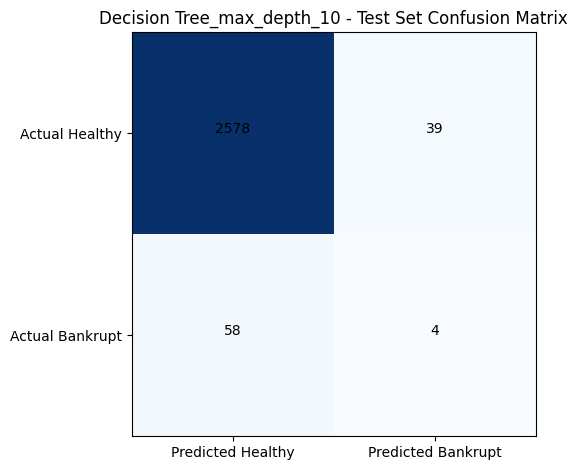

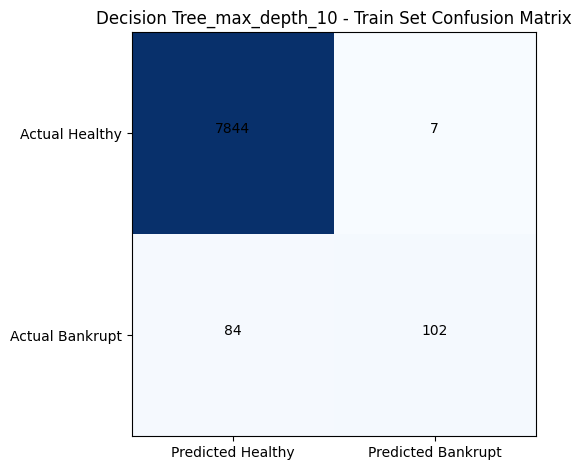

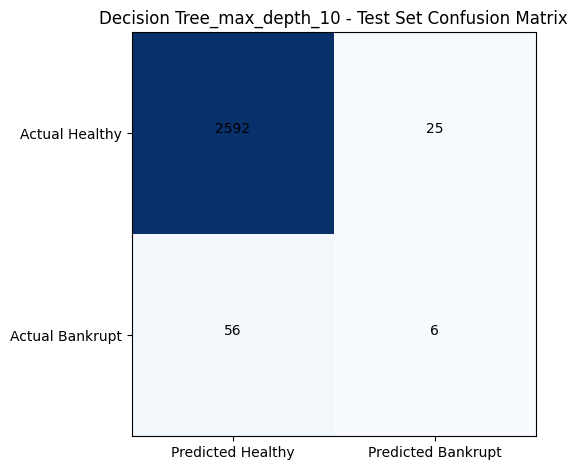

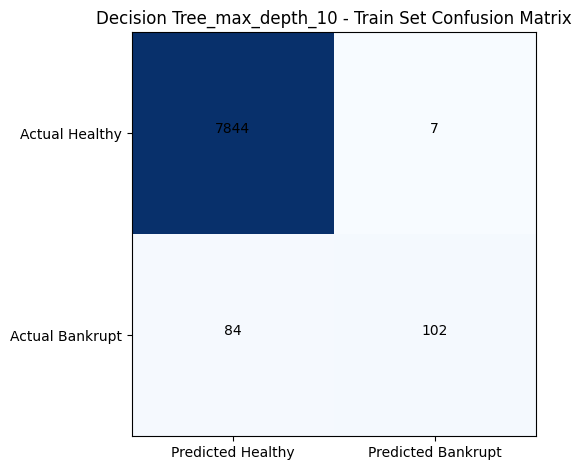

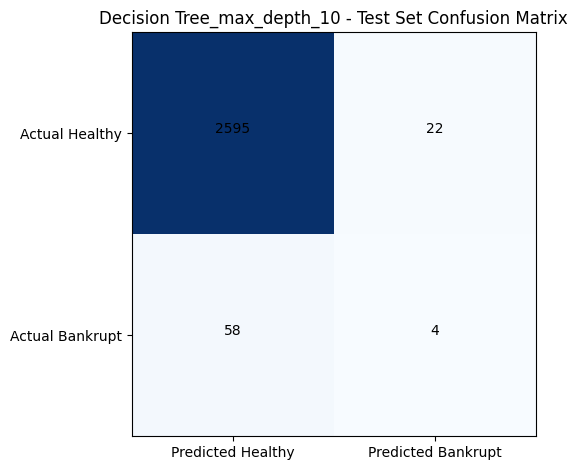

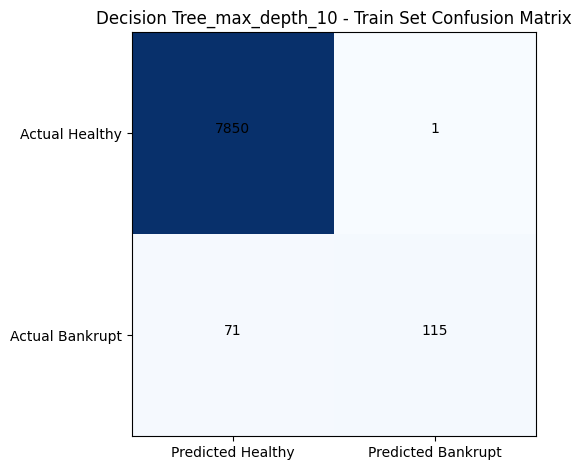

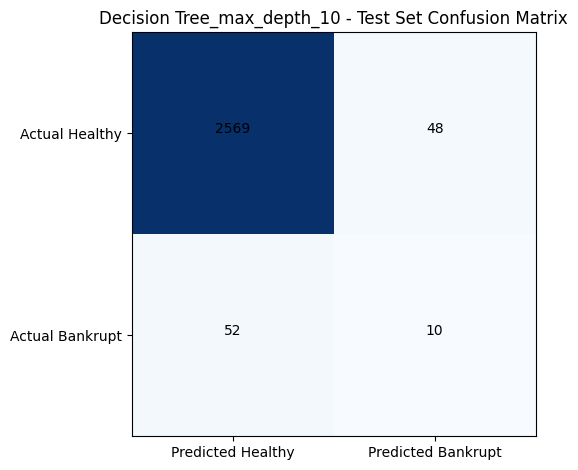


Decision Tree_max_depth_10 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.51

Decision Tree_max_depth_10 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.48

Decision Tree_max_depth_10 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.51

Decision Tree_max_depth_10 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.50

Decision Tree_max_depth_10 - Train Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.51

Decision Tree_max_depth_10 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.48

Decision Tree_max_depth_10 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.49

Decision Tree_max_depth_10 - Test Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.55
Classifier: Decision Tree_max_depth_15


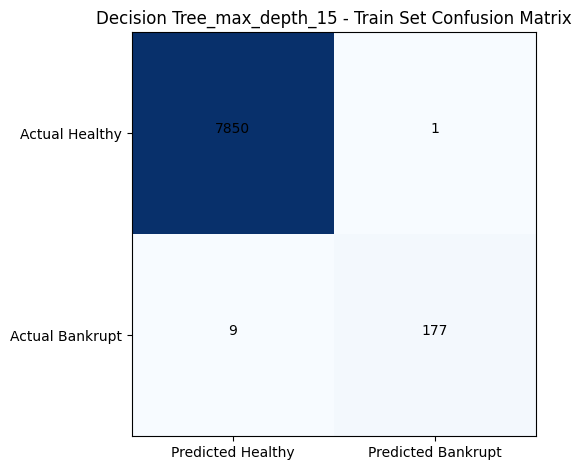

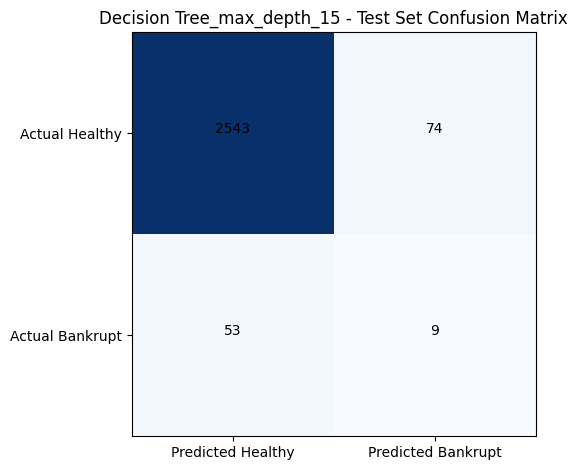

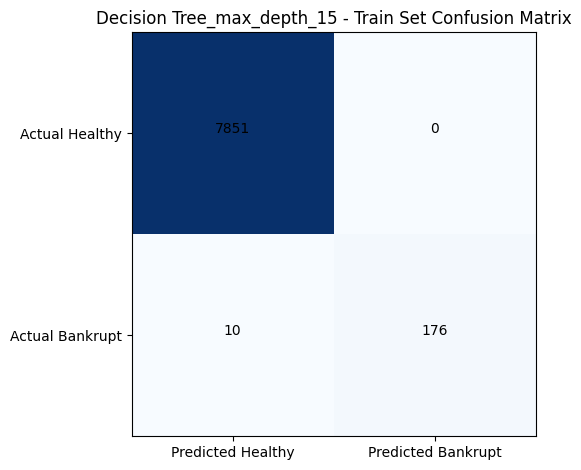

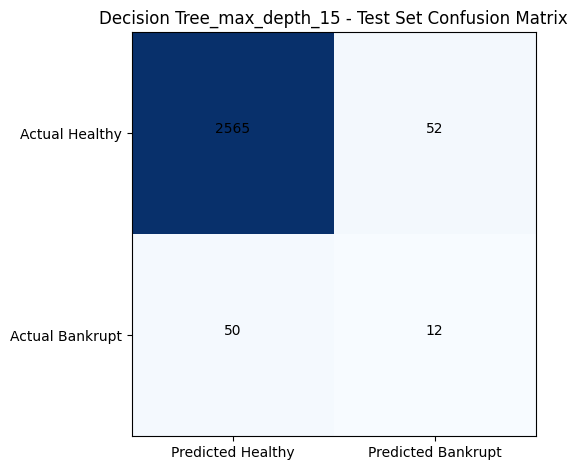

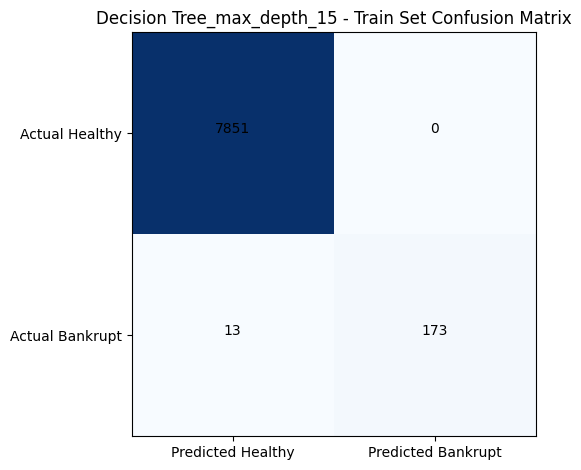

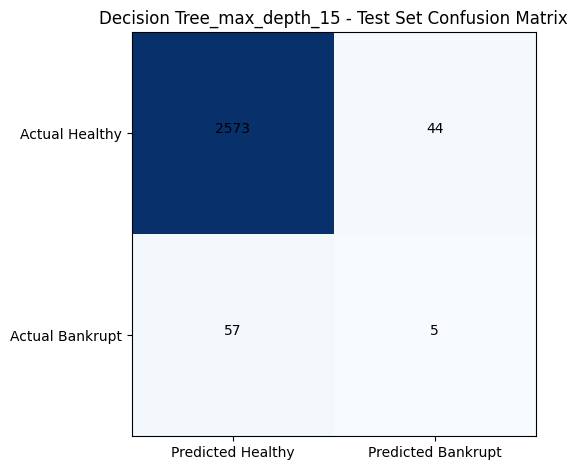

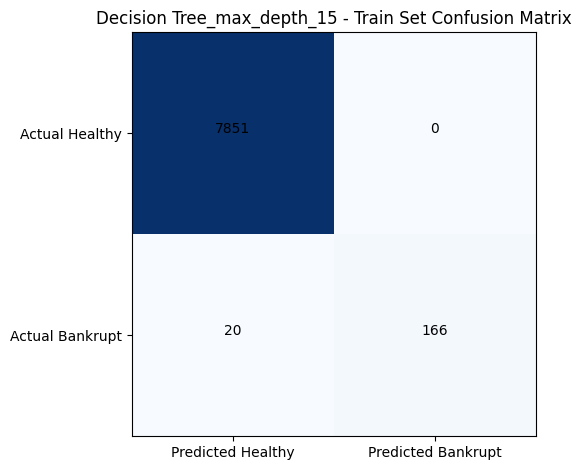

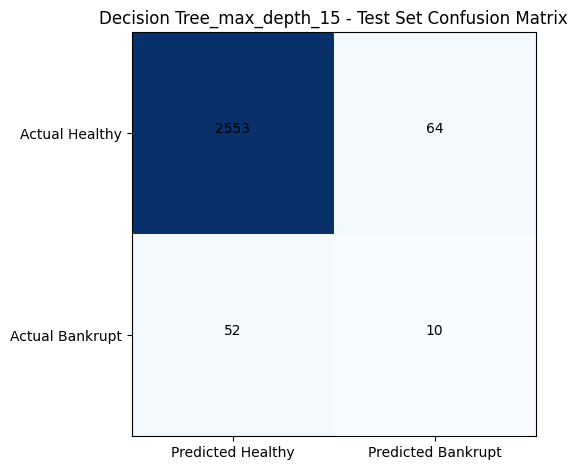


Decision Tree_max_depth_15 - Train Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.71

Decision Tree_max_depth_15 - Test Set Performance (Fold 1):
Success Rate Healthy: 0.99, Bankrupt: 0.71

Decision Tree_max_depth_15 - Train Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.72

Decision Tree_max_depth_15 - Test Set Performance (Fold 2):
Success Rate Healthy: 0.99, Bankrupt: 0.69

Decision Tree_max_depth_15 - Train Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.69

Decision Tree_max_depth_15 - Test Set Performance (Fold 3):
Success Rate Healthy: 0.99, Bankrupt: 0.76

Decision Tree_max_depth_15 - Train Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.72

Decision Tree_max_depth_15 - Test Set Performance (Fold 4):
Success Rate Healthy: 0.99, Bankrupt: 0.68
Classifier: Random Forest_n_estimators_100_max_depth_5


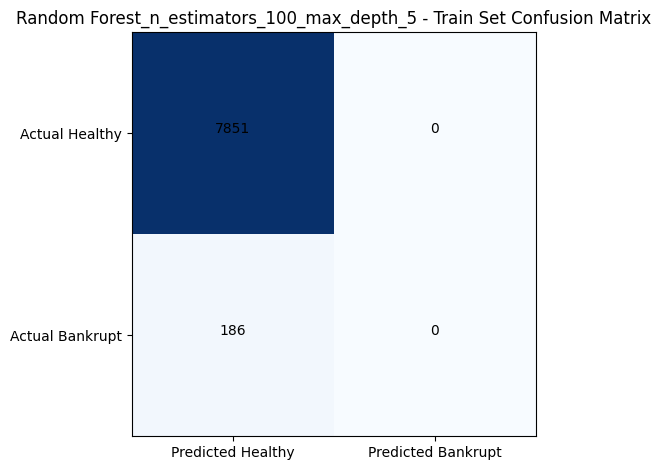

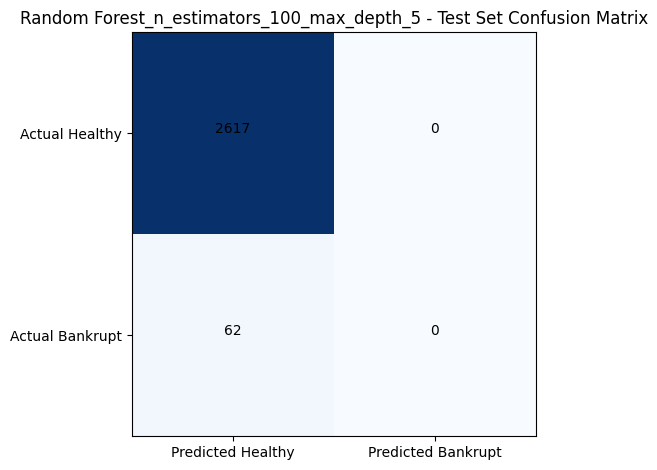

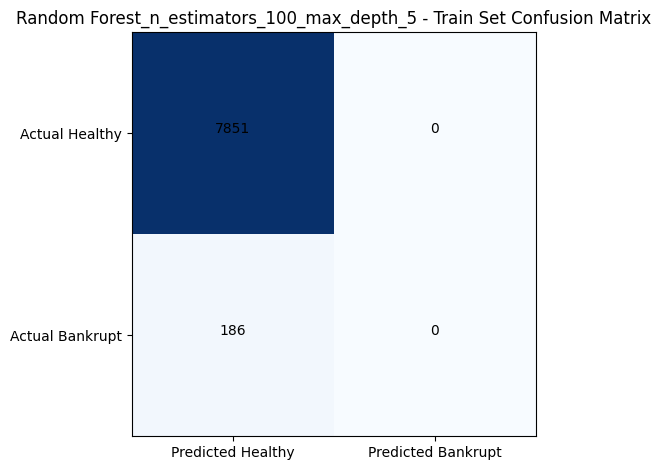

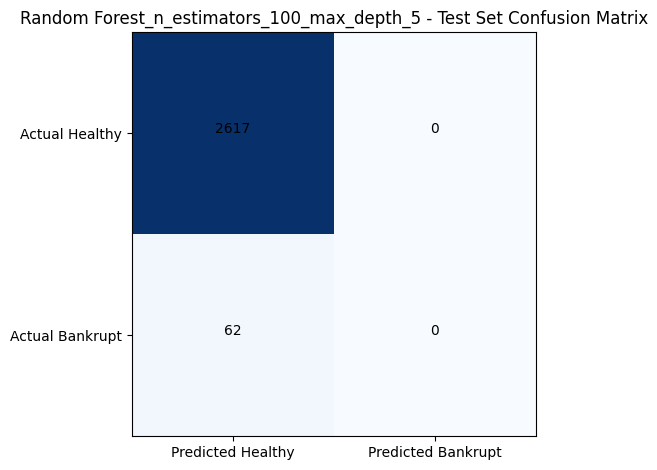

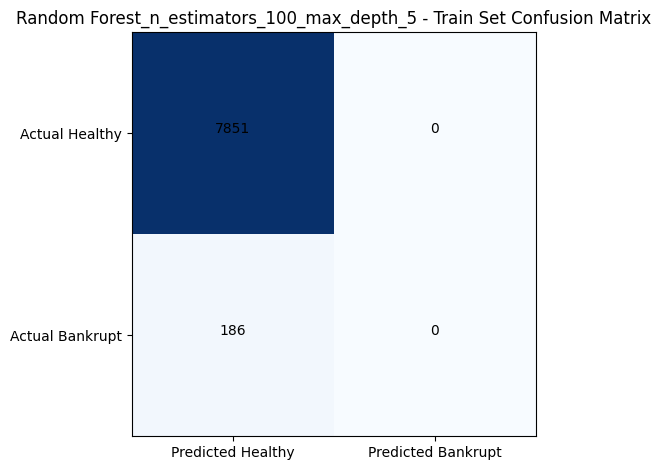

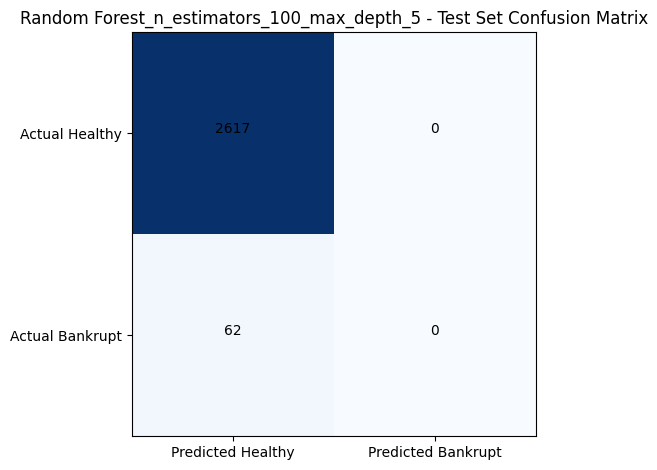

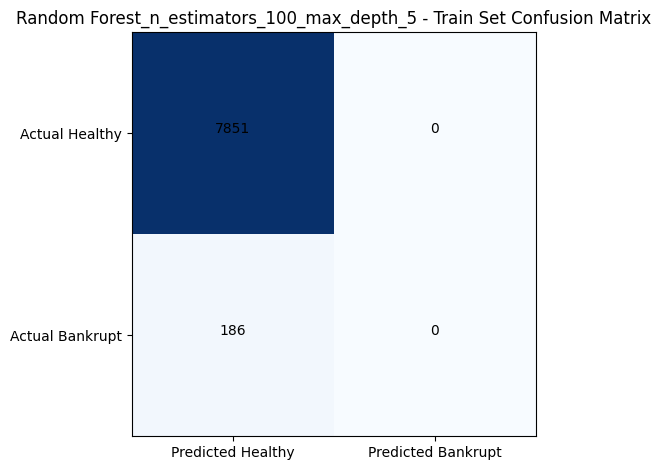

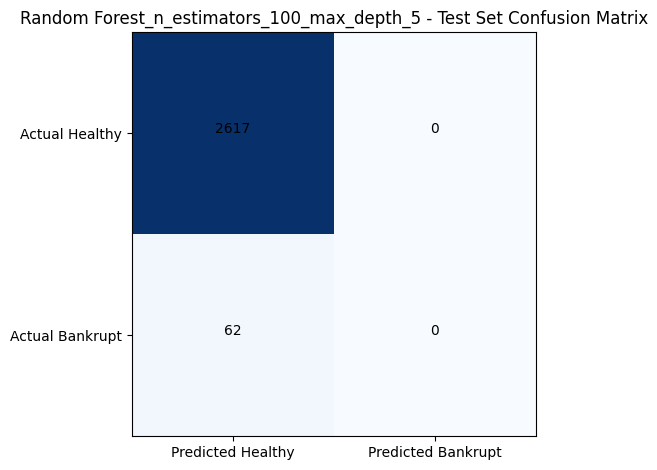


Random Forest_n_estimators_100_max_depth_5 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Random Forest_n_estimators_100_max_depth_5 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Random Forest_n_estimato

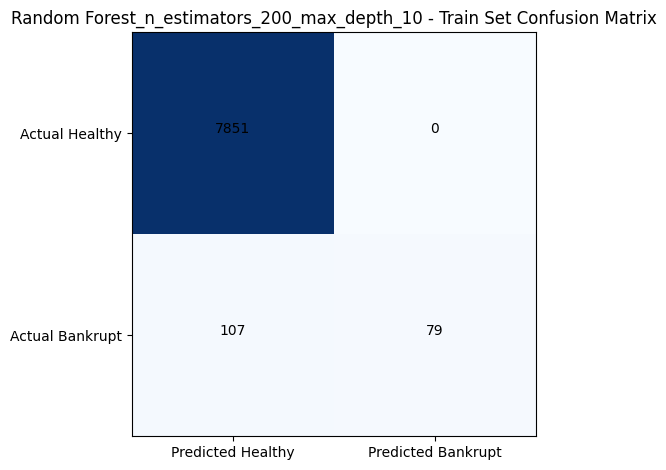

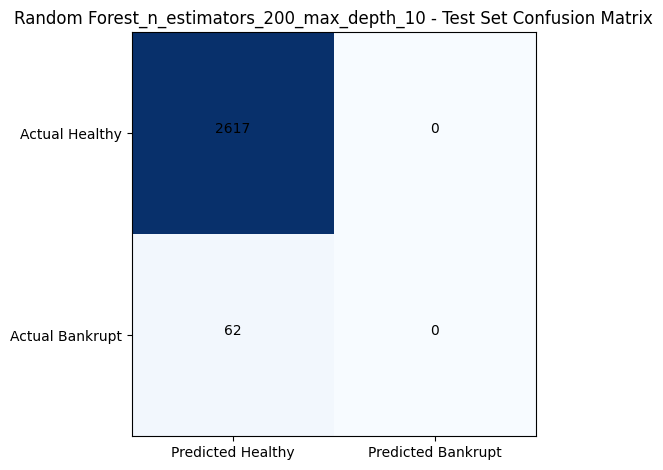

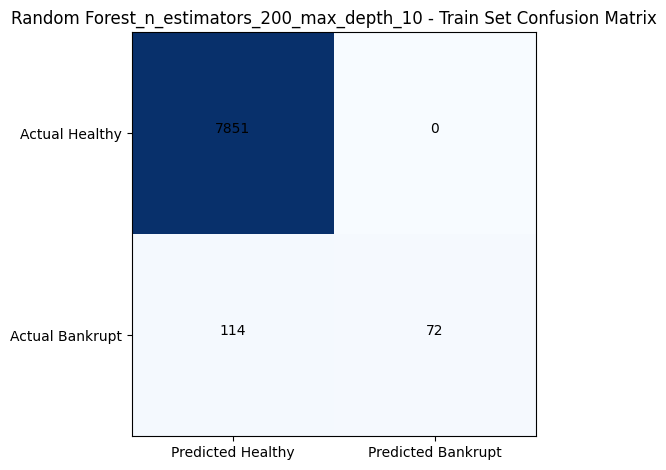

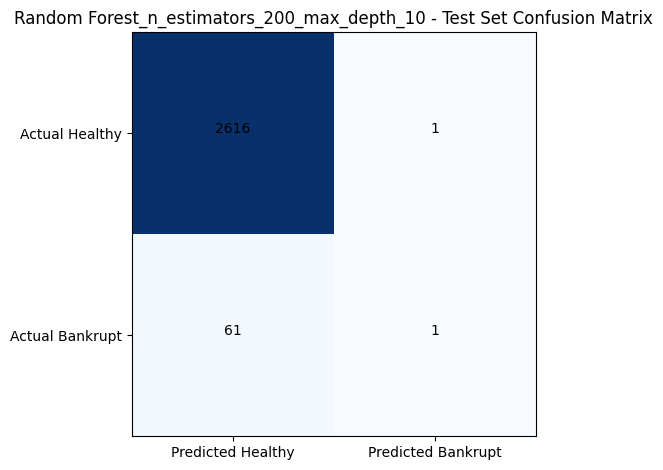

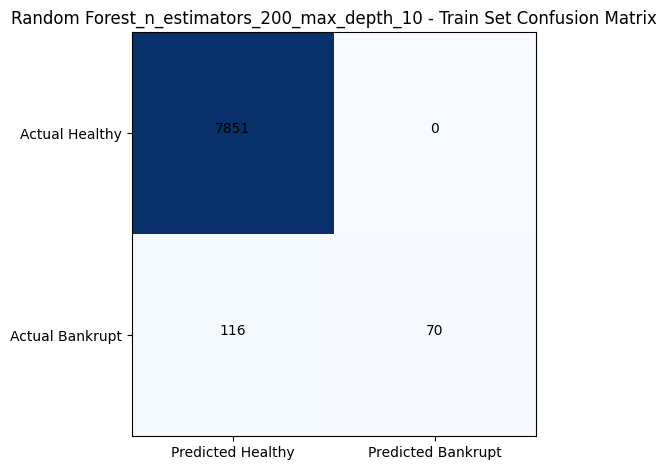

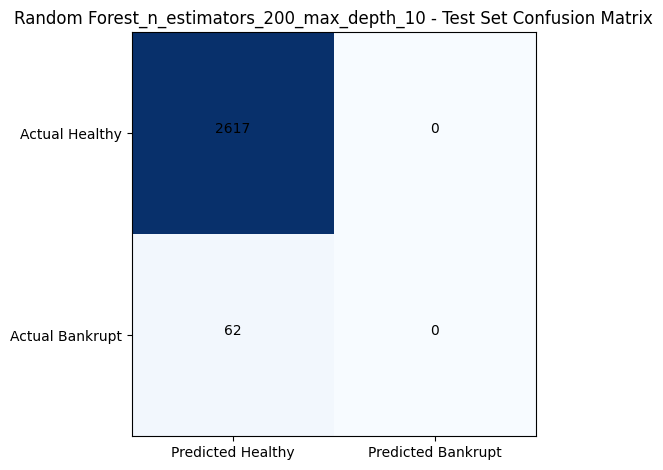

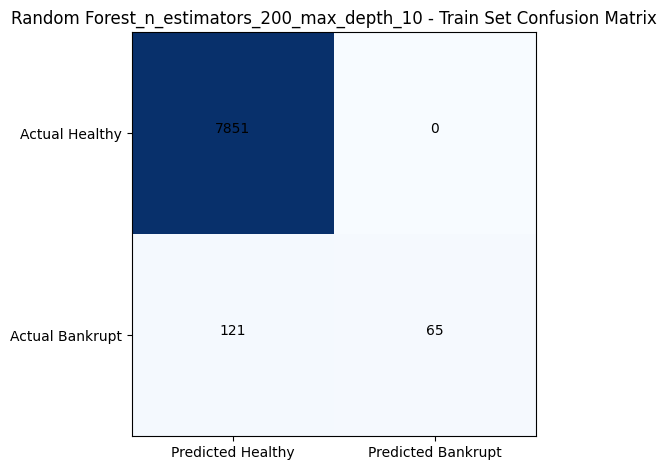

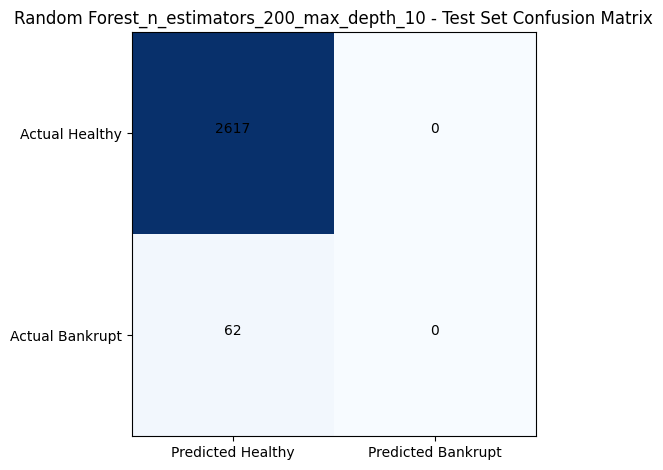


Random Forest_n_estimators_200_max_depth_10 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.28

Random Forest_n_estimators_200_max_depth_10 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Random Forest_n_estimators_200_max_depth_10 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.23

Random Forest_n_estimators_200_max_depth_10 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.35

Random Forest_n_estimators_200_max_depth_10 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.25

Random Forest_n_estimators_200_max_depth_10 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.31

Random Forest_n_estimators_200_max_depth_10 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.28

Random Forest_n_estimators_200_max_depth_10 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.19
Classifier: Random Forest_n_

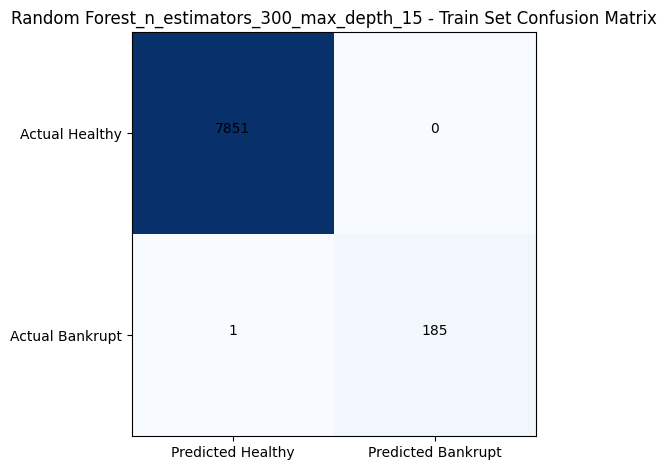

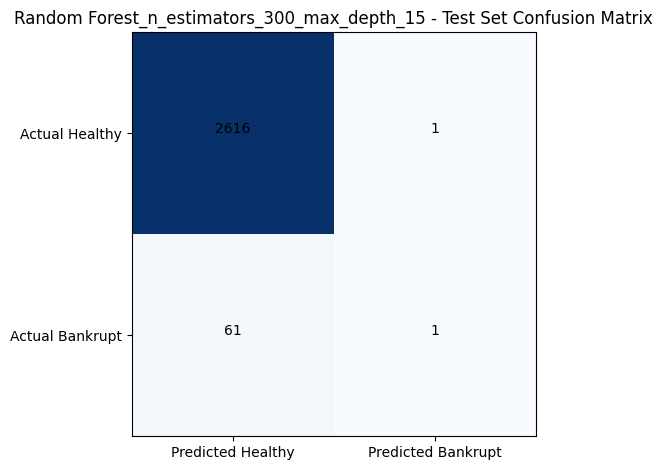

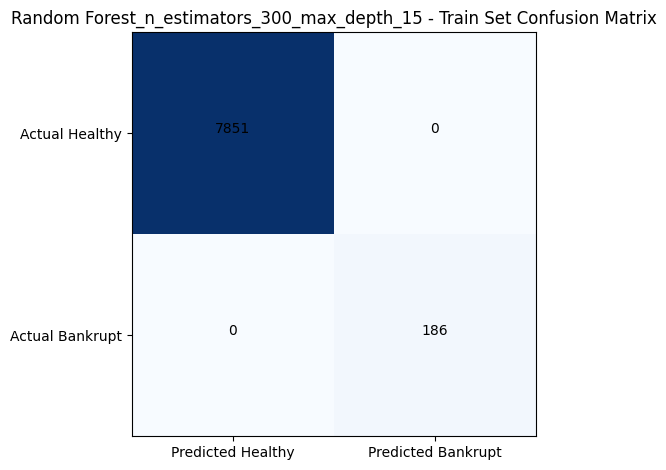

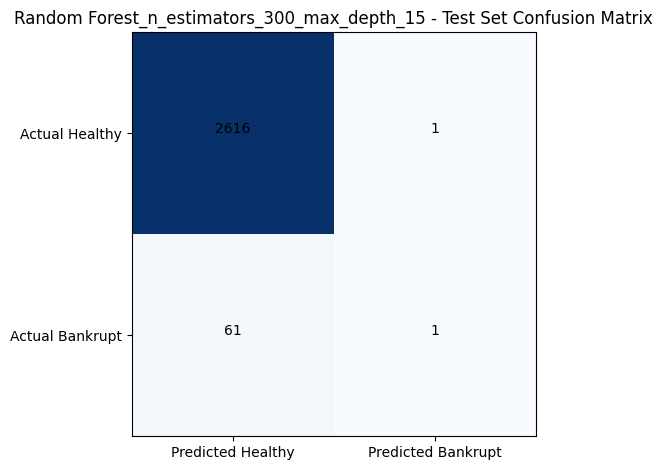

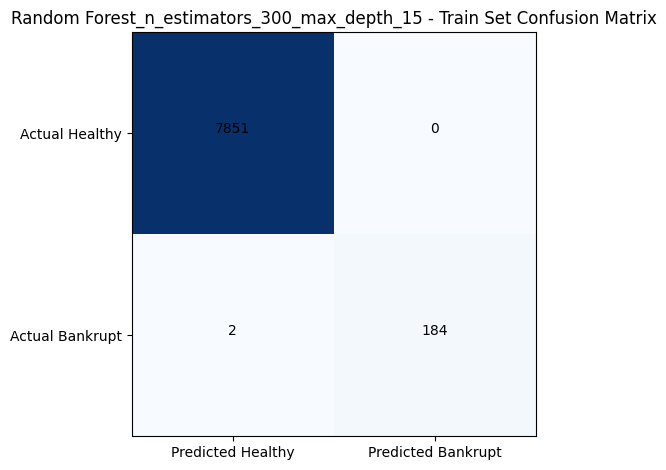

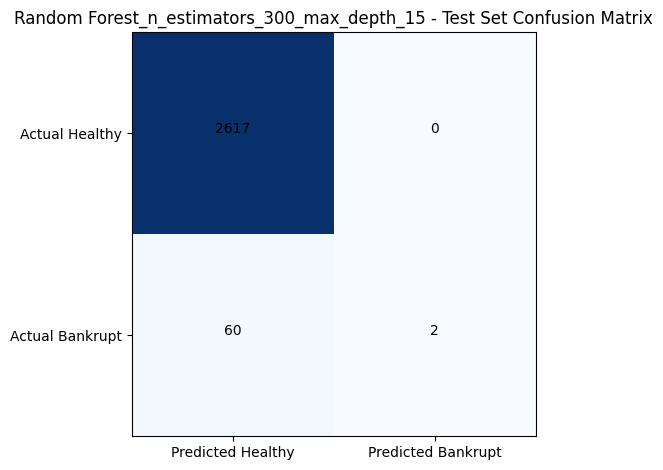

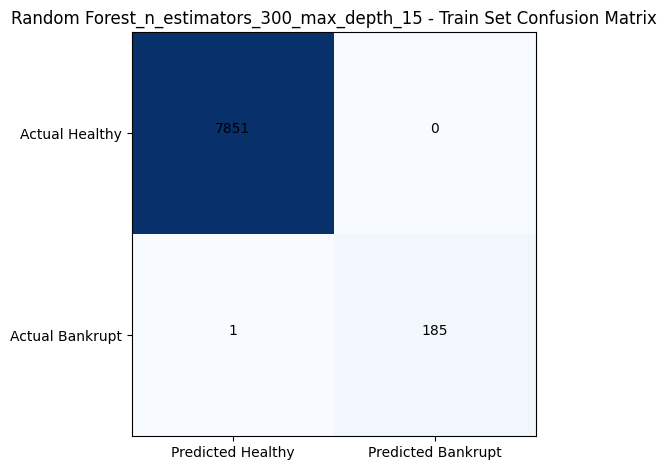

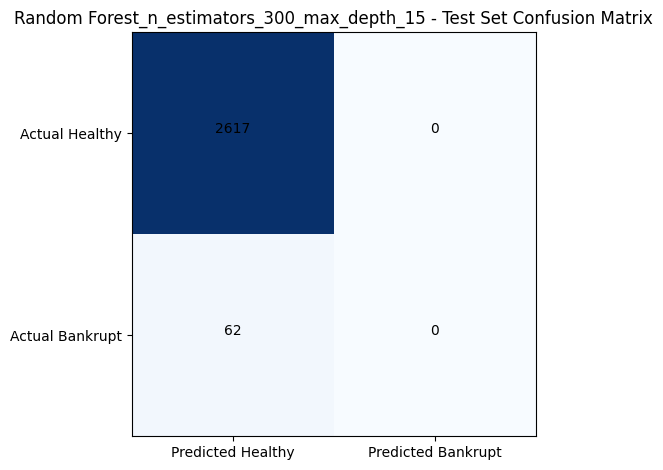


Random Forest_n_estimators_300_max_depth_15 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.75

Random Forest_n_estimators_300_max_depth_15 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.73

Random Forest_n_estimators_300_max_depth_15 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.73

Random Forest_n_estimators_300_max_depth_15 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.79

Random Forest_n_estimators_300_max_depth_15 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.75

Random Forest_n_estimators_300_max_depth_15 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.73

Random Forest_n_estimators_300_max_depth_15 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.75

Random Forest_n_estimators_300_max_depth_15 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.74
Classifier: k-Nearest Neighb

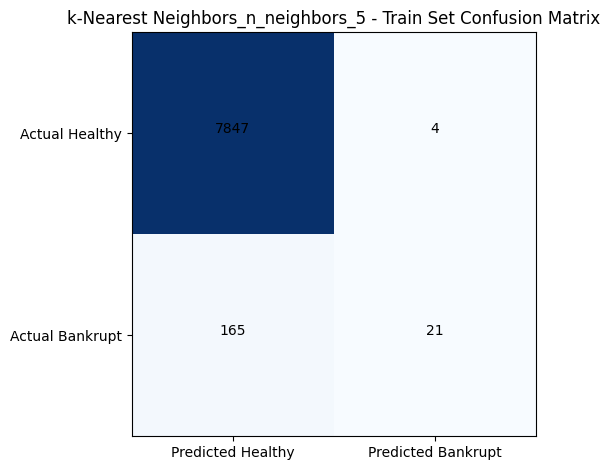

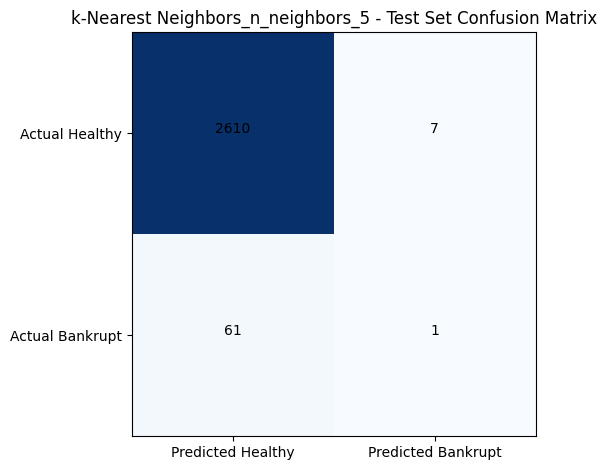

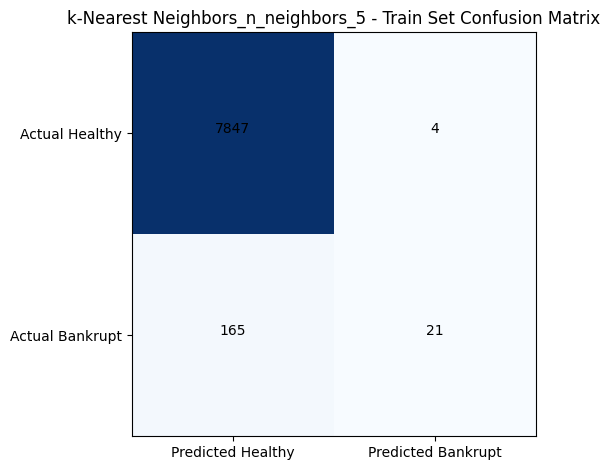

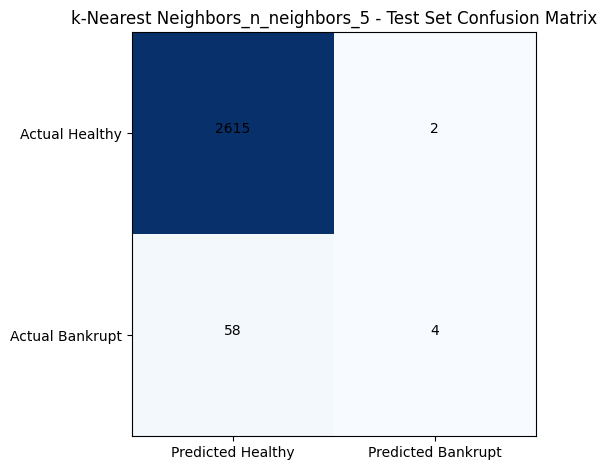

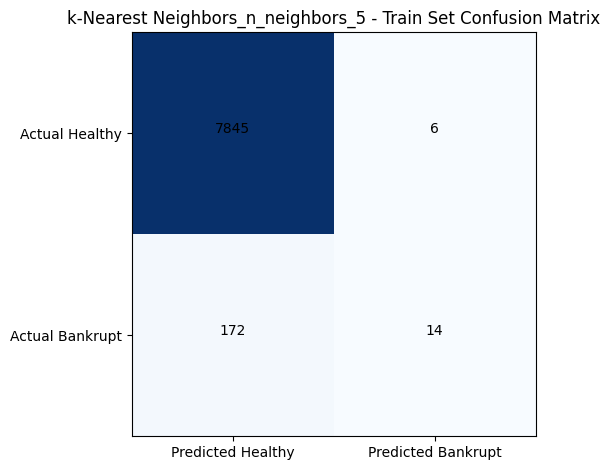

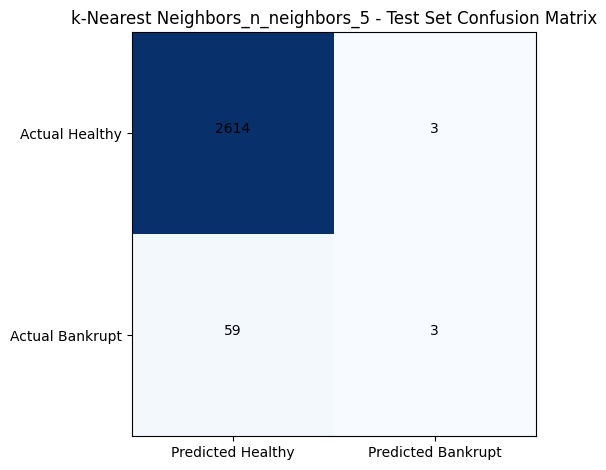

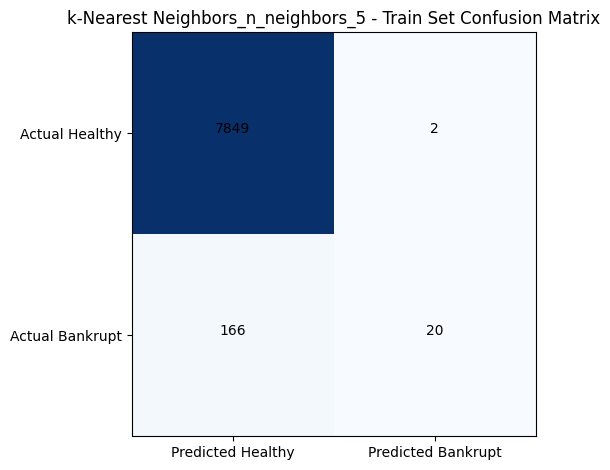

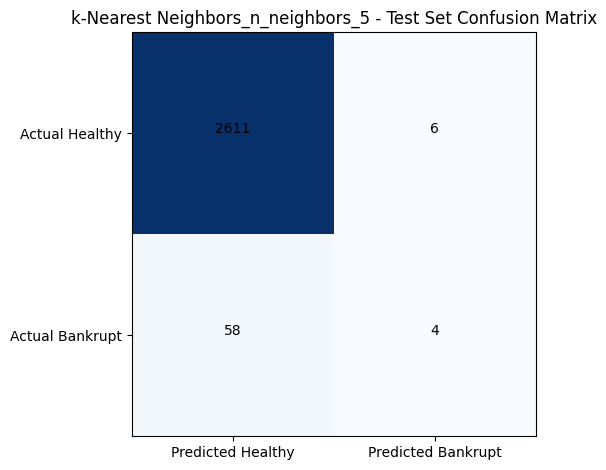


k-Nearest Neighbors_n_neighbors_5 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.09

k-Nearest Neighbors_n_neighbors_5 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.13

k-Nearest Neighbors_n_neighbors_5 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.09

k-Nearest Neighbors_n_neighbors_5 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.11

k-Nearest Neighbors_n_neighbors_5 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.10

k-Nearest Neighbors_n_neighbors_5 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.10

k-Nearest Neighbors_n_neighbors_5 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.11

k-Nearest Neighbors_n_neighbors_5 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.05
Classifier: k-Nearest Neighbors_n_neighbors_10


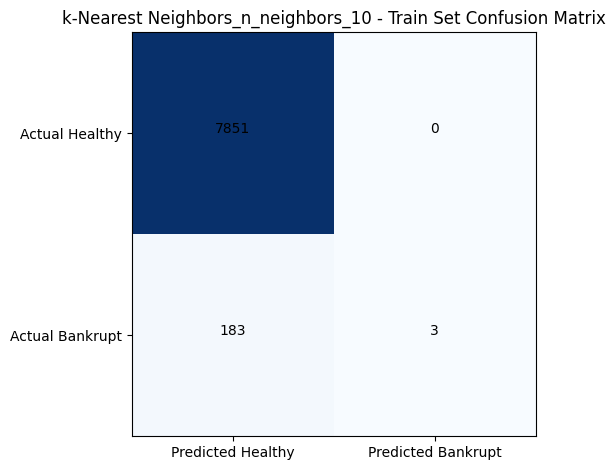

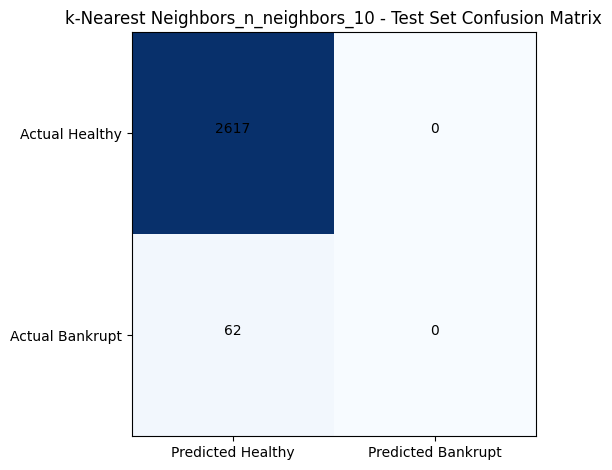

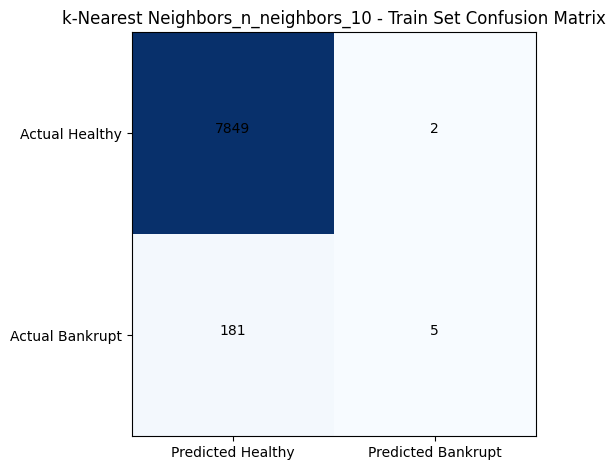

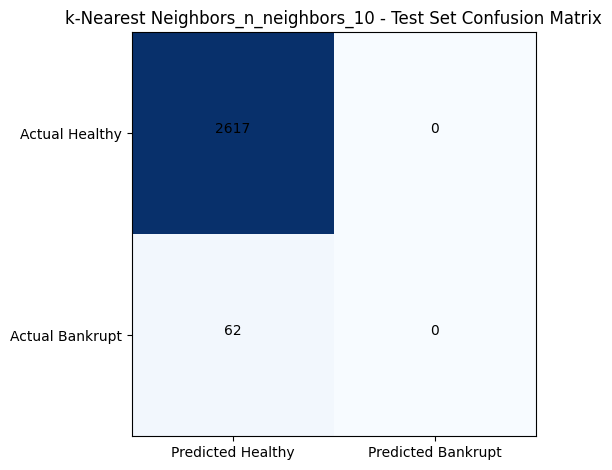

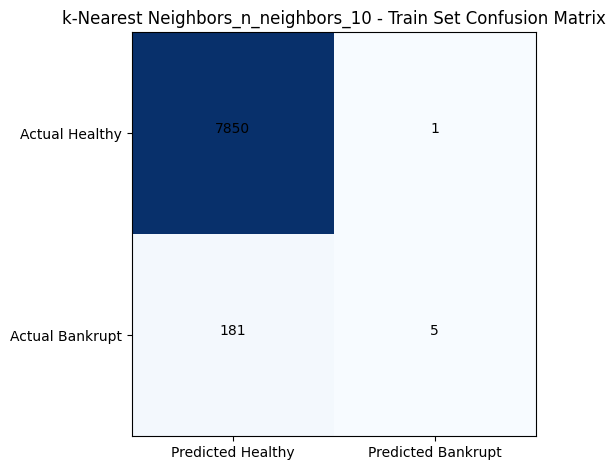

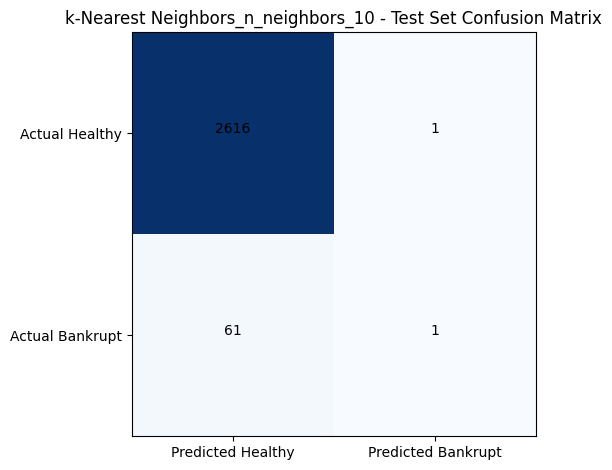

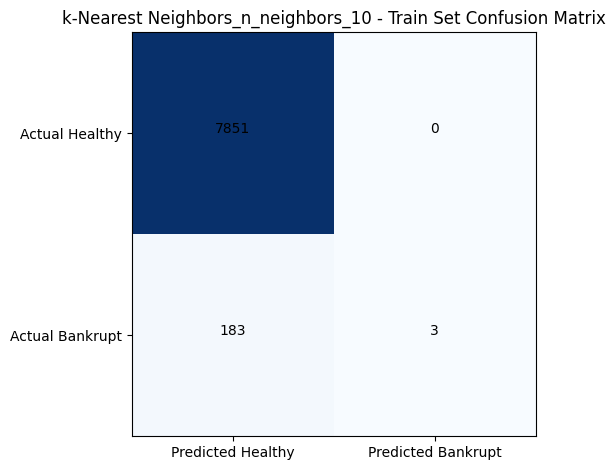

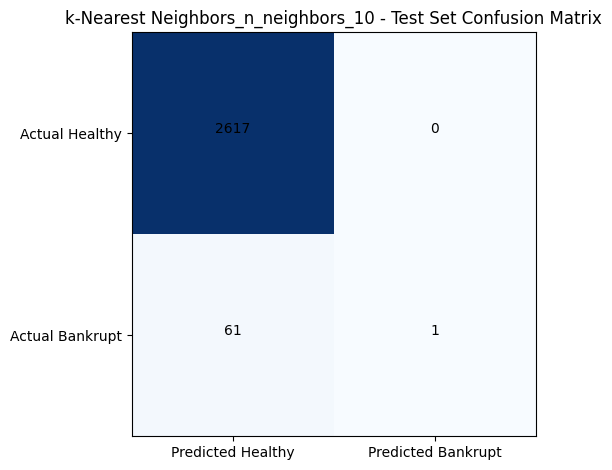


k-Nearest Neighbors_n_neighbors_10 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.02

k-Nearest Neighbors_n_neighbors_10 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.02

k-Nearest Neighbors_n_neighbors_10 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.01

k-Nearest Neighbors_n_neighbors_10 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.03

k-Nearest Neighbors_n_neighbors_10 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.02

k-Nearest Neighbors_n_neighbors_10 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

k-Nearest Neighbors_n_neighbors_10 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.02

k-Nearest Neighbors_n_neighbors_10 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.02
Classifier: k-Nearest Neighbors_n_neighbors_15


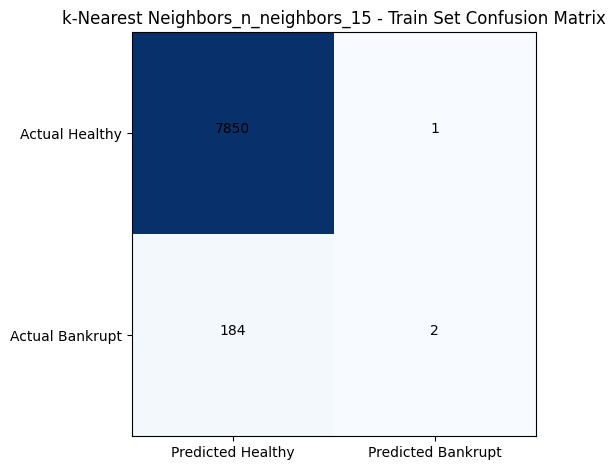

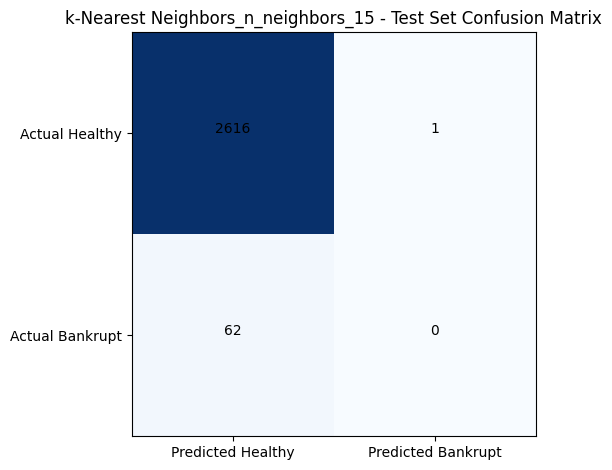

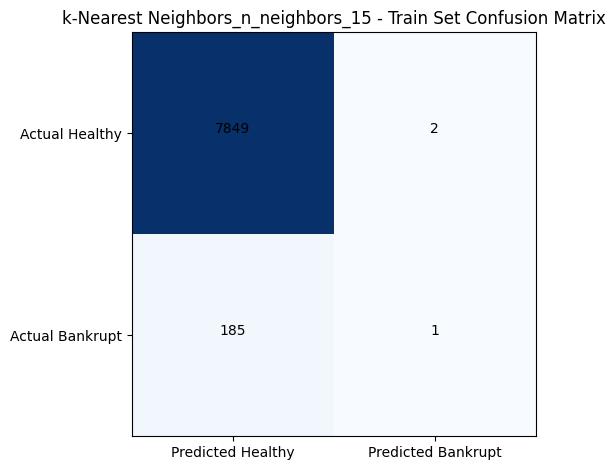

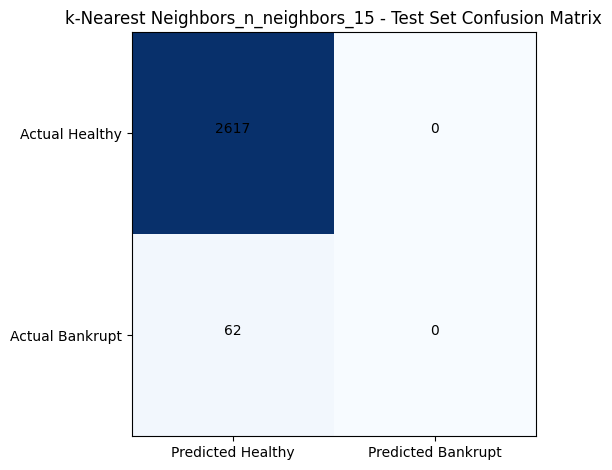

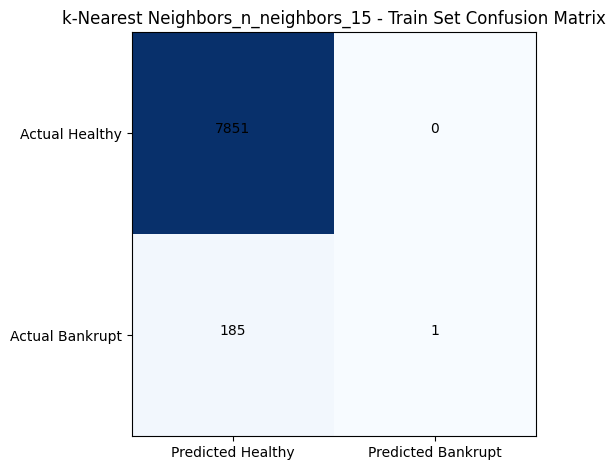

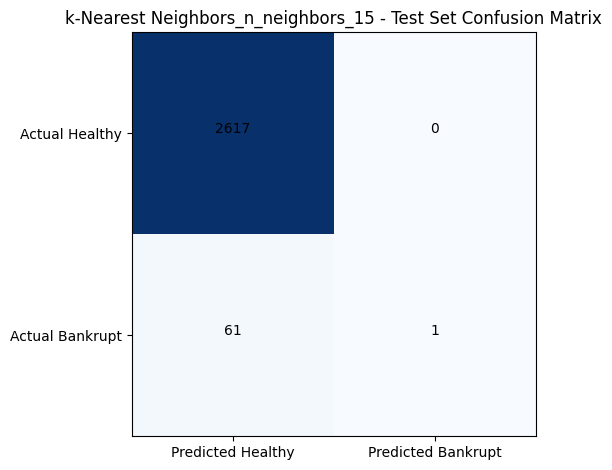

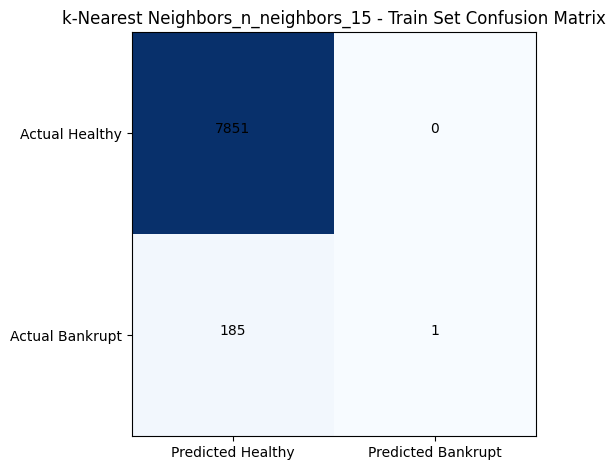

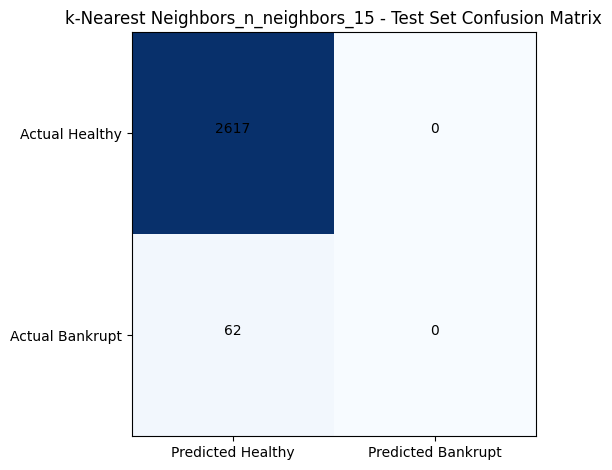


k-Nearest Neighbors_n_neighbors_15 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

k-Nearest Neighbors_n_neighbors_15 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.02

k-Nearest Neighbors_n_neighbors_15 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.01

k-Nearest Neighbors_n_neighbors_15 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

k-Nearest Neighbors_n_neighbors_15 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.01

k-Nearest Neighbors_n_neighbors_15 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

k-Nearest Neighbors_n_neighbors_15 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.01

k-Nearest Neighbors_n_neighbors_15 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Naïve Bayes


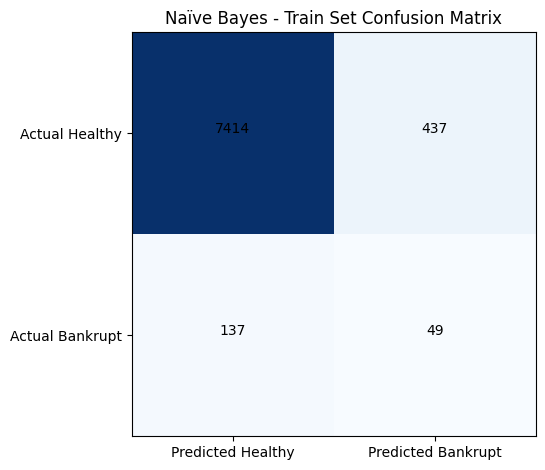

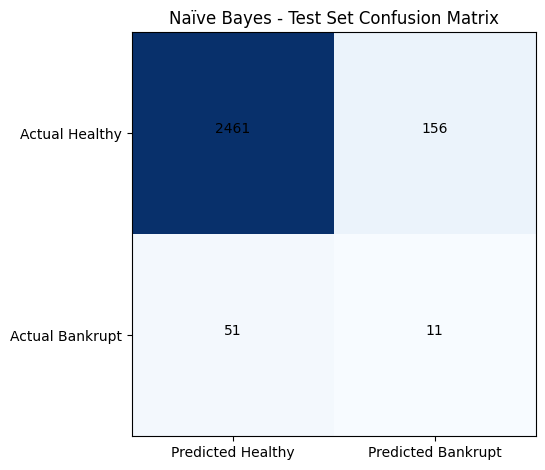

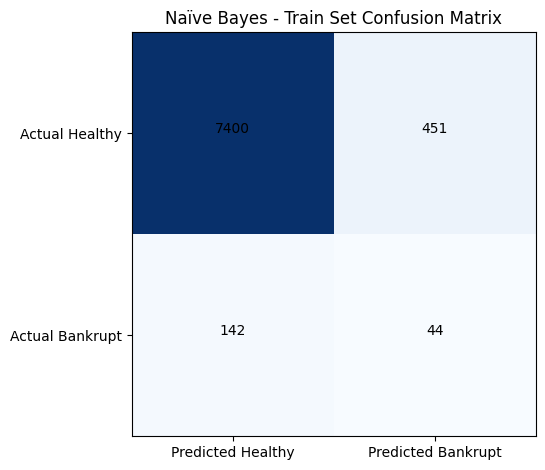

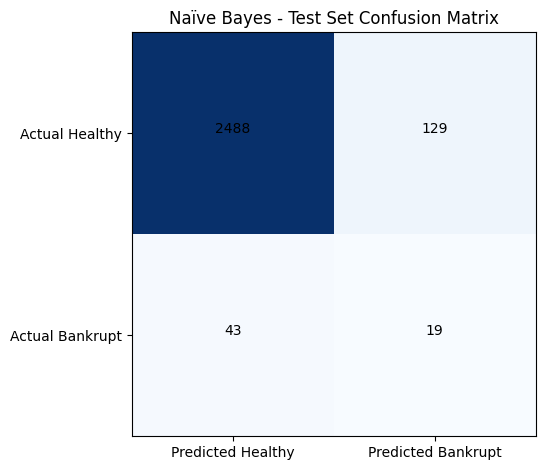

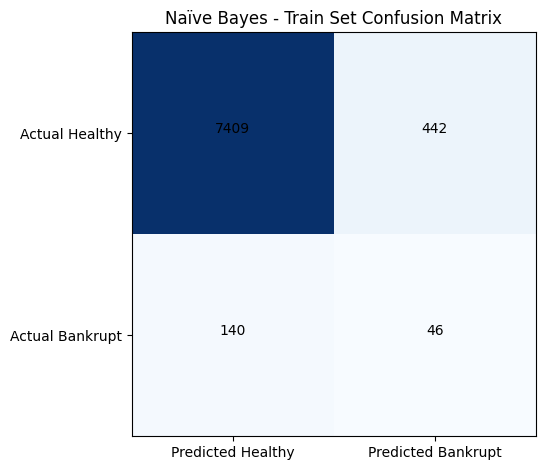

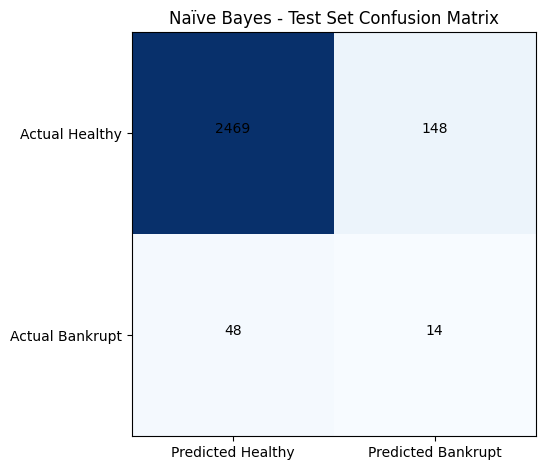

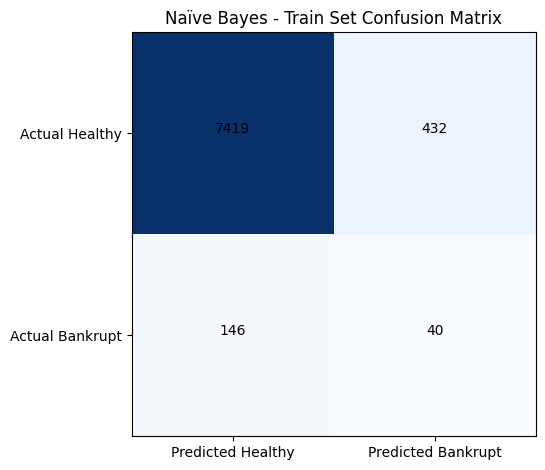

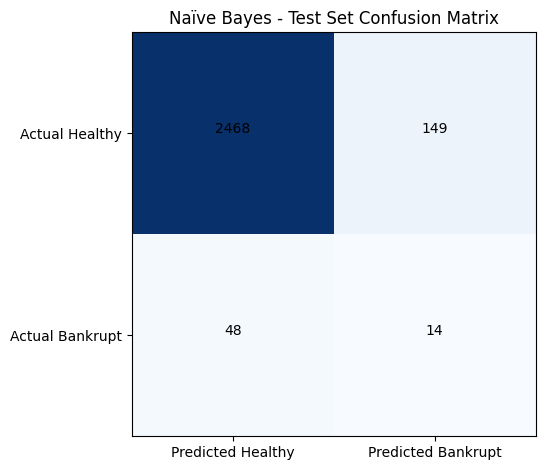


Naïve Bayes - Train Set Performance (Fold 1):
Success Rate Healthy: 0.94, Bankrupt: 0.22

Naïve Bayes - Test Set Performance (Fold 1):
Success Rate Healthy: 0.94, Bankrupt: 0.21

Naïve Bayes - Train Set Performance (Fold 2):
Success Rate Healthy: 0.94, Bankrupt: 0.22

Naïve Bayes - Test Set Performance (Fold 2):
Success Rate Healthy: 0.94, Bankrupt: 0.21

Naïve Bayes - Train Set Performance (Fold 3):
Success Rate Healthy: 0.95, Bankrupt: 0.22

Naïve Bayes - Test Set Performance (Fold 3):
Success Rate Healthy: 0.94, Bankrupt: 0.23

Naïve Bayes - Train Set Performance (Fold 4):
Success Rate Healthy: 0.94, Bankrupt: 0.22

Naïve Bayes - Test Set Performance (Fold 4):
Success Rate Healthy: 0.95, Bankrupt: 0.23
Classifier: Naïve Bayes_var_smoothing_0.1


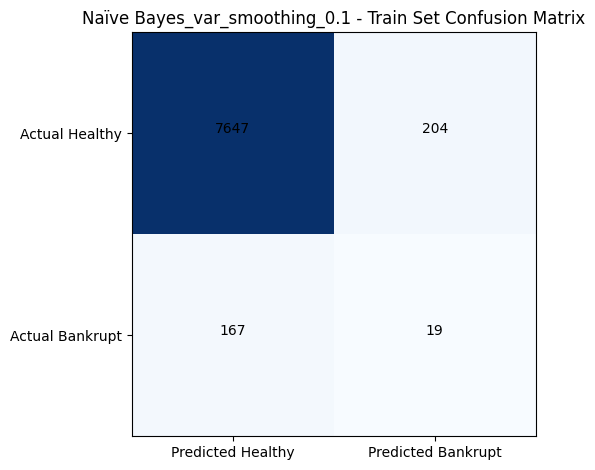

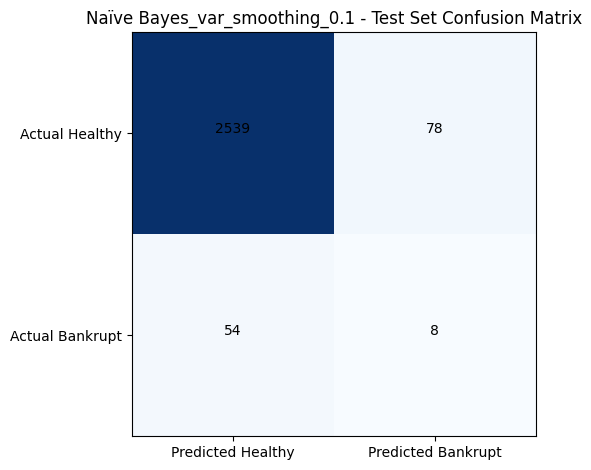

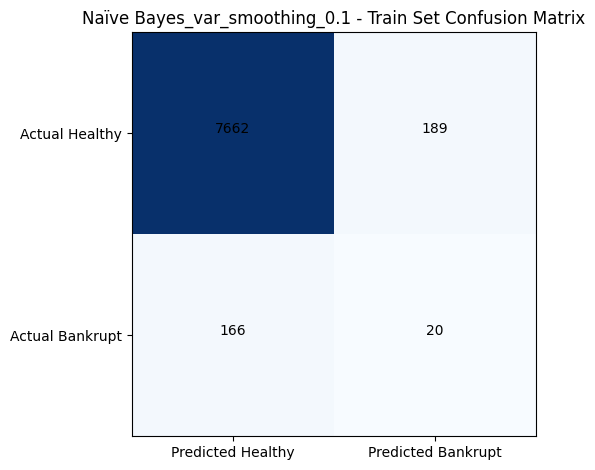

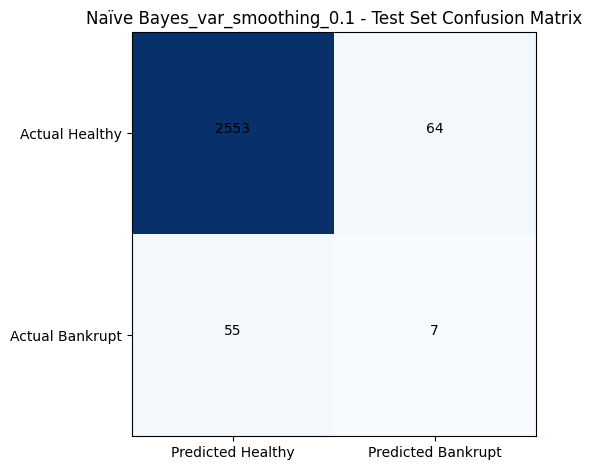

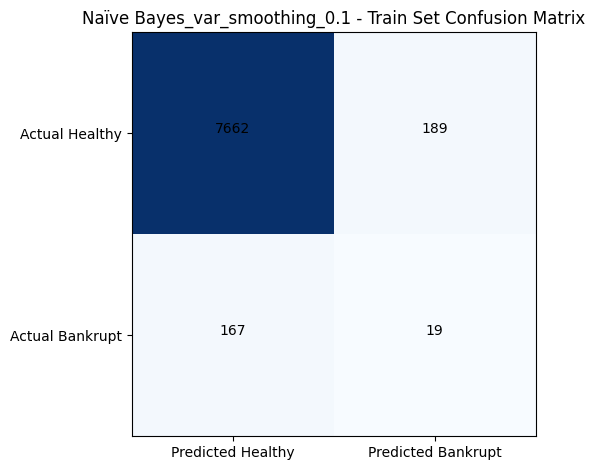

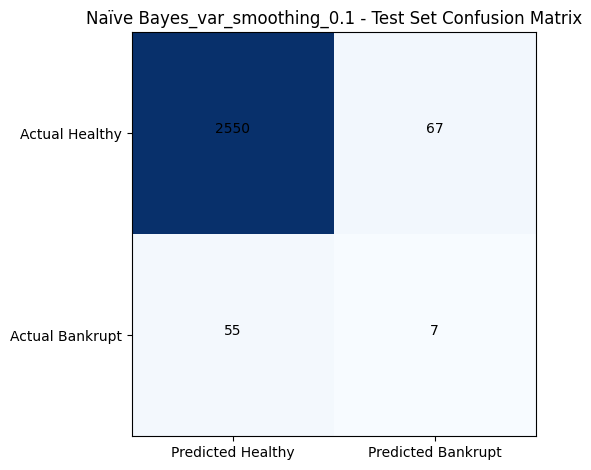

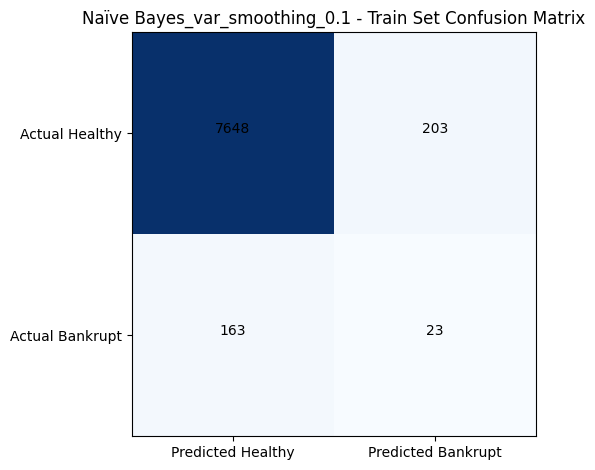

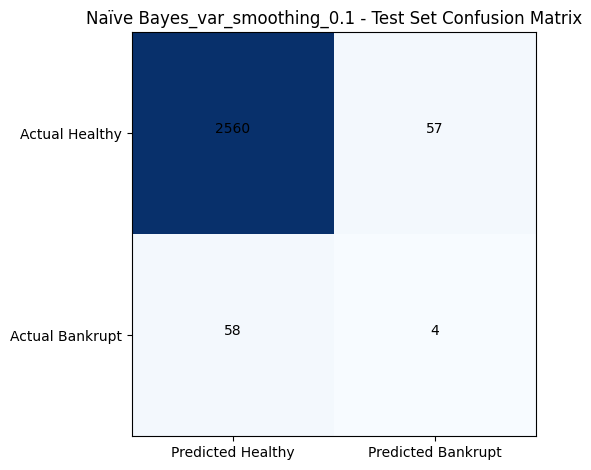


Naïve Bayes_var_smoothing_0.1 - Train Set Performance (Fold 1):
Success Rate Healthy: 0.97, Bankrupt: 0.12

Naïve Bayes_var_smoothing_0.1 - Test Set Performance (Fold 1):
Success Rate Healthy: 0.98, Bankrupt: 0.08

Naïve Bayes_var_smoothing_0.1 - Train Set Performance (Fold 2):
Success Rate Healthy: 0.97, Bankrupt: 0.11

Naïve Bayes_var_smoothing_0.1 - Test Set Performance (Fold 2):
Success Rate Healthy: 0.98, Bankrupt: 0.11

Naïve Bayes_var_smoothing_0.1 - Train Set Performance (Fold 3):
Success Rate Healthy: 0.98, Bankrupt: 0.10

Naïve Bayes_var_smoothing_0.1 - Test Set Performance (Fold 3):
Success Rate Healthy: 0.97, Bankrupt: 0.15

Naïve Bayes_var_smoothing_0.1 - Train Set Performance (Fold 4):
Success Rate Healthy: 0.98, Bankrupt: 0.11

Naïve Bayes_var_smoothing_0.1 - Test Set Performance (Fold 4):
Success Rate Healthy: 0.97, Bankrupt: 0.10
Classifier: Naïve Bayes_var_smoothing_0.01


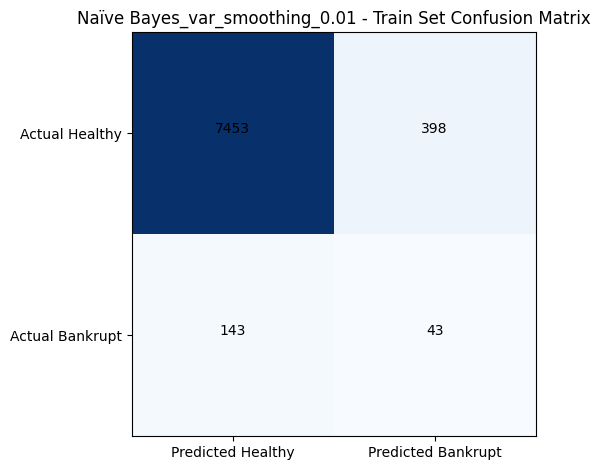

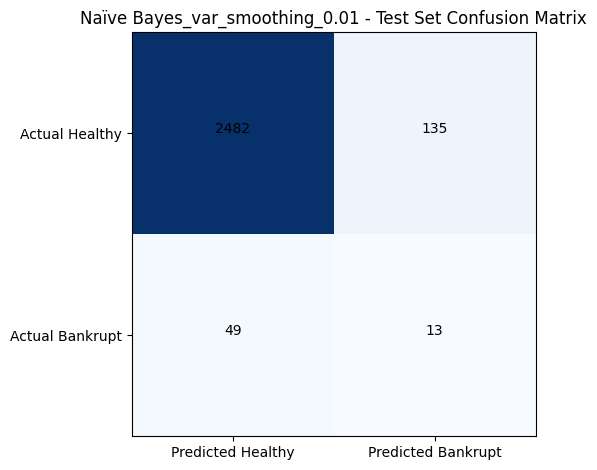

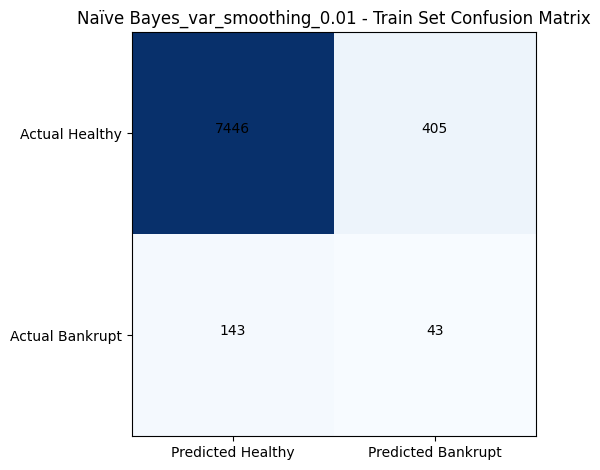

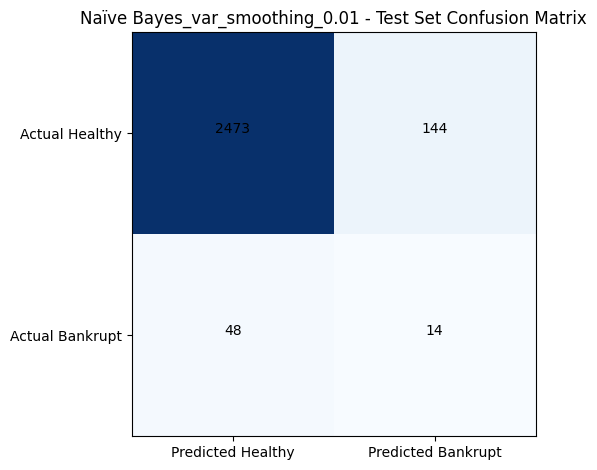

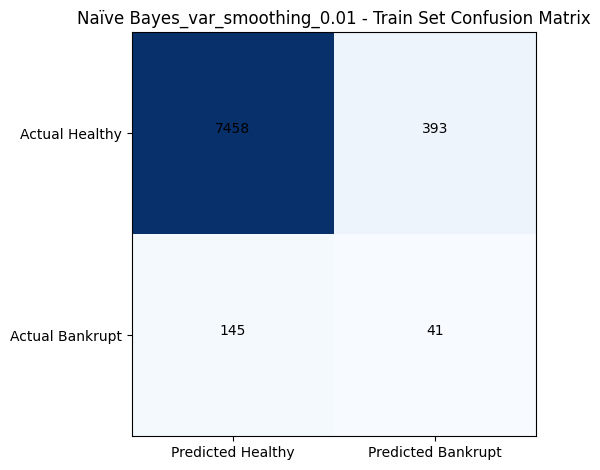

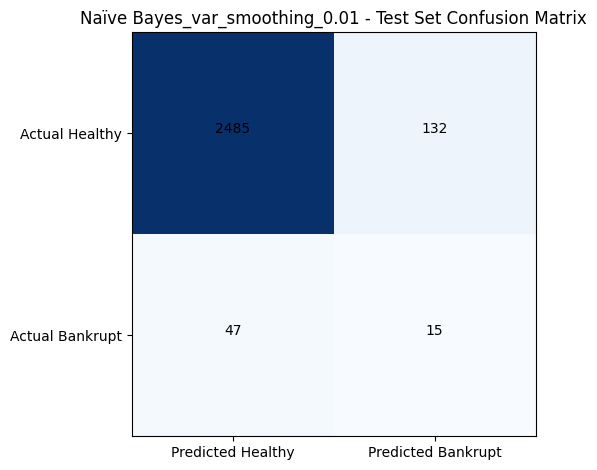

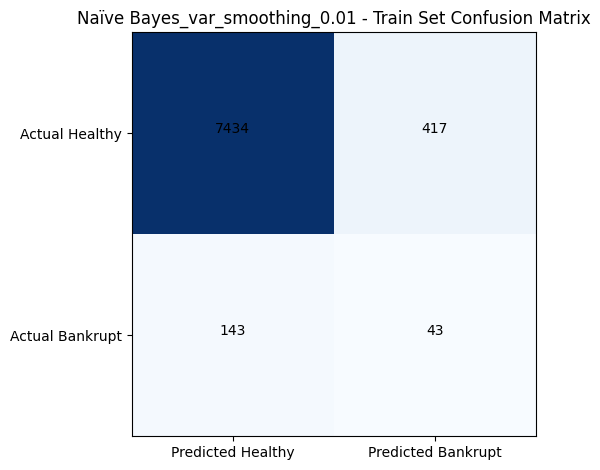

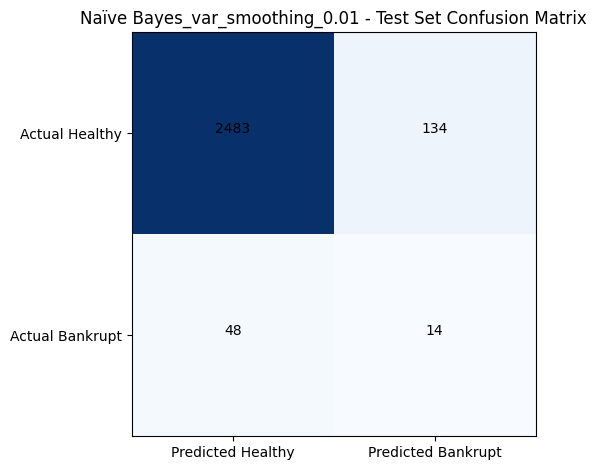


Naïve Bayes_var_smoothing_0.01 - Train Set Performance (Fold 1):
Success Rate Healthy: 0.95, Bankrupt: 0.20

Naïve Bayes_var_smoothing_0.01 - Test Set Performance (Fold 1):
Success Rate Healthy: 0.95, Bankrupt: 0.32

Naïve Bayes_var_smoothing_0.01 - Train Set Performance (Fold 2):
Success Rate Healthy: 0.95, Bankrupt: 0.25

Naïve Bayes_var_smoothing_0.01 - Test Set Performance (Fold 2):
Success Rate Healthy: 0.95, Bankrupt: 0.18

Naïve Bayes_var_smoothing_0.01 - Train Set Performance (Fold 3):
Success Rate Healthy: 0.95, Bankrupt: 0.23

Naïve Bayes_var_smoothing_0.01 - Test Set Performance (Fold 3):
Success Rate Healthy: 0.94, Bankrupt: 0.23

Naïve Bayes_var_smoothing_0.01 - Train Set Performance (Fold 4):
Success Rate Healthy: 0.95, Bankrupt: 0.24

Naïve Bayes_var_smoothing_0.01 - Test Set Performance (Fold 4):
Success Rate Healthy: 0.95, Bankrupt: 0.19
Classifier: Support Vector Machines_rbf


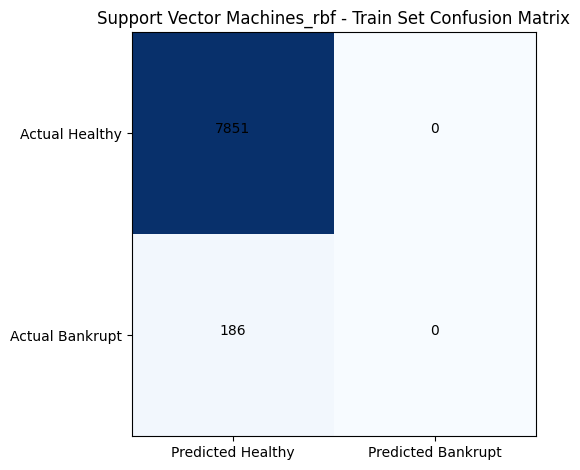

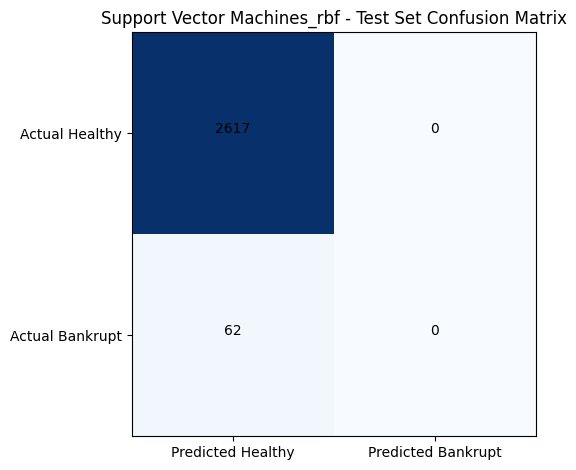

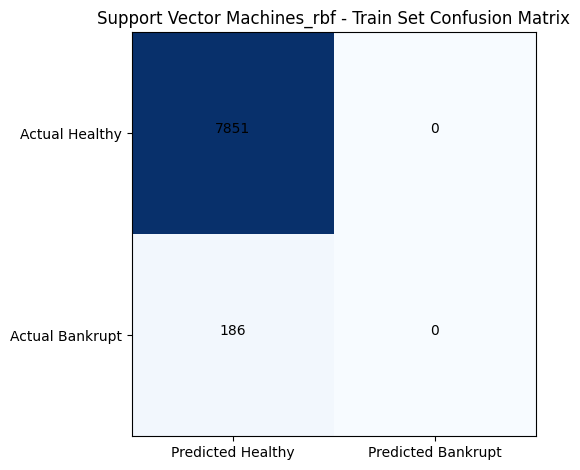

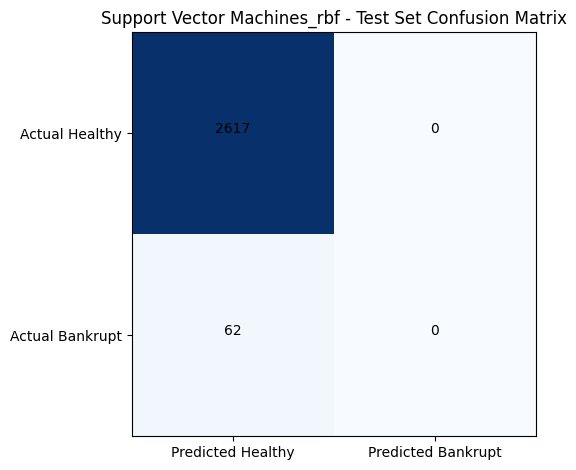

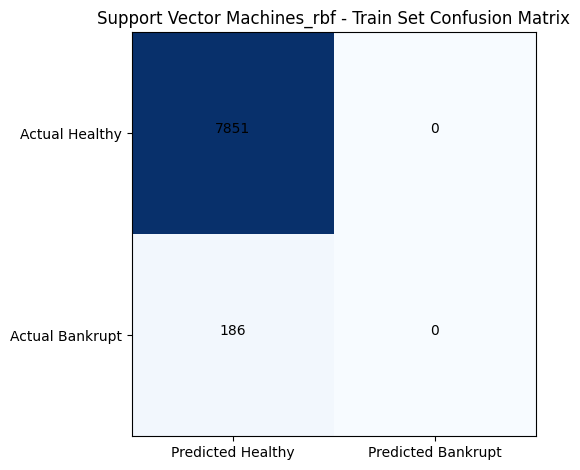

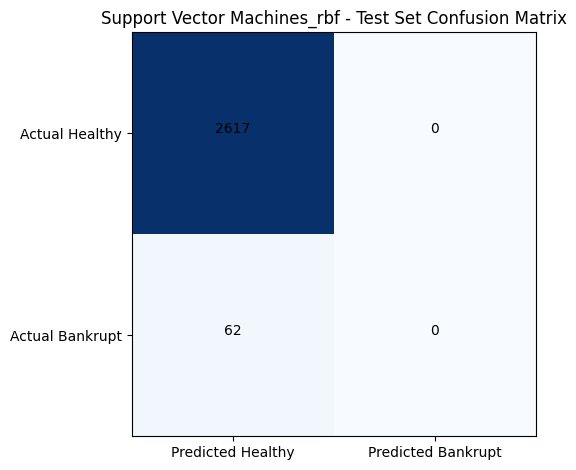

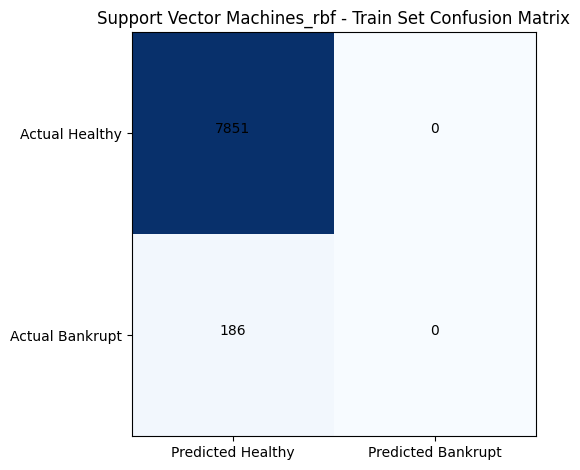

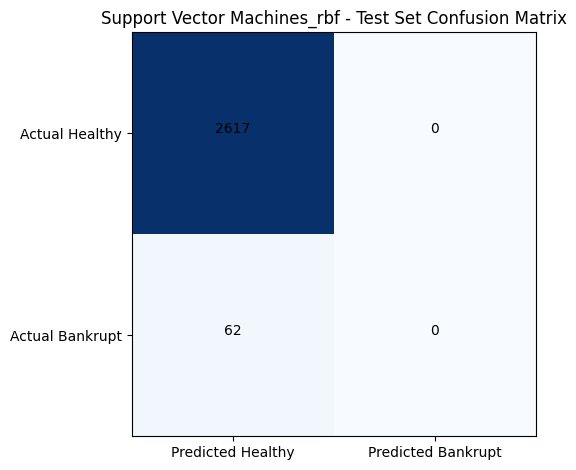


Support Vector Machines_rbf - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_rbf - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Support Vector Machines_linear


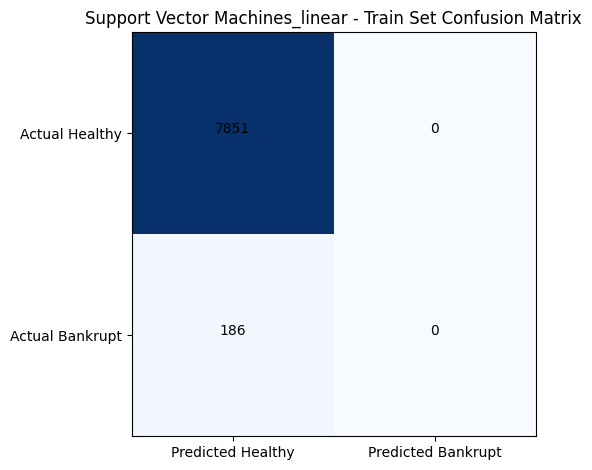

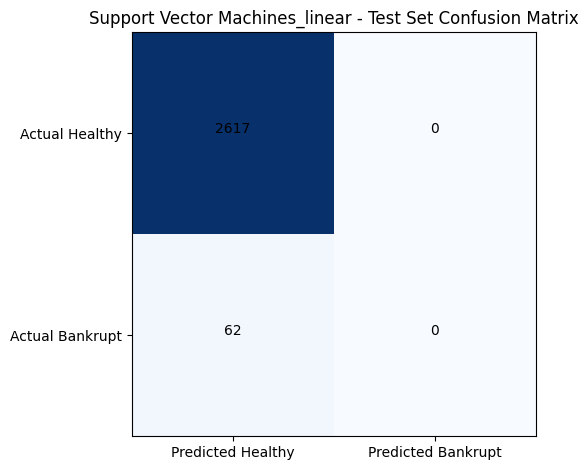

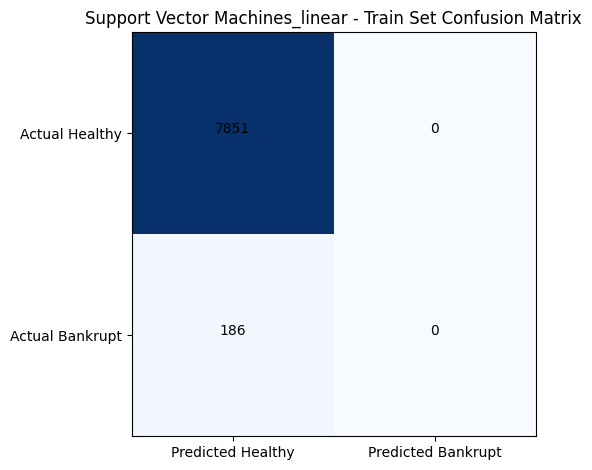

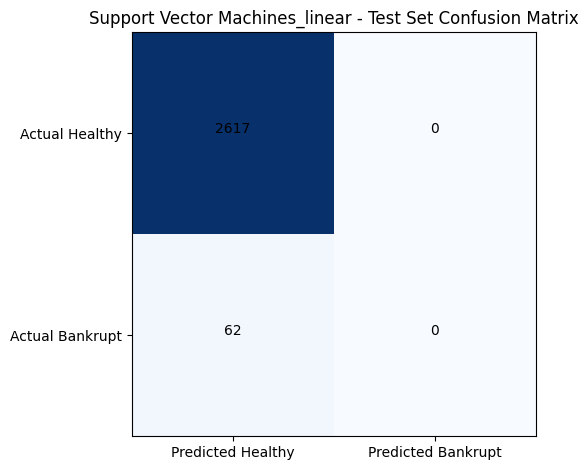

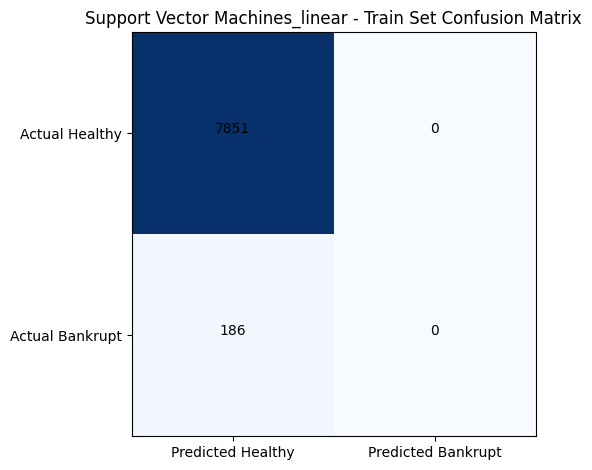

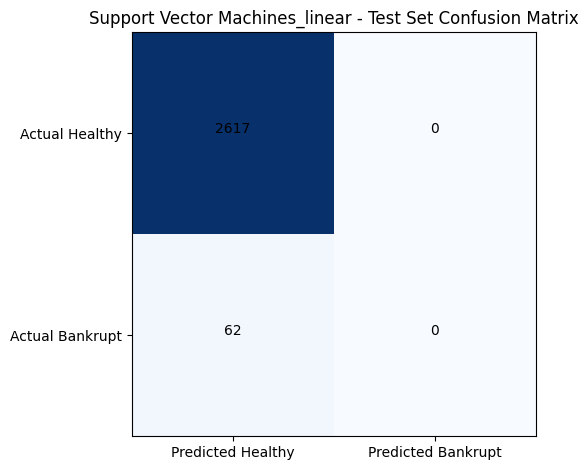

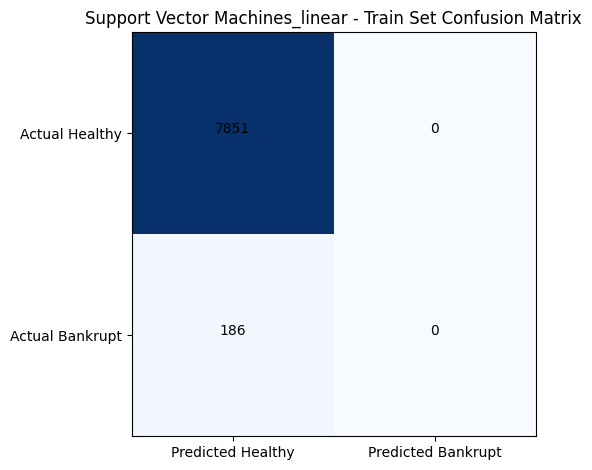

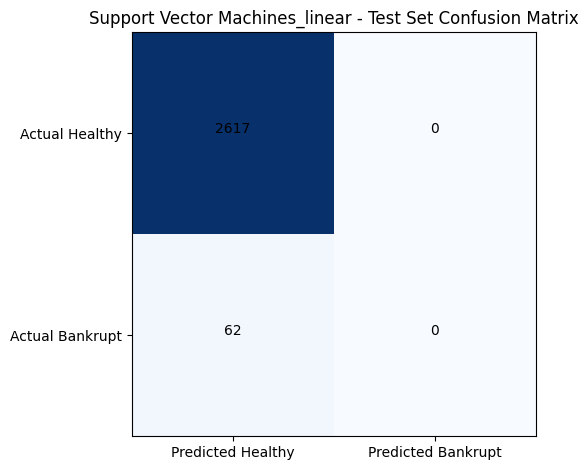


Support Vector Machines_linear - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_linear - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Support Vector Machines_poly_degree_2


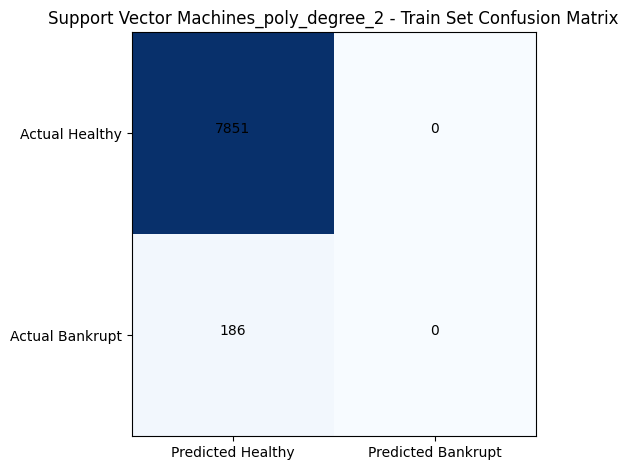

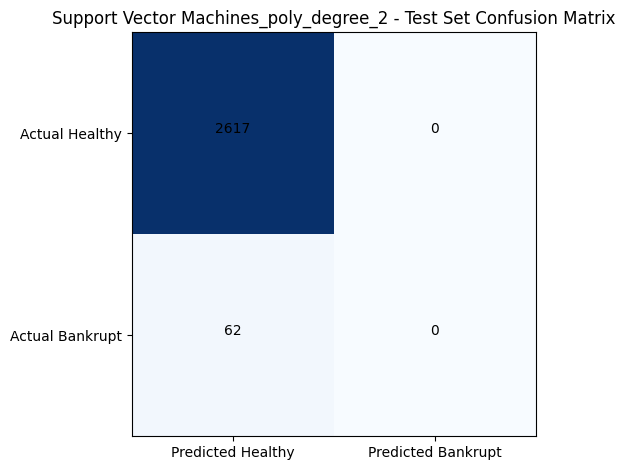

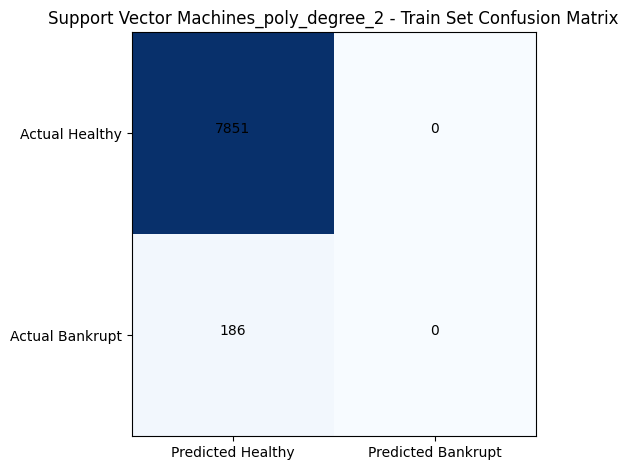

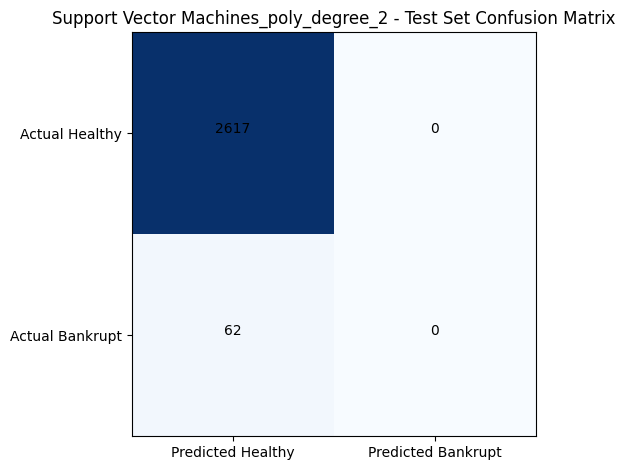

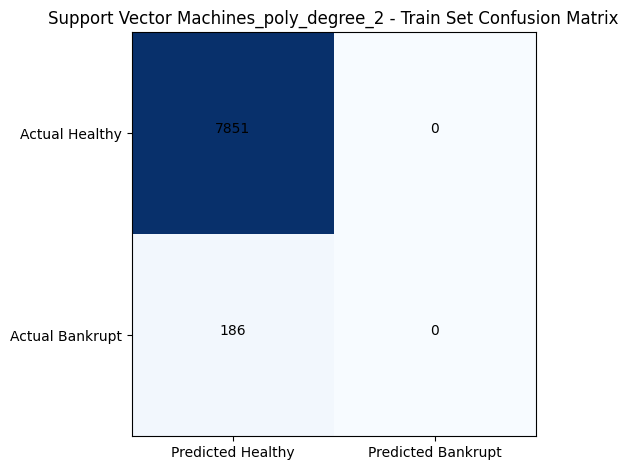

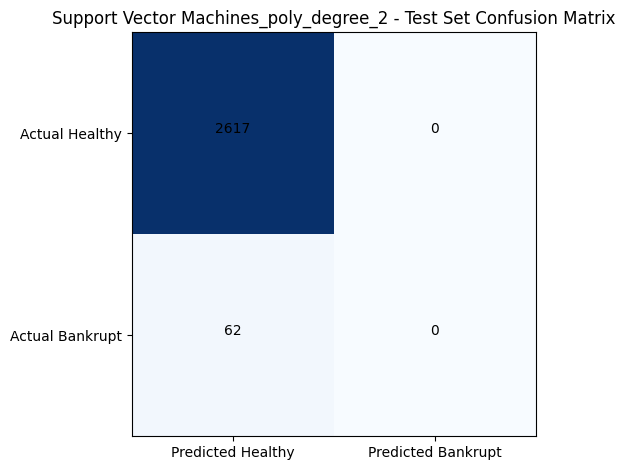

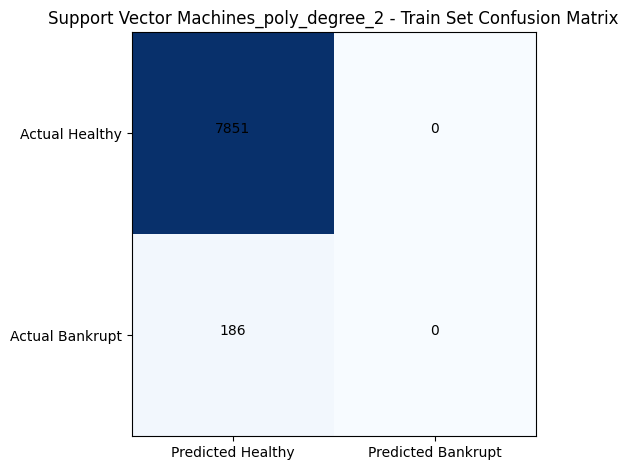

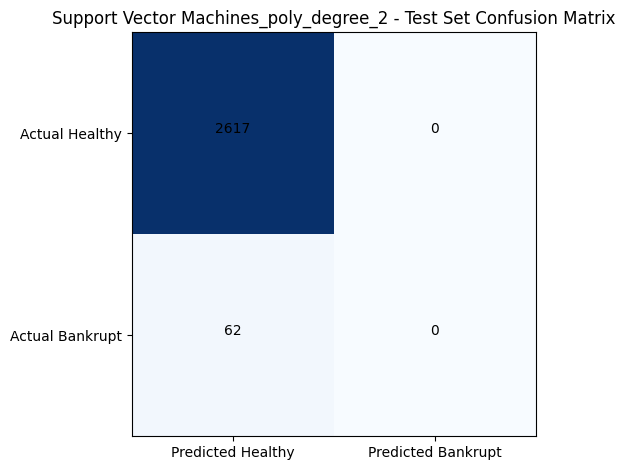


Support Vector Machines_poly_degree_2 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Support Vector Machines_poly_degree_2 - Test Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.00
Classifier: Gradient Boosting_n_estimators_100_learn_rate_0.1


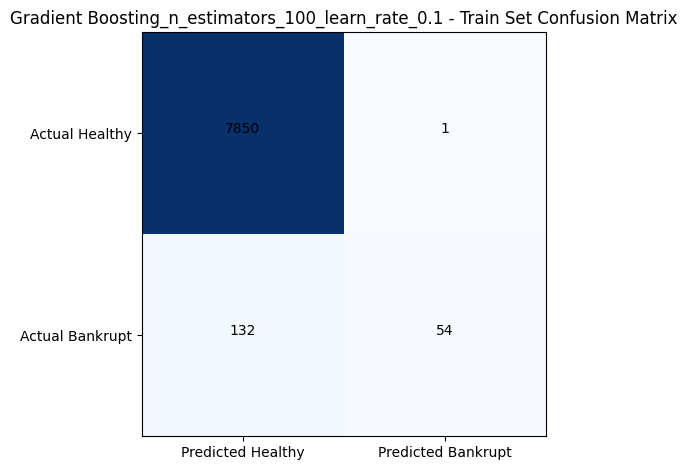

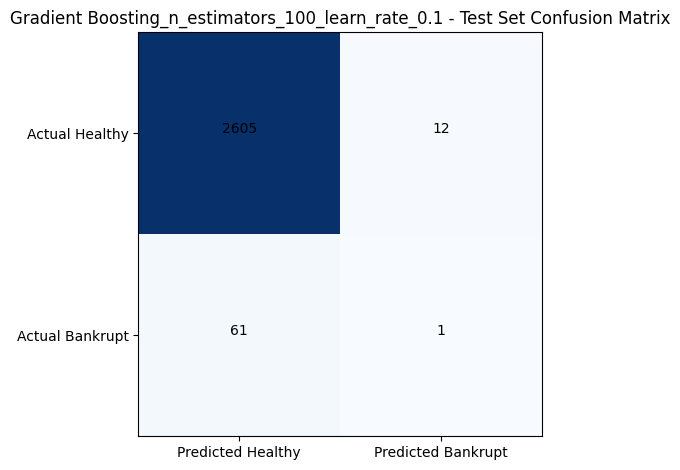

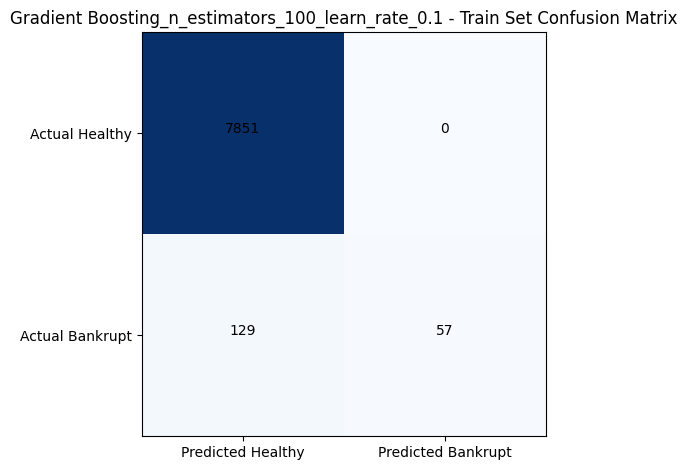

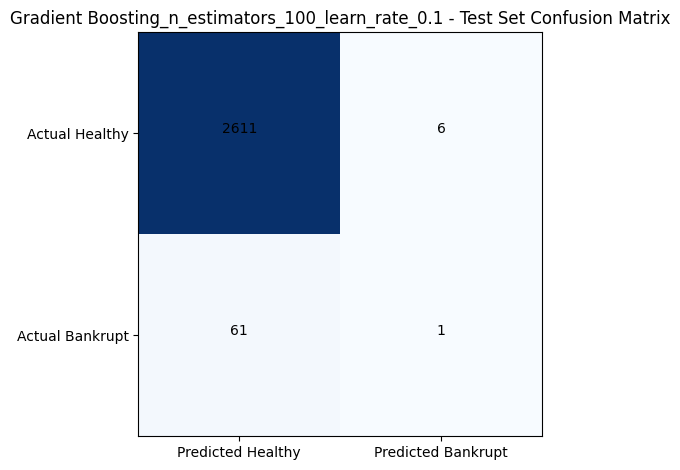

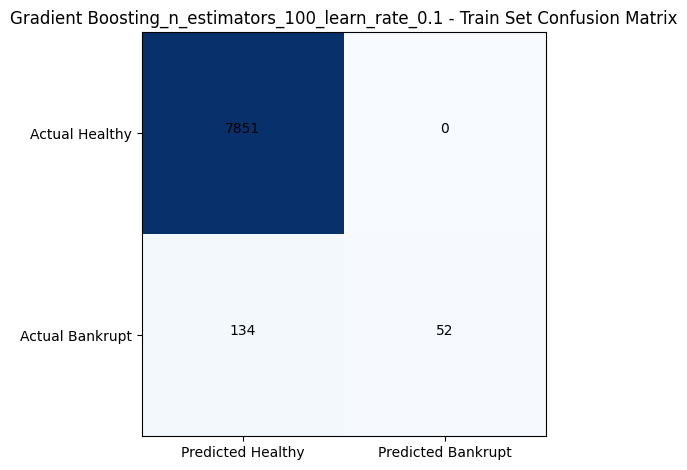

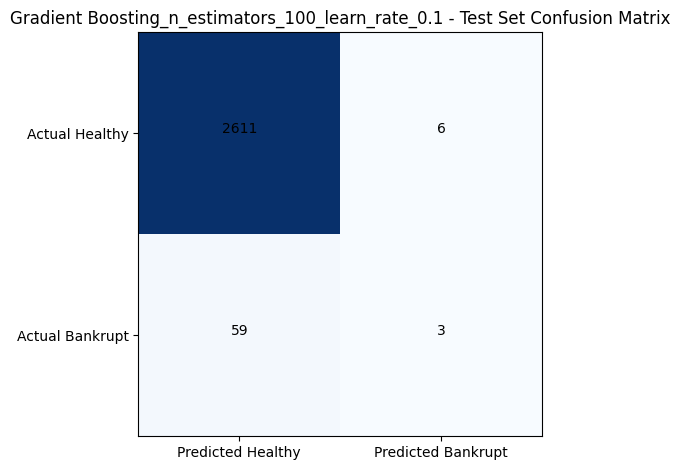

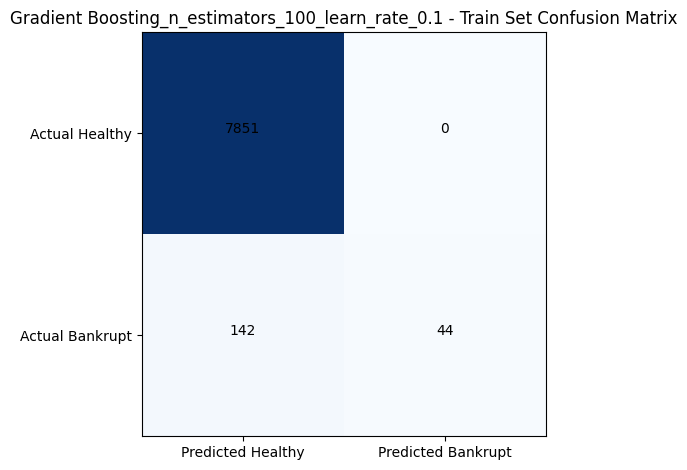

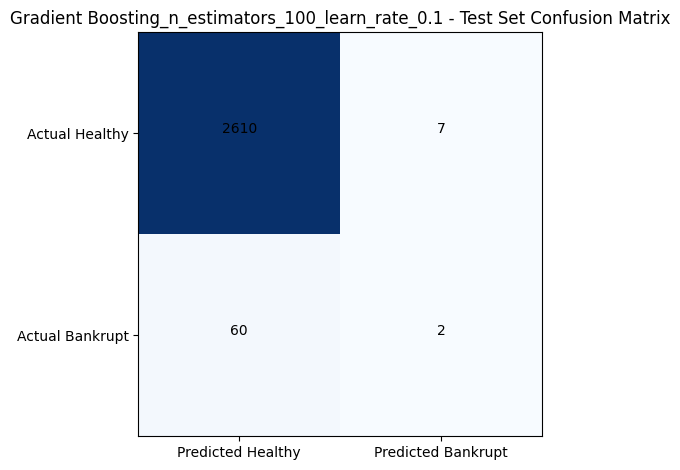


Gradient Boosting_n_estimators_100_learn_rate_0.1 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.18

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.18

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.18

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_100_learn_rate_0.1 - Test Set Performance (Fold 4):
Success Rate Healthy: 1

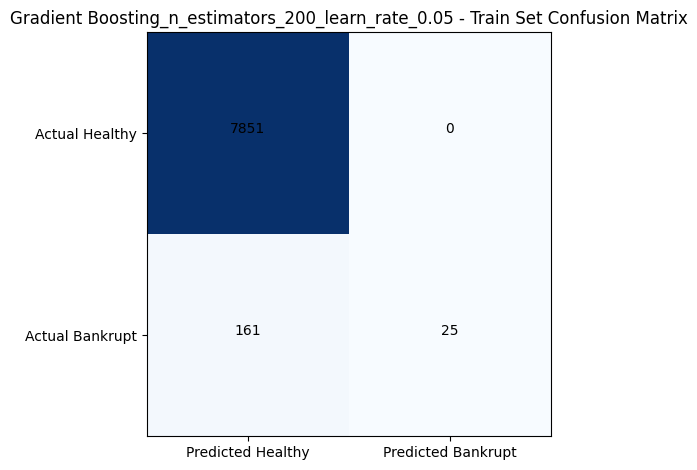

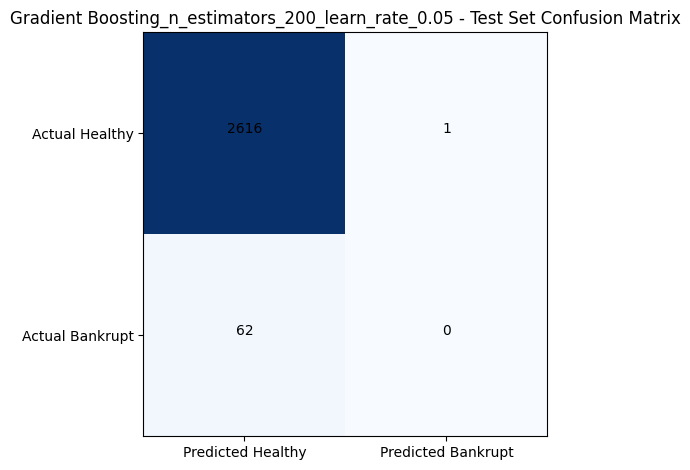

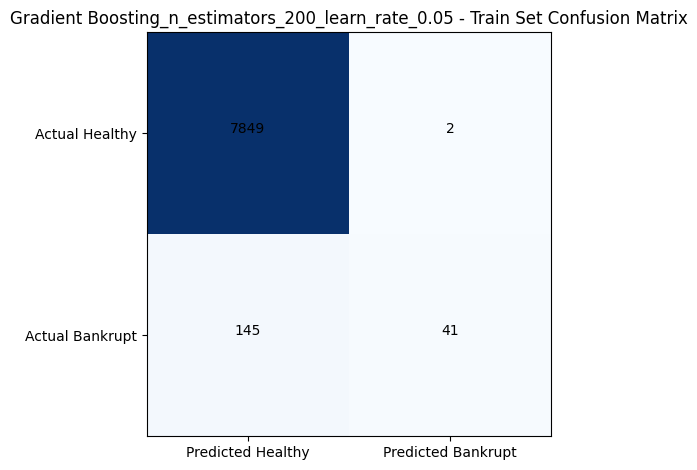

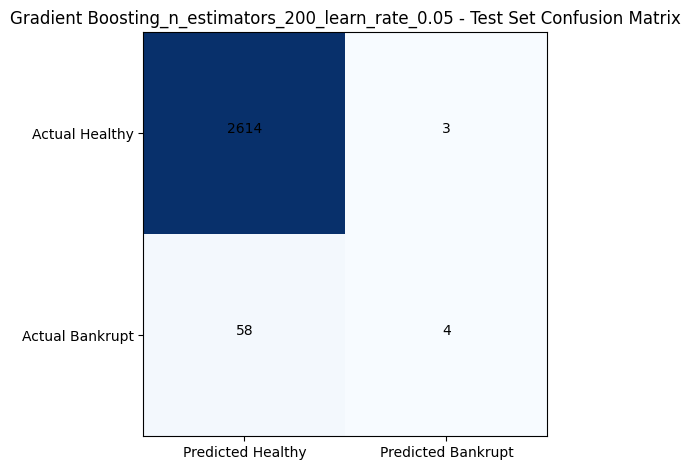

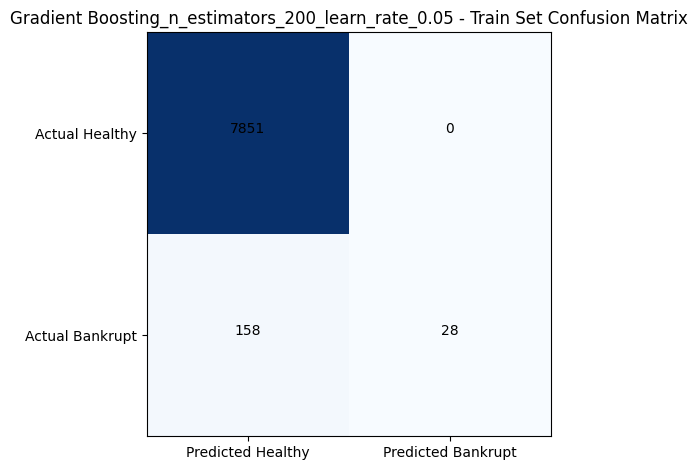

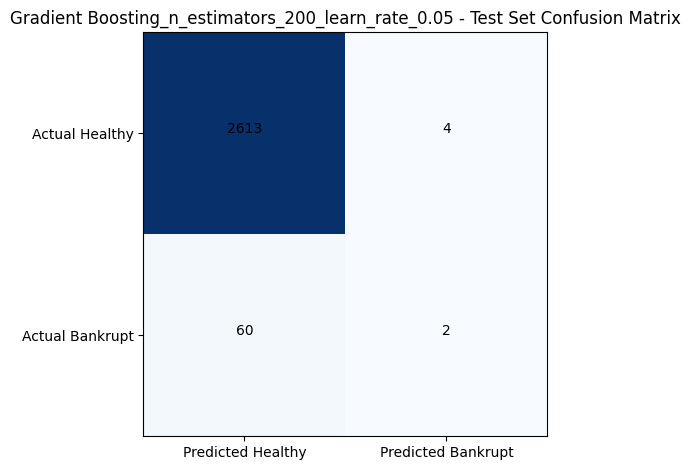

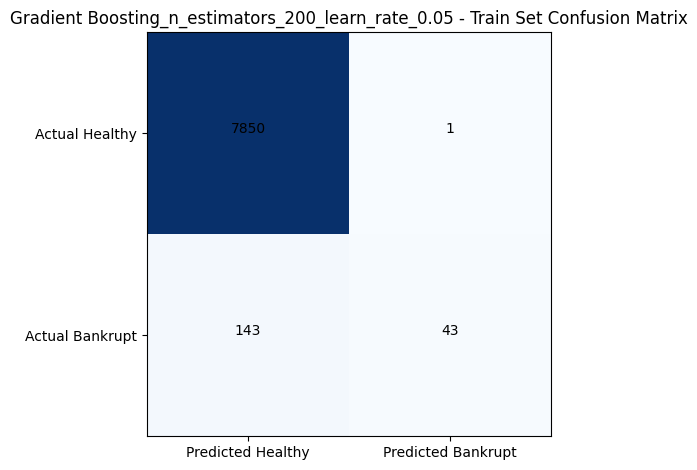

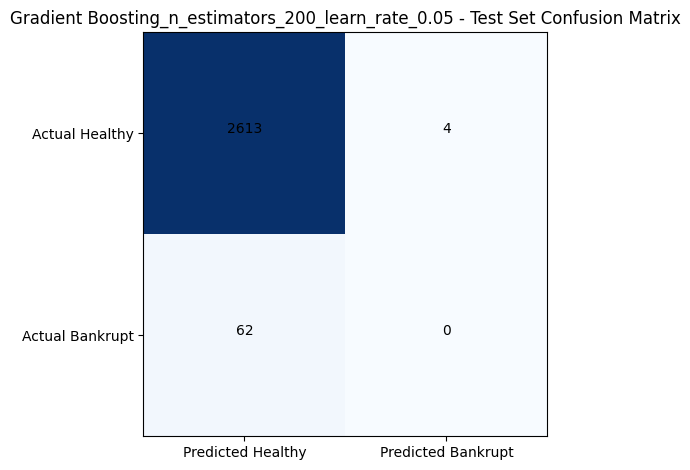


Gradient Boosting_n_estimators_200_learn_rate_0.05 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.17

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.19

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.13

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.17

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.18

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.17

Gradient Boosting_n_estimators_200_learn_rate_0.05 - Test Set Performance (Fold 4):
Success Rate He

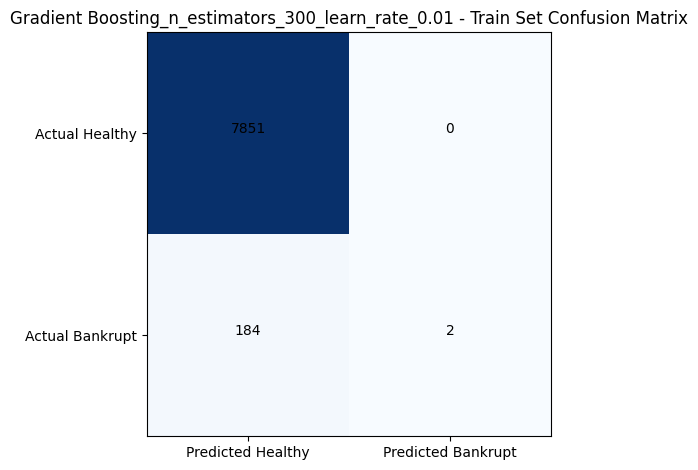

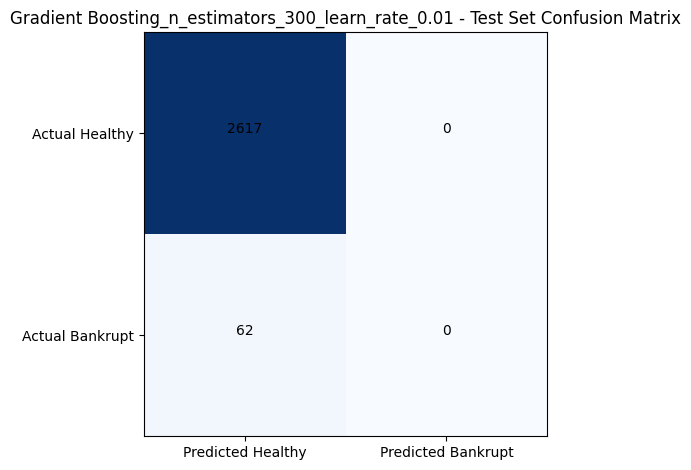

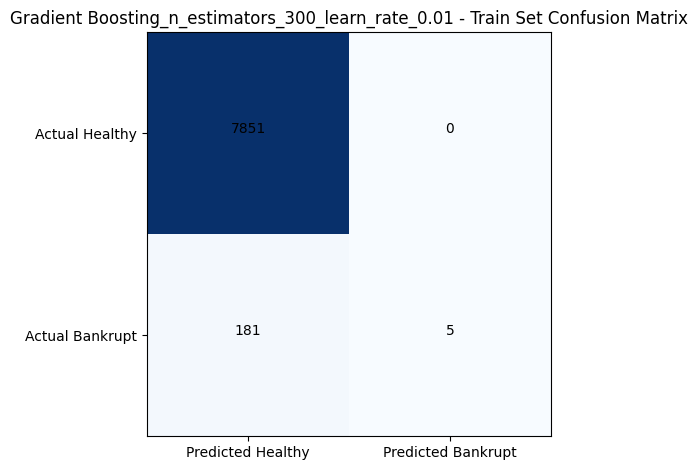

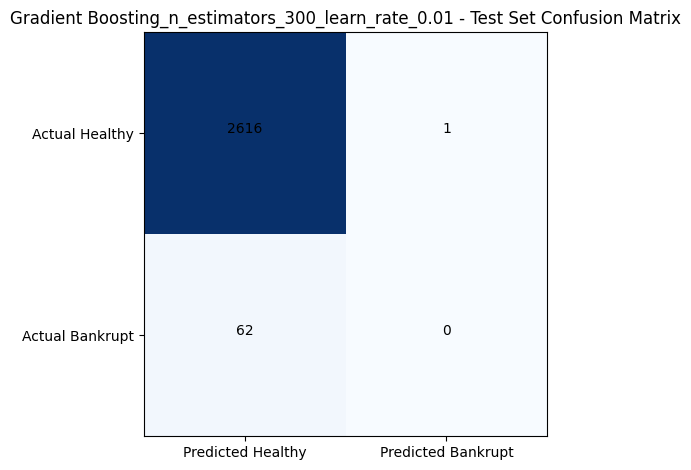

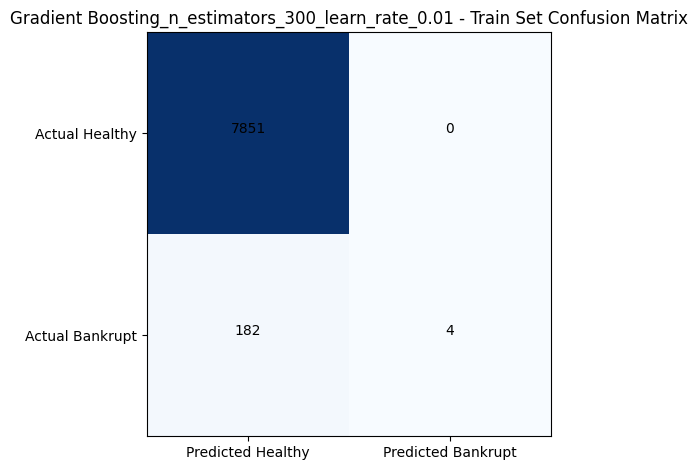

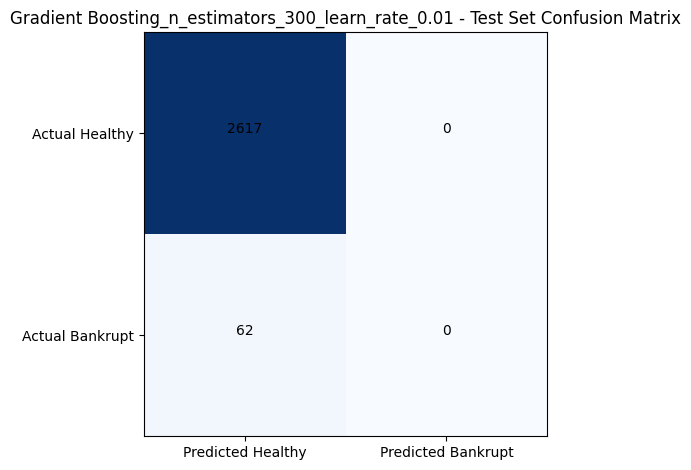

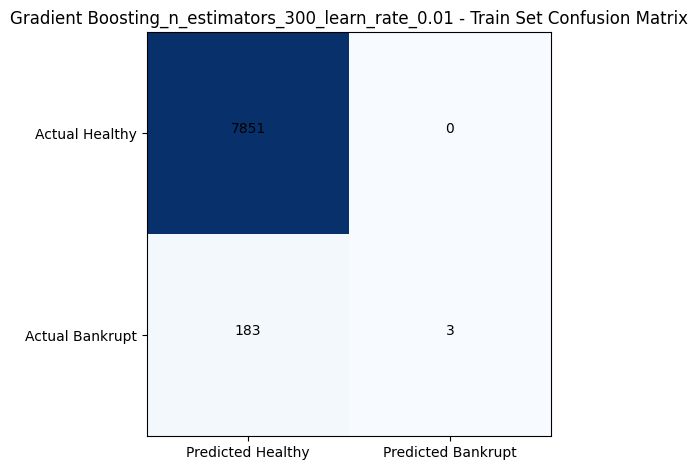

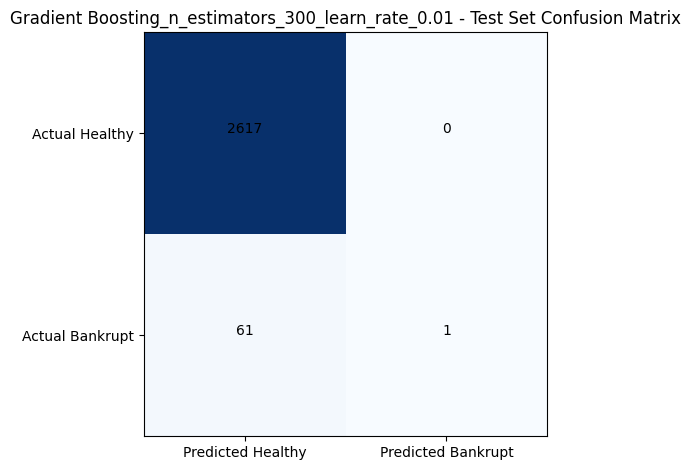


Gradient Boosting_n_estimators_300_learn_rate_0.01 - Train Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.01

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Test Set Performance (Fold 1):
Success Rate Healthy: 1.00, Bankrupt: 0.03

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Train Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.02

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Test Set Performance (Fold 2):
Success Rate Healthy: 1.00, Bankrupt: 0.02

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Train Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.02

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Test Set Performance (Fold 3):
Success Rate Healthy: 1.00, Bankrupt: 0.00

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Train Set Performance (Fold 4):
Success Rate Healthy: 1.00, Bankrupt: 0.02

Gradient Boosting_n_estimators_300_learn_rate_0.01 - Test Set Performance (Fold 4):
Success Rate He

In [8]:
results_list = []

success_rates_dict = {}

for classifier_name, classifier in classifiers.items():
    print(f"Classifier: {classifier_name}")

    f1_scores_train, f1_scores_test, success_rates_train, success_rates_test = cross_validation(X, y, {classifier_name: classifier}, n_splits=4, random_state=None)

    success_rates_dict[classifier_name] = {'healthy': [], 'bankrupt': []}

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=None)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        f1_train = f1_scores_train[classifier_name]['healthy'][fold], f1_scores_train[classifier_name]['bankrupt'][fold]
        f1_test = f1_scores_test[classifier_name]['healthy'][fold], f1_scores_test[classifier_name]['bankrupt'][fold]

        cm_train, _, auc_roc_train, _, _ = evaluate_model(classifier, X_train, y_train)
        cm_test, _, auc_roc_test, _, _ = evaluate_model(classifier, X_test, y_test)

        success_rate_healthy_train = cm_train[0, 0] / (cm_train[0, 0] + cm_train[0, 1])
        success_rate_bankrupt_train = cm_train[1, 1] / (cm_train[1, 0] + cm_train[1, 1])
        success_rate_healthy_test = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])
        success_rate_bankrupt_test = cm_test[1, 1] / (cm_test[1, 0] + cm_test[1, 1])

        print(f"\n{classifier_name} - Train Set Performance (Fold {fold + 1}):")
        print(f"Success Rate Healthy: {success_rate_healthy_train:.2f}, Bankrupt: {success_rate_bankrupt_train:.2f}")
        print(f"\n{classifier_name} - Test Set Performance (Fold {fold + 1}):")
        print(f"Success Rate Healthy: {success_rate_healthy_test:.2f}, Bankrupt: {success_rate_bankrupt_test:.2f}")

        success_rates_dict[classifier_name]['healthy'].append(success_rate_healthy_test)
        success_rates_dict[classifier_name]['bankrupt'].append(success_rate_bankrupt_test)

        results_list.append({'Classifier Name': classifier_name,
                             'Dataset': 'Train',
                             'Balance': 'Unbalanced',
                             'Num Training Samples': len(X_train),
                             'Num Non-Healthy Companies': sum(y_train),
                             'TP': cm_train[1, 1],
                             'TN': cm_train[0, 0],
                             'FP': cm_train[0, 1],
                             'FN': cm_train[1, 0],
                             'F1 Score': f1_train[0],
                             'AUC ROC': auc_roc_train})

        results_list.append({'Classifier Name': classifier_name,
                             'Dataset': 'Test',
                             'Balance': 'Unbalanced',
                             'Num Training Samples': len(X_test),
                             'Num Non-Healthy Companies': sum(y_test),
                             'TP': cm_test[1, 1],
                             'TN': cm_test[0, 0],
                             'FP': cm_test[0, 1],
                             'FN': cm_test[1, 0],
                             'F1 Score': f1_test[0],
                             'AUC ROC': auc_roc_test})

results_df = pd.DataFrame(results_list)

results_df.to_csv('unbalancedDataOutcomes.csv', index=False)

print("\nSuccess Rates for Each Classifier:")
for classifier_name, rates in success_rates_dict.items():
    print(classifier_name)
    print("Healthy:", sum(rates['healthy']) / len(rates['healthy']))
    print("Bankrupt:", sum(rates['bankrupt']) / len(rates['bankrupt']))


In [9]:
bankrupt_threshold = 0.60
non_bankrupt_threshold = 0.70

best_models = []

for classifier_name, rates in success_rates_dict.items():
    avg_success_rate_bankrupt = sum(rates['bankrupt']) / len(rates['bankrupt'])
    avg_success_rate_non_bankrupt = sum(rates['healthy']) / len(rates['healthy'])

    if avg_success_rate_bankrupt >= bankrupt_threshold and avg_success_rate_non_bankrupt >= non_bankrupt_threshold:
        best_models.append(classifier_name)

print("Best Models:")
for model in best_models:
    print(model)


Best Models:
Decision Tree_max_depth_15
Random Forest_n_estimators_300_max_depth_15


In [ ]:
new_success_rates_dict = {}

for classifier_name, classifier in classifiers.items():
    print(f"Classifier: {classifier_name}")

    skf = StratifiedKFold(n_splits=4, shuffle=False, random_state=None)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        new_success_rates_dict[classifier_name] = {'healthy': [], 'bankrupt': []}

        X_train_balanced, y_train_balanced = balance_train_set(X_train, y_train)

        classifier.fit(X_train_balanced, y_train_balanced)

        cm_train = confusion_matrix(y_train_balanced, classifier.predict(X_train_balanced))
        cm_test = confusion_matrix(y_test, classifier.predict(X_test))
        f1_train = f1_score(y_train_balanced, classifier.predict(X_train_balanced))
        f1_test = f1_score(y_test, classifier.predict(X_test))
        auc_roc_train = roc_auc_score(y_train_balanced, classifier.predict(X_train_balanced))
        auc_roc_test = roc_auc_score(y_test, classifier.predict(X_test))

        success_rate_healthy_train = cm_train[0, 0] / sum(y_train_balanced == 0)
        success_rate_bankrupt_train = cm_train[1, 1] / sum(y_train_balanced == 1)
        success_rate_healthy_test = cm_test[0, 0] / sum(y_test == 0)
        success_rate_bankrupt_test = cm_test[1, 1] / sum(y_test == 1)

        print(f"\n{classifier_name} - Train Set Performance (Fold {fold + 1}):")
        print(f"F1 Score: {f1_train:.2f}")
        print(f"AUC ROC: {auc_roc_train:.2f}")
        print(f"Success Rate Healthy: {success_rate_healthy_train:.2f}")
        print(f"Success Rate Bankrupt: {success_rate_bankrupt_train:.2f}")
        print(f"\n{classifier_name} - Test Set Performance (Fold {fold + 1}):")
        print(f"F1 Score: {f1_test:.2f}")
        print(f"AUC ROC: {auc_roc_test:.2f}")
        print(f"Success Rate Healthy: {success_rate_healthy_test:.2f}")
        print(f"Success Rate Bankrupt: {success_rate_bankrupt_test:.2f}")

        new_success_rates_dict[classifier_name]['healthy'].append(success_rate_healthy_test)
        new_success_rates_dict[classifier_name]['bankrupt'].append(success_rate_bankrupt_test)

        results_list.append({'Classifier Name': classifier_name,
                             'Dataset': 'Train',
                             'Balance': 'Balanced',
                             'Num Training Samples': len(X_train_balanced),
                             'Num Non-Healthy Companies': sum(y_train_balanced),
                             'TP': cm_train[1, 1],
                             'TN': cm_train[0, 0],
                             'FP': cm_train[0, 1],
                             'FN': cm_train[1, 0],
                             'F1 Score': f1_train,
                             'AUC ROC': auc_roc_train})

        results_list.append({'Classifier Name': classifier_name,
                             'Dataset': 'Test',
                             'Balance': 'Balanced',
                             'Num Training Samples': len(X_test),
                             'Num Non-Healthy Companies': sum(y_test),
                             'TP': cm_test[1, 1],
                             'TN': cm_test[0, 0],
                             'FP': cm_test[0, 1],
                             'FN': cm_test[1, 0],
                             'F1 Score': f1_test,
                             'AUC ROC': auc_roc_test})

results_df = pd.DataFrame(results_list)

results_df.to_csv('balancedDataOutcomes.csv', index=False)

print("\nResults saved in balancedDataOutcomes.csv.")


In [11]:
bankrupt_threshold = 0.60
non_bankrupt_threshold = 0.70

best_models = []

for classifier_name, rates in new_success_rates_dict.items():
    avg_success_rate_bankrupt = sum(rates['bankrupt']) / len(rates['bankrupt'])
    avg_success_rate_non_bankrupt = sum(rates['healthy']) / len(rates['healthy'])

    if avg_success_rate_bankrupt >= bankrupt_threshold and avg_success_rate_non_bankrupt >= non_bankrupt_threshold:
        best_models.append(classifier_name)

print("Best Models after balancing:")
for model in best_models:
    print(model)


Best Models after balancing:
Decision Tree_max_depth_5
Decision Tree_max_depth_15
Random Forest_n_estimators_100_max_depth_5
Random Forest_n_estimators_200_max_depth_10
Random Forest_n_estimators_300_max_depth_15
Gradient Boosting_n_estimators_100_learn_rate_0.1
Gradient Boosting_n_estimators_200_learn_rate_0.05


In [20]:
unbalanced_data = pd.read_csv('unbalancedDataOutcomes.csv')
balanced_data = pd.read_csv('balancedDataOutcomes.csv')

combined_data = pd.concat([unbalanced_data, balanced_data])

combined_data.to_excel('combined_data.xlsx', index=False)